In [1]:
import sys
sys.path.append('pathtoscritps')
import mm_helpers
import argparse, os, glob, random,sys
import numpy as np
import mm_GetInfoFromDb
import subprocess
import nibabel
import rc_helpers
import copy
import random
import matplotlib.pyplot as plt
import rc_GetInfoFromDb
import numpy as np
import seaborn as sns

import scipy.stats
import scipy.integrate
import alb_MM_functions as alb

import scipy

In [2]:
get_ipython().magic(u'pylab inline')

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pymatch

parameter

In [4]:
cond='179'
atlas='atlas_complete_GM'

matrices='ZpartialCorrelation'
method='_ledoit_wolf'
family=0



find and read data

In [5]:

data=['pathtodata/preproc/fMRI_RS/SUBJECT/matrices/preprocessing.feat/times_series/ICA_AROMA_nonaggr_nr_hp_'+atlas+'_1mm_4D_warped_th_reg_'+matrices+''+method+'_149_152_155_158_159_160NORM95.txt',
            'pathtodata/preproc/fMRI_STOP/SUBJECT/matrices.feat/nuissance/denoised_func_data_nonaggr/times_series/denoised_func_data_nonaggr_hp_'+atlas+'_1mm_4D_warped_th_reg_'+matrices+''+method+'_149_152_155_158_159_160NORM95.txt',
            'pathtodata/preproc/fMRI_REWARD/SUBJECT/matrices.feat/nuissance/denoised_func_data_nonaggr/times_series/denoised_func_data_nonaggr_hp_'+atlas+'_1mm_4D_warped_th_reg_'+matrices+''+method+'_149_152_155_158_159_160NORM95.txt',
            'pathtodata/preproc/fMRI_WM/SUBJECT/matrices.feat/nuissance/denoised_func_data_nonaggr/times_series/denoised_func_data_nonaggr_hp_'+atlas+'_1mm_4D_warped_th_reg_'+matrices+''+method+'_149_152_155_158_159_160NORM95.txt',
            ]
NeuroIMAGE=['RS','STOP','REWARD','WM']
fold='results'
#Subject selection
if True:
    suj=[np.unique([mm_helpers.find_subject(i,'NeuroIMAGE') for i in glob.glob(j.replace('SUBJECT','*').replace('CONDITION','*'))]) for j in data]
    sujCONTROL=[np.unique([mm_helpers.find_subject(i,'NeuroIMAGE') for i in glob.glob(j.replace('SUBJECT','*').replace('CONDITION','*'))]) for j in data]
    sujADHD=[np.unique([mm_helpers.find_subject(i,'NeuroIMAGE') for i in glob.glob(j.replace('SUBJECT','*').replace('CONDITION','*'))]) for j in data]
    sujSibADHD=[np.unique([mm_helpers.find_subject(i,'NeuroIMAGE') for i in glob.glob(j.replace('SUBJECT','*').replace('CONDITION','*'))]) for j in data]
    selec=len(NeuroIMAGE)
    allinfo=[dict() for t in range(selec)]
    allinfoADHD=[dict() for t in range(selec)]
    allinfoSibADHD=[dict() for t in range(selec)]
    allinfoCONTROL=[dict() for t in range(selec)]

    for t in range(selec):
        for s in suj[t]:
            allinfo[t].update({s : {s:s,'run':[]}})
            allinfoCONTROL[t].update({s : {s:s,'run':[]}})
            allinfoADHD[t].update({s : {s:s,'run':[]}})
            allinfoSibADHD[t].update({s : {s:s,'run':[]}})


        
        #if adhd==1:
        allinfoADHD[t]=rc_helpers.selectADHD(allinfoADHD[t])
        allinfoSibADHD[t]=rc_helpers.selectSibADHD(allinfoSibADHD[t])
        allinfoCONTROL[t]=rc_helpers.selectControlnotADHDsib(allinfoCONTROL[t])
        
        allinfo[t]=rc_helpers.check_movers(allinfo[t])
        allinfoCONTROL[t]=rc_helpers.check_movers(allinfoCONTROL[t])
        allinfoADHD[t]=rc_helpers.check_movers(allinfoADHD[t])
        allinfoSibADHD[t]=rc_helpers.check_movers(allinfoSibADHD[t])
        
        
        suj[t]=sorted(allinfo[t].keys())
        sujCONTROL[t]=sorted(allinfoCONTROL[t].keys())
        sujADHD[t]=sorted(allinfoADHD[t].keys())
        sujSibADHD[t]=sorted(allinfoSibADHD[t].keys())




494
188
494
112
494
136
['98-338-30162', '98-154-10229', '19-167-00008', '19-222-10529', '98-364-30277', '19-167-10288', '19-246-10633', '19-246-10634', '98-347-30201', '19-832-8099', '98-335-30149', '19-112-10049', '19-59-1066', '19-136-10152', '19-136-10151', '19-136-10150', '98-209-20039', '98-520-1386', '19-154-10234', '19-93-1156', '98-208-20034', '19-831-8096', '19-51-0012', '19-227-10551']
['19-832-8099', '19-59-1066', '98-520-1386', '19-93-1156', '19-831-8096', '19-51-0012']
['98-338-30162', '19-167-00008', '98-364-30277', '19-246-10633', '19-246-10634', '19-112-10049', '19-136-10150', '19-154-10234', '98-208-20034']
['19-167-10288', '98-335-30149', '19-136-10152', '19-136-10151', '19-227-10551']
413
176
413
106
413
131
['98-230-20142', '19-21-1024', '19-21-1025', '98-347-30202', '98-530-1426', '98-335-30149', '19-90-1150', '98-535-1449', '19-96-1161', '19-136-10152', '19-136-10151', '19-266-10723', '19-260-10700', '98-331-30131', '98-520-1386', '19-154-10234', '19-93-1156', '9

In [6]:
comorb=['CHRONIC MOTOR OR VOCAL TIC-DISORDER TOGETHER','DIAGNOSIS CD TOGETHER','DIAGNOSIS ODD TOGETHER','GILLES DE LA TOURETTE SYNDROME TOGETHER','TRANSIENT TIC-DISORDER TOGETHER']


In [7]:
import csv
allinfo_comorb=dict()

for i in csv.DictReader(open("pathtodata/ODD_CD_TS_4Roselyne.csv")):
    allinfo_comorb[i['Subject']]=i
    

In [8]:
## read phenotype info and other

myquery2= """SELECT `Subject`,`age` FROM `Phenotype_info`"""#number,ScanAge,_derived
allinfo_age = rc_GetInfoFromDb.get_query(myquery2,['subject','age'],"neuroimage")

myquery2= """SELECT `Subject`,`Gender` FROM `Phenotype_info`"""
allinfo_gender = rc_GetInfoFromDb.get_query(myquery2,['subject','gender'],"neuroimage")

queryT = "SELECT `subject_number`,`SeriesNumber`,`ScanProtocol`,`rmsFD_Jenkinson`  FROM `MRI_series_info` "
allinfo_rms=rc_GetInfoFromDb.get_query(queryT, ['subject','sn','sp','jen'], 'neuroimage', True)
#myquery2= """SELECT `subject_number`,`rmsFD_Jenkinson` FROM `MRI_series_info`"""
#allinfo_rms = mm_GetInfoFromDb.get_query(myquery2,['subject','rms'],"neuroimage")
queryT = "SELECT `subject_number`,`TR_fMRI`,`TR_rsfMRI`,`StationName`  FROM `MRI_session_info` "
allinfo_TR=rc_GetInfoFromDb.get_query(queryT, ['subject','tr','trrs','loc'], 'neuroimage', True) #SONATA1 = Amsterdam

queryT = "SELECT `subject_number`,`SeriesNumber`,`ScanProtocol`,`n_tot_ICs`,`n_incl_ICs`  FROM `MRI_series_info` "
allinfo_aroma=rc_GetInfoFromDb.get_query(queryT, ['subject','sn','sp','ntot','nexcl'], 'neuroimage', True)

queryT = "SELECT `Subject`,`Family`  FROM `Phenotype_info` "
allinfo_family=rc_GetInfoFromDb.get_query(queryT, ['subject','family'], 'neuroimage', True)


queryT = "SELECT `Subject`,`Combined_Symptoms_inatt`,`Combined_Symptoms_hyper`,`IQ`,`Medi_parents`  FROM `Phenotype_info` "
allinfo_symptoms=rc_GetInfoFromDb.get_query(queryT, ['subject','inatt','hyper','IQ','Medi'], 'neuroimage', True)


In [9]:
##load matrices for ADHD
atlasname='pathtodata/atlases/test.nii.gz'
UpmatricesADHD=[[] for t in range(len(NeuroIMAGE))]
UpmatricesADHDREST=[[] for t in range(len(NeuroIMAGE))]
ageADHD=[[] for t in range(len(sujADHD))]
genderADHD=[[] for t in range(len(sujADHD))]
IQADHD=[[] for t in range(len(sujADHD))]
MediADHD=[[] for t in range(len(sujADHD))]
locADHD=[[] for t in range(len(sujADHD))]
inattADHD=[[] for t in range(len(sujADHD))]
hyperADHD=[[] for t in range(len(sujADHD))]
comorbADHD=[[] for t in range(len(sujADHD))]
rmsADHD=[[] for t in range(len(sujADHD))]
neADHD=[[] for t in range(len(sujADHD))]
ntADHD=[[] for t in range(len(sujADHD))]
trADHD=[[] for t in range(len(sujADHD))]
tri=np.zeros((number,number))
tri[np.triu_indices(number,1)]=1
keepsujADHD=[[] for i in range(len(sujADHD))]
familyADHD=[[] for i in range(len(sujADHD))]

for t in range(len(NeuroIMAGE)):
	for s in sujADHD[t]:
		dat=glob.glob(data[t].replace('SUBJECT',s))
		for f in dat:
			do=1
			if t!=0:
				if s in sujADHD[0]:
					prov=np.loadtxt(f)
					provrest=np.loadtxt(glob.glob(data[0].replace('SUBJECT',s))[0])
				else:
					do=0
			else:
				prov=np.loadtxt(f)
			if do==1:
				keepsujADHD[t]+=[s]
			#normalization
				prov=np.loadtxt(f)
				if t!=0:
					provrest=np.loadtxt((glob.glob(data[0].replace('SUBJECT',s))[0]))
					prov=prov-provrest
				UpmatricesADHD[t]+=[prov]
				familyADHD[t]+=[(allinfo_family[k]['family']) for k in allinfo_family.keys() if allinfo_family[k]['subject']==s]
				ageADHD[t]+=[np.float(allinfo_age[k]['age']) for k in allinfo_age.keys() if allinfo_age[k]['subject']==s]
				genderADHD[t]+=[allinfo_gender[k]['gender'] for k in allinfo_gender.keys() if allinfo_gender[k]['subject']==s]
				hyperADHD[t]+=[allinfo_symptoms[k]['hyper'] for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				inattADHD[t]+=[allinfo_symptoms[k]['inatt'] for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				IQADHD[t]+=[allinfo_symptoms[k]['IQ'] for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				MediADHD[t]+=[int(allinfo_symptoms[k]['Medi']=='Y') for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				comorbADHD[t]+=[np.sign(np.sum([int(allinfo_comorb[k][a]!='888') for a in comorb])) for k in allinfo_comorb.keys() if allinfo_comorb[k]['Subject']==s]
				locADHD[t]+=[int(allinfo_TR[k]['loc']=='SONATA1') for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]
				if t!=0:
					rmsADHD[t]+=[np.mean([allinfo_rms[k]['jen'] for k in allinfo_rms.keys() if (allinfo_rms[k]['subject']==s) & (allinfo_rms[k]['sp']=='fMRI_'+NeuroIMAGE[t])])]
					neADHD[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['nexcl'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='fMRI_'+NeuroIMAGE[t])] if g!=None])]
					ntADHD[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['ntot'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='fMRI_'+NeuroIMAGE[t])] if g!=None])]
					trADHD[t]+=[allinfo_TR[k]['tr'] for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]
				if t==0:
					rmsADHD[t]+=[np.mean([allinfo_rms[k]['jen'] for k in allinfo_rms.keys() if (allinfo_rms[k]['subject']==s) & (allinfo_rms[k]['sp']=='rs_fMRI')])]
					neADHD[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['nexcl'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='rs_fMRI')] if g!=None])]
					ntADHD[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['ntot'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='rs_fMRI')] if g!=None])]
					trADHD[t]+=[allinfo_TR[k]['trrs'] for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]

In [10]:
##load data for siblings
atlasname='pathtodata/atlases/test.nii.gz'
UpmatricesSibADHD=[[] for t in range(len(NeuroIMAGE))]
UpmatricesSibADHDREST=[[] for t in range(len(NeuroIMAGE))]
ageSibADHD=[[] for t in range(len(sujSibADHD))]
genderSibADHD=[[] for t in range(len(sujSibADHD))]
rmsSibADHD=[[] for t in range(len(sujSibADHD))]
neSibADHD=[[] for t in range(len(sujSibADHD))]
ntSibADHD=[[] for t in range(len(sujSibADHD))]
trSibADHD=[[] for t in range(len(sujSibADHD))]
inattSibADHD=[[] for t in range(len(sujSibADHD))]
hyperSibADHD=[[] for t in range(len(sujSibADHD))]
tri=np.zeros((number,number))
tri[np.triu_indices(number,1)]=1
keepsujSibADHD=[[] for i in range(len(sujSibADHD))]
familySibADHD=[[] for i in range(len(sujSibADHD))]
IQSibADHD=[[] for t in range(len(sujSibADHD))]
MediSibADHD=[[] for t in range(len(sujSibADHD))]
locSibADHD=[[] for t in range(len(sujSibADHD))]


for t in range(len(NeuroIMAGE)):
	for s in sujSibADHD[t]:
		dat=glob.glob(data[t].replace('SUBJECT',s))
		for f in dat:
			do=1
			if t!=0:
				if s in sujSibADHD[0]:
					prov=np.loadtxt(f)
					provrest=np.loadtxt(glob.glob(data[0].replace('SUBJECT',s))[0])
				else:
					do=0
			else:
				prov=np.loadtxt(f)
			if do==1:
				keepsujSibADHD[t]+=[s]
			#normalization
				prov=np.loadtxt(f)
				if t!=0:
					provrest=np.loadtxt((glob.glob(data[0].replace('SUBJECT',s))[0]))
					prov=prov-provrest
				UpmatricesSibADHD[t]+=[prov]

				familySibADHD[t]+=[(allinfo_family[k]['family']) for k in allinfo_family.keys() if allinfo_family[k]['subject']==s]
				ageSibADHD[t]+=[np.float(allinfo_age[k]['age']) for k in allinfo_age.keys() if allinfo_age[k]['subject']==s]
				genderSibADHD[t]+=[allinfo_gender[k]['gender'] for k in allinfo_gender.keys() if allinfo_gender[k]['subject']==s]
				hyperSibADHD[t]+=[allinfo_symptoms[k]['hyper'] for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				inattSibADHD[t]+=[allinfo_symptoms[k]['inatt'] for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				IQSibADHD[t]+=[allinfo_symptoms[k]['IQ'] for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				MediSibADHD[t]+=[int(allinfo_symptoms[k]['Medi']=='Y') for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				locSibADHD[t]+=[int(allinfo_TR[k]['loc']=='SONATA1') for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]
				if t!=0:
					rmsSibADHD[t]+=[np.mean([allinfo_rms[k]['jen'] for k in allinfo_rms.keys() if (allinfo_rms[k]['subject']==s) & (allinfo_rms[k]['sp']=='fMRI_'+NeuroIMAGE[t])])]
					trSibADHD[t]+=[allinfo_TR[k]['tr'] for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]
					neSibADHD[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['nexcl'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='fMRI_'+NeuroIMAGE[t])] if g!=None])]
					ntSibADHD[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['ntot'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='fMRI_'+NeuroIMAGE[t])] if g!=None])]
				if t==0:
					rmsSibADHD[t]+=[np.mean([allinfo_rms[k]['jen'] for k in allinfo_rms.keys() if (allinfo_rms[k]['subject']==s) & (allinfo_rms[k]['sp']=='rs_fMRI')])]
					neSibADHD[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['nexcl'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='rs_fMRI')] if g!=None])]
					ntSibADHD[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['ntot'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='rs_fMRI')] if g!=None])]
					trSibADHD[t]+=[allinfo_TR[k]['trrs'] for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]


In [11]:
##load data for control

atlasname='pathtodata/atlases/test.nii.gz'
UpmatricesCONTROL=[[] for t in range(len(NeuroIMAGE))]
UpmatricesCONTROLREST=[[] for t in range(len(NeuroIMAGE))]
ageCONTROL=[[] for t in range(len(sujCONTROL))]
genderCONTROL=[[] for t in range(len(sujCONTROL))]
inattCONTROL=[[] for t in range(len(sujCONTROL))]
hyperCONTROL=[[] for t in range(len(sujCONTROL))]
rmsCONTROL=[[] for t in range(len(sujCONTROL))]
neCONTROL=[[] for t in range(len(sujCONTROL))]
ntCONTROL=[[] for t in range(len(sujCONTROL))]
trCONTROL=[[] for t in range(len(sujCONTROL))]
tri=np.zeros((number,number))
tri[np.triu_indices(number,1)]=1
keepsujCONTROL=[[] for i in range(len(sujCONTROL))]
familyCONTROL=[[] for i in range(len(sujCONTROL))]
IQCONTROL=[[] for t in range(len(sujCONTROL))]
MediCONTROL=[[] for t in range(len(sujCONTROL))]
locCONTROL=[[] for t in range(len(sujCONTROL))]

for t in range(len(NeuroIMAGE)):
	for s in sujCONTROL[t]:
		dat=glob.glob(data[t].replace('SUBJECT',s))
		for f in dat:
			do=1
			if t!=0:
				if s in sujCONTROL[0]:
					prov=np.loadtxt(f)
					provrest=np.loadtxt(glob.glob(data[0].replace('SUBJECT',s))[0])
				else:
					do=0
			else:
				prov=np.loadtxt(f)
			if do==1:
				keepsujCONTROL[t]+=[s]
			#normalization
				prov=np.loadtxt(f)
				if t!=0:
					provrest=np.loadtxt((glob.glob(data[0].replace('SUBJECT',s))[0]))
					prov=prov-provrest
				UpmatricesCONTROL[t]+=[prov]

				familyCONTROL[t]+=[(allinfo_family[k]['family']) for k in allinfo_family.keys() if allinfo_family[k]['subject']==s]
				ageCONTROL[t]+=[np.float(allinfo_age[k]['age']) for k in allinfo_age.keys() if allinfo_age[k]['subject']==s]
				genderCONTROL[t]+=[allinfo_gender[k]['gender'] for k in allinfo_gender.keys() if allinfo_gender[k]['subject']==s]
				hyperCONTROL[t]+=[allinfo_symptoms[k]['hyper'] for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				inattCONTROL[t]+=[allinfo_symptoms[k]['inatt'] for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				IQCONTROL[t]+=[allinfo_symptoms[k]['IQ'] for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				MediCONTROL[t]+=[int(allinfo_symptoms[k]['Medi']=='Y') for k in allinfo_symptoms.keys() if allinfo_symptoms[k]['subject']==s]
				locCONTROL[t]+=[int(allinfo_TR[k]['loc']=='SONATA1') for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]
				if t!=0:
					rmsCONTROL[t]+=[np.mean([allinfo_rms[k]['jen'] for k in allinfo_rms.keys() if (allinfo_rms[k]['subject']==s) & (allinfo_rms[k]['sp']=='fMRI_'+NeuroIMAGE[t])])]
					trCONTROL[t]+=[allinfo_TR[k]['tr'] for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]
					neCONTROL[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['nexcl'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='fMRI_'+NeuroIMAGE[t])] if g!=None])]
					ntCONTROL[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['ntot'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='fMRI_'+NeuroIMAGE[t])] if g!=None])]
				if t==0:
					rmsCONTROL[t]+=[np.mean([allinfo_rms[k]['jen'] for k in allinfo_rms.keys() if (allinfo_rms[k]['subject']==s) & (allinfo_rms[k]['sp']=='rs_fMRI')])]
					neCONTROL[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['nexcl'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='rs_fMRI')] if g!=None])]
					ntCONTROL[t]+=[np.mean([int(g) for g in [allinfo_aroma[k]['ntot'] for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='rs_fMRI')] if g!=None])]
					trCONTROL[t]+=[allinfo_TR[k]['trrs'] for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]



In [12]:
#sample size before removing family members
print [len(keepsujADHD[t]) for t in range(4)],[len(keepsujSibADHD[t]) for t in range(4)],[len(keepsujCONTROL[t]) for t in range(4)]


[179, 88, 116, 88] [107, 64, 65, 51] [130, 67, 70, 99]


In [12]:
myquery2= """SELECT Daan_Data.Subjects,  Daan_Data.RTV, Daan_Data.SSRT
	FROM
	Daan_Data"""
#Daan_Data.RT,
# <codecell>


allinfo_behav = rc_GetInfoFromDb.get_query(myquery2,['subject','RTV','SSRT'],"image_private")#, 'RT'
for s in allinfo_behav.keys():
	if allinfo_behav[s]['RTV']==None:
		del allinfo_behav[s]

stopIndexCONTROL=[[] for t in range(len(data))]
stopRTVCONTROL=[[] for t in range(len(data))]
stopSSRTCONTROL=[[] for t in range(len(data))]
for t in range(len(sujCONTROL)):
	for i in range(len(sujCONTROL[t])):
		if sujCONTROL[t][i] in allinfo_behav.keys():
			stopIndexCONTROL[t].append(i)
			stopRTVCONTROL[t].append(allinfo_behav[sujCONTROL[t][i]]['RTV'])
			stopSSRTCONTROL[t].append(allinfo_behav[sujCONTROL[t][i]]['SSRT'])
            
stopIndexADHD=[[] for t in range(len(data))]
stopRTVADHD=[[] for t in range(len(data))]
stopSSRTADHD=[[] for t in range(len(data))]
for t in range(len(sujADHD)):
	for i in range(len(sujADHD[t])):
		if sujADHD[t][i] in allinfo_behav.keys():
			stopIndexADHD[t].append(i)
			stopRTVADHD[t].append(allinfo_behav[sujADHD[t][i]]['RTV'])
			stopSSRTADHD[t].append(allinfo_behav[sujADHD[t][i]]['SSRT'])
            
stopIndexSibADHD=[[] for t in range(len(data))]
stopRTVSibADHD=[[] for t in range(len(data))]
stopSSRTSibADHD=[[] for t in range(len(data))]
for t in range(len(sujSibADHD)):
	for i in range(len(sujSibADHD[t])):
		if sujSibADHD[t][i] in allinfo_behav.keys():
			stopIndexSibADHD[t].append(i)
			stopRTVSibADHD[t].append(allinfo_behav[sujSibADHD[t][i]]['RTV'])
			stopSSRTSibADHD[t].append(allinfo_behav[sujSibADHD[t][i]]['SSRT'])

####################
####################
#nResponsesCue
myquery2= """SELECT NPO_Reward.Subject,  NPO_Reward.DiffRT
	FROM
	NPO_Reward"""
#Daan_Data.RT,#RTdiff
# <codecell>


allinfo_behav = rc_GetInfoFromDb.get_query(myquery2,['subject','RTdiff'],"danvrhe")#, 'RT'#RTdiff
for s in allinfo_behav.keys():
	if allinfo_behav[s]['RTdiff']==None:
		del allinfo_behav[s]

rewardIndexCONTROL=[[] for t in range(len(data))]
rewardRTdiffCONTROL=[[] for t in range(len(data))]
for t in range(len(sujCONTROL)):
	for i in range(len(sujCONTROL[t])):
		if sujCONTROL[t][i] in allinfo_behav.keys():
			rewardIndexCONTROL[t].append(i)
			rewardRTdiffCONTROL[t].append(allinfo_behav[sujCONTROL[t][i]]['RTdiff'])

rewardIndexADHD=[[] for t in range(len(data))]
rewardRTdiffADHD=[[] for t in range(len(data))]
for t in range(len(sujADHD)):
	for i in range(len(sujADHD[t])):
		if sujADHD[t][i] in allinfo_behav.keys():
			rewardIndexADHD[t].append(i)
			rewardRTdiffADHD[t].append(allinfo_behav[sujADHD[t][i]]['RTdiff'])

rewardIndexSibADHD=[[] for t in range(len(data))]
rewardRTdiffSibADHD=[[] for t in range(len(data))]
for t in range(len(sujSibADHD)):
	for i in range(len(sujSibADHD[t])):
		if sujSibADHD[t][i] in allinfo_behav.keys():
			rewardIndexSibADHD[t].append(i)
			rewardRTdiffSibADHD[t].append(allinfo_behav[sujSibADHD[t][i]]['RTdiff'])

####################
####################

wm=open('pathtodata/WMperformance2.txt','r').read().split()
wm=np.reshape(wm,(len(wm)/2,2))


wmIndexCONTROL=[[] for t in range(len(data))]
wmPerfCONTROL=[[] for t in range(len(data))]
for t in range(len(sujCONTROL)):
	for i in range(len(sujCONTROL[t])):
		if sujCONTROL[t][i] in wm.T[0]:
			wmIndexCONTROL[t].append(i)
			wmPerfCONTROL[t].append(np.float(wm[np.where(wm.T[0]==sujCONTROL[t][i])][0][1]))

wmIndexADHD=[[] for t in range(len(data))]
wmPerfADHD=[[] for t in range(len(data))]
for t in range(len(sujADHD)):
	for i in range(len(sujADHD[t])):
		if sujADHD[t][i] in wm.T[0]:
			wmIndexADHD[t].append(i)
			wmPerfADHD[t].append(np.float(wm[np.where(wm.T[0]==sujADHD[t][i])][0][1]))

wmIndexSibADHD=[[] for t in range(len(data))]
wmPerfSibADHD=[[] for t in range(len(data))]
for t in range(len(sujSibADHD)):
	for i in range(len(sujSibADHD[t])):
		if sujSibADHD[t][i] in wm.T[0]:
			wmIndexSibADHD[t].append(i)
			wmPerfSibADHD[t].append(np.float(wm[np.where(wm.T[0]==sujSibADHD[t][i])][0][1]))



In [13]:
#################### IQ


myquery2= """SELECT `Subject`,`IQ` FROM `Phenotype_info`"""


allinfo_behav = rc_GetInfoFromDb.get_query(myquery2,['Subject','IQ'],"neuroimage")#, 'RT'#RTdiff
for s in allinfo_behav.keys():
	if allinfo_behav[s]['IQ']==None:
		del allinfo_behav[s]

iqIndexCONTROL=[[] for t in range(len(data))]
iqCONTROL=[[] for t in range(len(data))]
for t in range(len(sujCONTROL)):
	for i in range(len(sujCONTROL[t])):
		if sujCONTROL[t][i] in allinfo_behav.keys():
			iqIndexCONTROL[t].append(i)
			iqCONTROL[t].append(allinfo_behav[sujCONTROL[t][i]]['IQ'])

iqIndexADHD=[[] for t in range(len(data))]
iqADHD=[[] for t in range(len(data))]
for t in range(len(sujADHD)):
	for i in range(len(sujADHD[t])):
		if sujADHD[t][i] in allinfo_behav.keys():
			iqIndexADHD[t].append(i)
			iqADHD[t].append(allinfo_behav[sujADHD[t][i]]['IQ'])

iqIndexSibADHD=[[] for t in range(len(data))]
iqSibADHD=[[] for t in range(len(data))]
for t in range(len(sujSibADHD)):
	for i in range(len(sujSibADHD[t])):
		if sujSibADHD[t][i] in allinfo_behav.keys():
			iqIndexSibADHD[t].append(i)
			iqSibADHD[t].append(allinfo_behav[sujSibADHD[t][i]]['IQ'])
            
##############SymptomCountTotal


myquery2= """SELECT `Subject`,`Conners_other_AD` FROM `Phenotype_info`"""


allinfo_behav = rc_GetInfoFromDb.get_query(myquery2,['Subject','Conners_other_AD'],"neuroimage")#, 'RT'#RTdiff
for s in allinfo_behav.keys():
	if allinfo_behav[s]['Conners_other_AD']==None:
		del allinfo_behav[s]

SymptomCountTotalIndexCONTROL=[[] for t in range(len(data))]
SymptomCountTotalCONTROL=[[] for t in range(len(data))]
for t in range(len(sujCONTROL)):
	for i in range(len(sujCONTROL[t])):
		if sujCONTROL[t][i] in allinfo_behav.keys():  
			SymptomCountTotalIndexCONTROL[t].append(i)
			SymptomCountTotalCONTROL[t].append(allinfo_behav[sujCONTROL[t][i]]['Conners_other_AD'])

SymptomCountTotalIndexADHD=[[] for t in range(len(data))]
SymptomCountTotalADHD=[[] for t in range(len(data))]
for t in range(len(sujADHD)):
	for i in range(len(sujADHD[t])):
		if sujADHD[t][i] in allinfo_behav.keys():
			SymptomCountTotalIndexADHD[t].append(i)
			SymptomCountTotalADHD[t].append(allinfo_behav[sujADHD[t][i]]['Conners_other_AD'])

SymptomCountTotalIndexSibADHD=[[] for t in range(len(data))]
SymptomCountTotalSibADHD=[[] for t in range(len(data))]
for t in range(len(sujSibADHD)):
	for i in range(len(sujSibADHD[t])):
		if sujSibADHD[t][i] in allinfo_behav.keys():
			SymptomCountTotalIndexSibADHD[t].append(i)
			SymptomCountTotalSibADHD[t].append(allinfo_behav[sujSibADHD[t][i]]['Conners_other_AD'])
            
            
            
myquery2= """SELECT `Subject`,`Conners_other_HD` FROM `Phenotype_info`"""


allinfo_behav = rc_GetInfoFromDb.get_query(myquery2,['Subject','Conners_other_HD'],"neuroimage")#, 'RT'#RTdiff
for s in allinfo_behav.keys():
	if allinfo_behav[s]['Conners_other_HD']==None:
		del allinfo_behav[s]

SymptomCountTotalIndex2CONTROL=[[] for t in range(len(data))]
SymptomCountTotal2CONTROL=[[] for t in range(len(data))]
for t in range(len(sujCONTROL)):
	for i in range(len(sujCONTROL[t])):
		if sujCONTROL[t][i] in allinfo_behav.keys():  
			SymptomCountTotalIndex2CONTROL[t].append(i)
			SymptomCountTotal2CONTROL[t].append(allinfo_behav[sujCONTROL[t][i]]['Conners_other_HD'])

SymptomCountTotalIndex2ADHD=[[] for t in range(len(data))]
SymptomCountTotal2ADHD=[[] for t in range(len(data))]
for t in range(len(sujADHD)):
	for i in range(len(sujADHD[t])):
		if sujADHD[t][i] in allinfo_behav.keys():
			SymptomCountTotalIndex2ADHD[t].append(i)
			SymptomCountTotal2ADHD[t].append(allinfo_behav[sujADHD[t][i]]['Conners_other_HD'])

SymptomCountTotalIndex2SibADHD=[[] for t in range(len(data))]
SymptomCountTotal2SibADHD=[[] for t in range(len(data))]
for t in range(len(sujSibADHD)):
	for i in range(len(sujSibADHD[t])):
		if sujSibADHD[t][i] in allinfo_behav.keys():
			SymptomCountTotalIndex2SibADHD[t].append(i)
			SymptomCountTotal2SibADHD[t].append(allinfo_behav[sujSibADHD[t][i]]['Conners_other_HD'])

In [ ]:
totboot=20
#combine the bootstrap

names=['permutationtestingoverlapSENS80percent_randomlabel','permutationtestingoverlapUN80percent_randomlabel','permutationtestingoverlapSPE80percent_randomlabel','permutationtestingoverlapCOM80percent_randomlabel','permutationtestingoverlapSENS80percent','permutationtestingoverlapSPE80percent','permutationtestingoverlapCOM80percent','permutationtestingoverlapUN80percent']
keepnan=[[] for k in names]
for n,name in enumerate(names):
    #test2=glob.glob('pathtodata/TasksVsRS_MatriceResult/reordering/ADHDvsCONTROL_paired_BS_ControlZpartialCorrelation_LWwithoutGM/notNorm_subjectNorm_nofamilystructure/179/'+name+'_1030_*.npy')
    test2=['pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/'+name+'_1030_'+np.str(q)+'.npy' for q in range(totboot)]
    test=np.array([np.load(t).T for t in test2 if t.find('37s')==-1])
    test[np.where(np.isnan(test))]=0.
    test=np.concatenate(test,0).T
    
    np.save('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_'+name+'_1030.npy',test)


names=['permutationtestingoverlapSENS80percent_randomlabel_group','permutationtestingoverlapUN80percent_randomlabel_group','permutationtestingoverlapSPE80percent_randomlabel_group','permutationtestingoverlapCOM80percent_randomlabel_group','permutationtestingoverlapSENS80percent_group','permutationtestingoverlapSPE80percent_group','permutationtestingoverlapCOM80percent_group','permutationtestingoverlapUN80percent_group']
keepnan=[[] for k in names]
for n,name in enumerate(names):
    test2=['pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/'+name+'_1030_'+np.str(q)+'.npy' for q in range(totboot)]
    
    test=np.array([np.load(t).T for t in test2 if t.find('37s')==-1])
    test[np.where(np.isnan(test))]=0.
    test=np.concatenate(test,0).T
    
    np.save('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_'+name+'_1030.npy',test)


names=['mean80potency_','selec80potency_']
keepnan=[[] for k in names]
for n,name in enumerate(names):
    for e,g in enumerate(['ADHD','SIBLING','CONTROL','ADHD_randomlabel','SIBLING_randomlabel','CONTROL_randomlabel']):
        test2=['pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/'+name+g+'_1030_'+np.str(q)+'.npy' for q in range(totboot)]
    
        test=np.array([np.load(t).T for t in test2 if t.find('37s')==-1])
        test[np.where(np.isnan(test))]=0.
        test=np.concatenate(test,1).T
        np.save('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_'+name+g+'_1030.npy',test)


names=['permutationtestingoverlapSENS80percent_alledges_randomlabel','permutationtestingoverlapUN80percent_alledges_randomlabel','permutationtestingoverlapSPE80percent_alledges_randomlabel','permutationtestingoverlapCOM80percent_alledges_randomlabel','permutationtestingoverlapSENS80percent_alledges','permutationtestingoverlapSPE80percent_alledges','permutationtestingoverlapCOM80percent_alledges','permutationtestingoverlapUN80percent_alledges']
for name in names:
    test2=['pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/'+name+'_1030_'+np.str(q)+'.npy' for q in range(totboot)]
    test=np.mean([np.load(t) for t in test2 if t.find('37s')==-1],0)
    np.save('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_'+name+'_1030.npy',test)


names=['permutationtestingoverlapthreshold_group_randomlabel_80percent','permutationtestingoverlapthreshold_group_80percent']
for name in names:
    test2=['pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/'+name+'_1030_'+np.str(q)+'.npy' for q in range(totboot)]
    test=np.array([np.load(t).T for t in test2 if t.find('37s')==-1])
    test[np.where(np.isnan(test))]=0.
    test=np.concatenate(test,1).T
    np.save('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_'+name+'_1030.npy',test)

    

In [16]:
#remove family members

In [15]:
if family==0:
    #ADHD and siblings
    linkfamilyADHD=[np.zeros(len(keepsujADHD[i])) for i in range(len(keepsujADHD))]
    linkfamilySibADHD=[np.zeros(len(keepsujSibADHD[i])) for i in range(len(keepsujSibADHD))]
    linkfamilychosenADHD=[np.zeros(len(keepsujSibADHD[i])) for i in range(len(keepsujSibADHD))]
    linkfamilychosenSib=[np.zeros(len(keepsujADHD[i])) for i in range(len(keepsujADHD))]
    
    for t in range(len(keepsujADHD)):
        Nadhd=len(np.unique(familyADHD[t])) #ADHD family
        NadhdS=len(np.unique(familySibADHD[t])) #with siblings
        NadhdSA=len(np.unique([j for j in np.concatenate([familySibADHD[t],familyADHD[t]],axis=0) if j in familySibADHD[t] and j in familyADHD[t]])) #with siblings
        print NadhdSA,NadhdS,Nadhd
        a=-1 #alternate keep sib or ADHD
        for i in range(len(keepsujADHD[t])):
            if linkfamilyADHD[t][i]==0:
                linkfamilyADHD[t][np.where(np.array(familyADHD[t])==familyADHD[t][i])]=-1
                so=np.where(np.array(familySibADHD[t])==familyADHD[t][i])
                if len(so[0])!=0:
                    linkfamilySibADHD[t][so]=-1
                    
                    if a==0 or NadhdS-Nadhd>0:#keep ADHD reject siblings
                        linkfamilyADHD[t][i]=1
                        linkfamilychosenSib[t][i]=so[0][0]
                        print so[0][0]
                        if a==-1:
                            Nadhd+=1
                            NadhdSA+=-1
                        else:
                            a=1
                    elif a==1 or Nadhd-NadhdS>0: #keep one sibling, reject other and ADHD
                        linkfamilyADHD[t][i]=-1
                        linkfamilySibADHD[t][so[0][0]]=1
                        linkfamilychosenADHD[t][so[0][0]]=i
                        
                        if a==-1:
                            NadhdS+=1
                            NadhdSA+=-1
                        else:
                            a=0
                            
                    
                else:
                    linkfamilyADHD[t][i]=1
                    if a==-1:
                        Nadhd+=1
                        NadhdSA+=-1
                    else:
                        a=1
                if NadhdS-Nadhd==0 and a==-1:
                    print 'now'
                    a=0
                    NadhdSA=-1
        for i in range(len(keepsujSibADHD[t])):
            if linkfamilySibADHD[t][i]==0:
                linkfamilySibADHD[t][np.where(np.array(familySibADHD[t])==familySibADHD[t][i])]=-1
                linkfamilySibADHD[t][i]=1
        print NadhdSA,NadhdS,Nadhd     
    linkfamilyCONTROL=[np.zeros(len(keepsujCONTROL[i])) for i in range(len(keepsujCONTROL))]
    for t in range(len(keepsujCONTROL)):
        #keep only one
        
        for i in range(len(keepsujCONTROL[t])):
            if linkfamilyCONTROL[t][i]==0:
                linkfamilyCONTROL[t][np.where(np.array(familyCONTROL[t])==familyCONTROL[t][i])]=-1
                linkfamilyCONTROL[t][i]=1


59 93 148
-89 152 237
27 55 76
-49 82 125
37 57 94
-57 94 151
25 44 76
-51 69 127


In [16]:
## remove matrice,age,suj that are -1
import copy
if family==0:

    for t in range(len(UpmatricesCONTROL)):
        UpmatricesCONTROL[t]=[UpmatricesCONTROL[t][i] for i in range(len(UpmatricesCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
        ageCONTROL[t]=[ageCONTROL[t][i] for i in range(len(ageCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
        genderCONTROL[t]=[genderCONTROL[t][i] for i in range(len(genderCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
        rmsCONTROL[t]=[rmsCONTROL[t][i] for i in range(len(rmsCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
        trCONTROL[t]=[trCONTROL[t][i] for i in range(len(trCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
        neCONTROL[t]=[neCONTROL[t][i] for i in range(len(neCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
        ntCONTROL[t]=[ntCONTROL[t][i] for i in range(len(ntCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
        locCONTROL[t]=[locCONTROL[t][i] for i in range(len(locCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
        MediCONTROL[t]=[MediCONTROL[t][i] for i in range(len(MediCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
        IQCONTROL[t]=[IQCONTROL[t][i] for i in range(len(IQCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
        keepsujCONTROL[t]=[keepsujCONTROL[t][i] for i in range(len(keepsujCONTROL[t])) if linkfamilyCONTROL[t][i]==1]
       
    
        
    for t in range(len(UpmatricesADHD)):
        UpmatricesADHD[t]=[UpmatricesADHD[t][i] for i in range(len(UpmatricesADHD[t])) if linkfamilyADHD[t][i]==1]
        ageADHD[t]=[ageADHD[t][i] for i in range(len(ageADHD[t])) if linkfamilyADHD[t][i]==1]
        genderADHD[t]=[genderADHD[t][i] for i in range(len(genderADHD[t])) if linkfamilyADHD[t][i]==1]
        rmsADHD[t]=[rmsADHD[t][i] for i in range(len(rmsADHD[t])) if linkfamilyADHD[t][i]==1]
        trADHD[t]=[trADHD[t][i] for i in range(len(trADHD[t])) if linkfamilyADHD[t][i]==1]
        inattADHD[t]=[inattADHD[t][i] for i in range(len(inattADHD[t])) if linkfamilyADHD[t][i]==1]
        hyperADHD[t]=[hyperADHD[t][i] for i in range(len(hyperADHD[t])) if linkfamilyADHD[t][i]==1]
        neADHD[t]=[neADHD[t][i] for i in range(len(neADHD[t])) if linkfamilyADHD[t][i]==1]
        ntADHD[t]=[ntADHD[t][i] for i in range(len(ntADHD[t])) if linkfamilyADHD[t][i]==1]
        locADHD[t]=[locADHD[t][i] for i in range(len(locADHD[t])) if linkfamilyADHD[t][i]==1]
        MediADHD[t]=[MediADHD[t][i] for i in range(len(MediADHD[t])) if linkfamilyADHD[t][i]==1]
        comorbADHD[t]=[comorbADHD[t][i] for i in range(len(comorbADHD[t])) if linkfamilyADHD[t][i]==1]
        IQADHD[t]=[IQADHD[t][i] for i in range(len(IQADHD[t])) if linkfamilyADHD[t][i]==1]
        keepsujADHD[t]=[keepsujADHD[t][i] for i in range(len(keepsujADHD[t])) if linkfamilyADHD[t][i]==1]
      

    for t in range(len(UpmatricesSibADHD)):
        UpmatricesSibADHD[t]=[UpmatricesSibADHD[t][i] for i in range(len(UpmatricesSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        ageSibADHD[t]=[ageSibADHD[t][i] for i in range(len(ageSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        genderSibADHD[t]=[genderSibADHD[t][i] for i in range(len(genderSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        rmsSibADHD[t]=[rmsSibADHD[t][i] for i in range(len(rmsSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        trSibADHD[t]=[trSibADHD[t][i] for i in range(len(trSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        inattSibADHD[t]=[inattSibADHD[t][i] for i in range(len(inattSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        hyperSibADHD[t]=[hyperSibADHD[t][i] for i in range(len(hyperSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        neSibADHD[t]=[neSibADHD[t][i] for i in range(len(neSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        ntSibADHD[t]=[ntSibADHD[t][i] for i in range(len(ntSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        locSibADHD[t]=[locSibADHD[t][i] for i in range(len(locSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        MediSibADHD[t]=[MediSibADHD[t][i] for i in range(len(MediSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        IQSibADHD[t]=[IQSibADHD[t][i] for i in range(len(IQSibADHD[t])) if linkfamilySibADHD[t][i]==1]
        keepsujSibADHD[t]=[keepsujSibADHD[t][i] for i in range(len(keepsujSibADHD[t])) if linkfamilySibADHD[t][i]==1]
      

In [ ]:
##adjustement for matching sample

In [ ]:
#matching sample (replication, supplemental material)
break
from pymatch.Matcher import Matcher
import pandas as pd


df3=[dict() for t in range(3)]
for t in range(3):
    df2 = pd.DataFrame(columns=['subject','group','IQ','age','gender','site'])
    for s in range(len(UpmatricesADHD[t+1])):
        try:
            
            df2 = df2.append({'subject':keepsujADHD[t+1][s],'IQ':IQADHD[t+1][s],'site':locADHD[t+1][s],'age':ageADHD[t+1][s],'gender':np.int(genderADHD[t+1][s]=='M'),'group':'ADHD'}, ignore_index=True)       
        except:
            print t,s,'adhd'
    for s in range(len(UpmatricesSibADHD[t+1])):
        try:
            df2 = df2.append({'subject':keepsujSibADHD[t+1][s],'IQ':IQSibADHD[t+1][s],'site':locSibADHD[t+1][s],'age':ageSibADHD[t+1][s],'gender':np.int(genderSibADHD[t+1][s]=='M'),'group':'SibADHD'}, ignore_index=True)       
        except:
            print t,s,'sib'

    for s in range(len(UpmatricesCONTROL[t+1])):
        try:
            df2 = df2.append({'subject':keepsujCONTROL[t+1][s],'IQ':IQCONTROL[t+1][s],'site':locCONTROL[t+1][s],'age':ageCONTROL[t+1][s],'gender':np.int(genderCONTROL[t+1][s]=='M'),'group':'CONTROL',}, ignore_index=True)       
        except:
            print t,s,'con'
    
    for k in df2['subject']:
        df3[t].update({k : {'match':[0,0,0]}})
    
    
    g1 = df2[df2.group == 'ADHD']
    g2 = df2[df2.group == 'SibADHD']
    g3 = df2[df2.group == 'CONTROL']
    
    g1['group'] = 0
    g2['group'] = 1
    g3['group'] = 0
    #g1 g2
    m = Matcher(g1, g2, yvar="group", exclude=['subject'])
    m.fit_scores(balance=True,nmodels=100)
    m.predict_scores()
    m.match(method="min", nmatches=1, threshold=0.0001)
    m.record_frequency()
    m.assign_weight_vector()
    matres= m.matched_data

    for r in matres.iterrows():
        if r[1][8]>=0.02:
            df3[t][r[1][2]]['match'][0]=1
    

    #g1 g3
    g1['group'] = 1
    m = Matcher(g1, g3, yvar="group", exclude=['subject'])
    m.fit_scores(balance=True,nmodels=100)
    m.predict_scores()
    m.match(method="min", nmatches=1, threshold=0.0001)
    m.record_frequency()
    m.assign_weight_vector()
    matres= m.matched_data

    for r in matres.iterrows():
        if r[1][8]>=0.02:
            df3[t][r[1][2]]['match'][1]=1
    #g2 g3
    g2['group'] = 0
    g3['group'] = 1
    m = Matcher(g2, g3, yvar="group", exclude=['subject'])
    m.fit_scores(balance=True,nmodels=100)
    m.predict_scores()
    m.match(method="min", nmatches=1, threshold=0.0001)
    m.record_frequency()
    m.assign_weight_vector()
    matres= m.matched_data

    for r in matres.iterrows():
        if r[1][8]>=0.02:
            df3[t][r[1][2]]['match'][2]=1
    print len([df3[t][k] for k in df3[t].keys() if np.sum(df3[t][k]['match'])>=2])
np.save('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/matchingSample.npy',df3)

In [116]:
df3=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/matchingSample.npy')
matching=1

In [ ]:
keepsujADHDMatched=copy.deepcopy(keepsujADHD)
keepsujSibADHDMatched=copy.deepcopy(keepsujSibADHD)
keepsujCONTROLMatched=copy.deepcopy(keepsujCONTROL)

for t in range(3):
    do=0
    for e,s in enumerate(keepsujADHDMatched[t+1]):
        if np.sum(df3[t][s]['match'])<2:
            keepsujADHDMatched[t+1][e]=''
        else:
            do+=1
    print do
    do=0
    for e,s in enumerate(keepsujSibADHDMatched[t+1]):
        if np.sum(df3[t][s]['match'])<2:
            keepsujSibADHDMatched[t+1][e]=''
        else:
            do+=1
    print do
    do=0
    for e,s in enumerate(keepsujCONTROLMatched[t+1]):
        if np.sum(df3[t][s]['match'])<2:
            keepsujCONTROLMatched[t+1][e]=''
        else:
            do+=1
    print do

In [ ]:
## remove matrice,age,suj that are -1
import copy
if matching==1:
    
    
    for t in range(1,len(UpmatricesCONTROL)):
        UpmatricesCONTROL[t]=[UpmatricesCONTROL[t][i] for i in range(len(UpmatricesCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        
        ageCONTROL[t]=[ageCONTROL[t][i] for i in range(len(ageCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        genderCONTROL[t]=[genderCONTROL[t][i] for i in range(len(genderCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        rmsCONTROL[t]=[rmsCONTROL[t][i] for i in range(len(rmsCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        trCONTROL[t]=[trCONTROL[t][i] for i in range(len(trCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        neCONTROL[t]=[neCONTROL[t][i] for i in range(len(neCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        ntCONTROL[t]=[ntCONTROL[t][i] for i in range(len(ntCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        locCONTROL[t]=[locCONTROL[t][i] for i in range(len(locCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        MediCONTROL[t]=[MediCONTROL[t][i] for i in range(len(MediCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        IQCONTROL[t]=[IQCONTROL[t][i] for i in range(len(IQCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        keepsujCONTROL[t]=[keepsujCONTROL[t][i] for i in range(len(keepsujCONTROL[t])) if keepsujCONTROLMatched[t][i]!='']
        
    for t in range(len(UpmatricesADHD)):
        UpmatricesADHD[t]=[UpmatricesADHD[t][i] for i in range(len(UpmatricesADHD[t])) if keepsujADHDMatched[t][i]!='']
        ageADHD[t]=[ageADHD[t][i] for i in range(len(ageADHD[t])) if keepsujADHDMatched[t][i]!='']
        genderADHD[t]=[genderADHD[t][i] for i in range(len(genderADHD[t])) if keepsujADHDMatched[t][i]!='']
        rmsADHD[t]=[rmsADHD[t][i] for i in range(len(rmsADHD[t])) if keepsujADHDMatched[t][i]!='']
        trADHD[t]=[trADHD[t][i] for i in range(len(trADHD[t])) if keepsujADHDMatched[t][i]!='']
        inattADHD[t]=[inattADHD[t][i] for i in range(len(inattADHD[t])) if keepsujADHDMatched[t][i]!='']
        hyperADHD[t]=[hyperADHD[t][i] for i in range(len(hyperADHD[t])) if keepsujADHDMatched[t][i]!='']
        neADHD[t]=[neADHD[t][i] for i in range(len(neADHD[t])) if keepsujADHDMatched[t][i]!='']
        ntADHD[t]=[ntADHD[t][i] for i in range(len(ntADHD[t])) if keepsujADHDMatched[t][i]!='']
        locADHD[t]=[locADHD[t][i] for i in range(len(locADHD[t])) if keepsujADHDMatched[t][i]!='']
        MediADHD[t]=[MediADHD[t][i] for i in range(len(MediADHD[t])) if keepsujADHDMatched[t][i]!='']
        comorbADHD[t]=[comorbADHD[t][i] for i in range(len(comorbADHD[t])) if keepsujADHDMatched[t][i]!='']
        IQADHD[t]=[IQADHD[t][i] for i in range(len(IQADHD[t])) if keepsujADHDMatched[t][i]!='']
        keepsujADHD[t]=[keepsujADHD[t][i] for i in range(len(keepsujADHD[t])) if keepsujADHDMatched[t][i]!='']
        
       
    for t in range(len(UpmatricesSibADHD)):
        UpmatricesSibADHD[t]=[UpmatricesSibADHD[t][i] for i in range(len(UpmatricesSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        UpmatricesSibADHDREST[t]=[UpmatricesSibADHDREST[t][i] for i in range(len(UpmatricesSibADHDREST[t])) if keepsujSibADHDMatched[t][i]!='']
        ageSibADHD[t]=[ageSibADHD[t][i] for i in range(len(ageSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        genderSibADHD[t]=[genderSibADHD[t][i] for i in range(len(genderSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        rmsSibADHD[t]=[rmsSibADHD[t][i] for i in range(len(rmsSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        trSibADHD[t]=[trSibADHD[t][i] for i in range(len(trSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        inattSibADHD[t]=[inattSibADHD[t][i] for i in range(len(inattSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        hyperSibADHD[t]=[hyperSibADHD[t][i] for i in range(len(hyperSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        neSibADHD[t]=[neSibADHD[t][i] for i in range(len(neSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        ntSibADHD[t]=[ntSibADHD[t][i] for i in range(len(ntSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        locSibADHD[t]=[locSibADHD[t][i] for i in range(len(locSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        MediSibADHD[t]=[MediSibADHD[t][i] for i in range(len(MediSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        IQSibADHD[t]=[IQSibADHD[t][i] for i in range(len(IQSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        keepsujSibADHD[t]=[keepsujSibADHD[t][i] for i in range(len(keepsujSibADHD[t])) if keepsujSibADHDMatched[t][i]!='']
        

In [21]:
## end of adjustement for matching sample

(3, 46)

In [17]:
print [len(keepsujADHD[t]) for t in range(4)],[len(keepsujSibADHD[t]) for t in range(4)],[len(keepsujCONTROL[t]) for t in range(4)]

[89, 49, 57, 51] [93, 55, 57, 44] [84, 46, 46, 66]


'ADHDvsCONTROL_paired_BS_ControlZpartialCorrelation_LWwithoutGM_mnioverlap95/notNorm_subjectNorm_nofamilystructure_groupsensonly'

In [ ]:
#save list of subject
with open('pathtodata/TasksVsRS_MatriceResult/reordering/ADHDvsCONTROL_paired_BS_ControlZpartialCorrelation_LWwithoutGM/notNorm_subjectNorm_nofamilystructure/179old/subjectlist.txt','w') as f:
    namevar=['ADHD','Sib','CON']
    for i,e in enumerate([keepsujADHD,keepsujSibADHD,keepsujCONTROL]):
        f.write(namevar[i]+'\n')
        for t in range(4):
            f.write(NeuroIMAGE[t]+'\n')
            for s in e[t]:
                f.write(s+'\n')

In [17]:
#average population age
print np.mean(np.mean(np.array([[[np.mean(a[t]),np.std(a[t]),np.min(a[t]),np.max(a[t])] for t in range(4)] for a in [ageADHD,ageSibADHD,ageCONTROL]]),1),0)


[ 17.00244518   3.34367023   9.77083333  25.28      ]
45.1916666667 12.3953928493


In [38]:
#population demographics and characteristics
print [len(UpmatriceschosenSib[t]) for t in range(4)],[len(UpmatriceschosenADHD[t]) for t in range(4)]
print [len(UpmatricesADHD[t]) for t in range(4)],[len(UpmatricesSibADHD[t]) for t in range(4)],[len(UpmatricesCONTROL[t]) for t in range(4)]
print [[[np.mean(a[t]),np.std(a[t]),np.min(a[t]),np.max(a[t])] for t in range(4)] for a in [ageADHD,ageSibADHD,ageCONTROL]]
print [[[np.mean(a[t]),np.std(a[t]),np.min(a[t]),np.max(a[t])] for t in range(4)] for a in [rmsADHD,rmsSibADHD,rmsCONTROL]]
print 'ne',[[[np.mean(a[t]),np.std(a[t]),np.min(a[t]),np.max(a[t])] for t in range(4)] for a in [neADHD,neSibADHD,neCONTROL]]
print 'nt',[[[np.mean(a[t]),np.std(a[t]),np.min(a[t]),np.max(a[t])] for t in range(4)] for a in [ntADHD,ntSibADHD,ntCONTROL]]
print 'inat',[[[np.mean(a[t]),np.std(a[t]),np.min(a[t]),np.max(a[t])] for t in range(4)] for a in [inattADHD,inattSibADHD,inattCONTROL]]
print 'hyper',[[[np.mean(a[t]),np.std(a[t]),np.min(a[t]),np.max(a[t])] for t in range(4)] for a in [hyperADHD,hyperSibADHD,hyperCONTROL]]
print 'Loc',[[[np.mean(a[t]),np.std(a[t]),np.min(a[t]),np.max(a[t])] for t in range(4)] for a in [locADHD,locSibADHD,locCONTROL]]
print 'IQ',[[[np.mean([np.int(i) for i in np.array(a[t]) if i!=None]),np.std([np.int(i) for i in np.array(a[t]) if i!=None]),np.min([np.int(i) for i in np.array(a[t]) if i!=None]),np.max([np.int(i) for i in np.array(a[t]) if i!=None])] for t in range(4)] for a in [IQADHD,IQSibADHD,IQCONTROL]]
print [[[np.unique(a[t]),[len(np.where(a[t]==b)[0]) for b in np.unique(a[t])]] for t in range(4)] for a in [trADHD,trSibADHD,trCONTROL]]
#print [[np.float(np.sum([np.int(g=='F') for g in a[t]]))/np.float(len(a[t])) for t in print [len(UpmatricesADHD[t]) for t in range(4)],[len(UpmatricesSibADHD[t]) for t in range(4)],[len(UpmatricesCONTROL[t]) for t in range(4)]range(4)] for a in [genderADHD,genderSibADHD,genderCONTROL]]
print a[t][0]=='M'

[0, 0, 0, 0] [58, 26, 36, 25]
[89, 22, 28, 18] [93, 29, 26, 25] [84, 19, 16, 20]
[[[17.382247191011235, 3.06077421094031, 8.5299999999999994, 24.510000000000002], [17.150000000000002, 2.988941740361081, 11.07, 24.510000000000002], [17.747499999999999, 3.4602473332325334, 10.19, 24.510000000000002], [16.627222222222223, 2.7435313933273733, 11.07, 22.73]], [[16.920000000000002, 3.9671790578973565, 7.7199999999999998, 28.129999999999999], [16.637241379310346, 4.295040360736639, 7.7199999999999998, 27.27], [16.603076923076923, 3.7104880139646252, 9.0999999999999996, 23.129999999999999], [17.198799999999999, 4.5849129282899144, 7.7199999999999998, 28.129999999999999]], [[16.667738095238093, 3.043367633141536, 10.76, 23.510000000000002], [17.545789473684209, 2.3334914337678945, 13.08, 22.949999999999999], [16.706875, 2.3693926403985892, 12.960000000000001, 21.73], [16.443000000000001, 2.9991033660079141, 12.92, 23.399999999999999]]]
[[[0.23954606741573031, 0.38156282886593557, 0.032800000000

In [23]:
#gender ratio
print [[np.float(np.sum([np.int(g=='F') for g in a[t]]))/np.float(len(a[t])) for t in range(4)] for a in [genderADHD,genderSibADHD,genderCONTROL]]

[[0.3146067415730337, 0.22448979591836735, 0.3508771929824561, 0.35294117647058826], [0.5698924731182796, 0.5454545454545454, 0.5789473684210527, 0.5681818181818182], [0.5, 0.5, 0.5869565217391305, 0.5]]


In [18]:
import scipy.stats as ss
#test difference in IQ
print 'IQ',[[ss.ttest_ind([np.int(t) for t in np.array(a[0][i]) if t!=None],[np.int(t) for t in np.array(a[1][i]) if t!=None]) for a in np.array([[IQADHD,IQSibADHD],[IQADHD,IQCONTROL],[IQSibADHD,IQCONTROL]])] for i in range(4)]

IQ [[Ttest_indResult(statistic=-3.291897154029817, pvalue=0.0011989075394364522), Ttest_indResult(statistic=-5.8908843070097419, pvalue=2.0244302512919451e-08), Ttest_indResult(statistic=-2.5537323386336066, pvalue=0.011515424447647646)], [Ttest_indResult(statistic=-2.1634553890563843, pvalue=0.032864642742640039), Ttest_indResult(statistic=-3.388940293909303, pvalue=0.0010346276723492954), Ttest_indResult(statistic=-1.1251810252146244, pvalue=0.26323283146528997)], [Ttest_indResult(statistic=-1.0769887509734448, pvalue=0.28379960873451904), Ttest_indResult(statistic=-3.9259815319358595, pvalue=0.00015884681553931653), Ttest_indResult(statistic=-2.8135029891007362, pvalue=0.0059007758804898317)], [Ttest_indResult(statistic=-2.7244720444855459, pvalue=0.0076939755633560532), Ttest_indResult(statistic=-4.2655757230323239, pvalue=4.1353468696045884e-05), Ttest_indResult(statistic=-1.189406659091478, pvalue=0.23691236071609217)]]


In [19]:
#test difference in gender
import scipy.stats as ss
for i in range(4):
    print i,'Sib-CON',ss.chi2_contingency([[len(np.where(np.array(genderSibADHD[i])=='M')[0]),len(np.where(np.array(genderSibADHD[i])=='F')[0])],[len(np.where(np.array(genderCONTROL[i])=='M')[0]),len(np.where(np.array(genderCONTROL[i])=='F')[0])]])[1]
    print i,'ADHD-CON',ss.chi2_contingency([[len(np.where(np.array(genderADHD[i])=='M')[0]),len(np.where(np.array(genderADHD[i])=='F')[0])],[len(np.where(np.array(genderCONTROL[i])=='M')[0]),len(np.where(np.array(genderCONTROL[i])=='F')[0])]])[1]
    print i,'ADHD-Sib',ss.chi2_contingency([[len(np.where(np.array(genderADHD[i])=='M')[0]),len(np.where(np.array(genderADHD[i])=='F')[0])],[len(np.where(np.array(genderSibADHD[i])=='M')[0]),len(np.where(np.array(genderSibADHD[i])=='F')[0])]])[1]

0 Sib-CON 0.435249966409
0 ADHD-CON 0.0199080960666
0 ADHD-Sib 0.000916590447172
1 Sib-CON 0.798332089957
1 ADHD-CON 0.00972893502809
1 ADHD-Sib 0.00167551708461
2 Sib-CON 0.905265522753
2 ADHD-CON 0.0283486705265
2 ADHD-Sib 0.0242363814519
3 Sib-CON 0.612310060323
3 ADHD-CON 0.160707983976
3 ADHD-Sib 0.0580962044436


Medicated [ 0.0915493   0.04929577  0.65140845  0.04929577  0.0528169   0.03521127
  0.07042254]
Medicated [ 0.8415493   0.22887324  0.24647887] [ 0.22594142  0.76923077  0.71428571] [ 0.0209205   0.07692308  0.1       ] [ 0.10460251  0.29230769  0.32857143] [ 0.87447699  0.63076923  0.57142857] [ 0.4         0.6         0.42857143] [ 0.36        0.57894737  0.43478261] [ 0.13875598  0.53658537  0.5       ] [[ 1.22536648  1.78555344]
 [ 2.22983077  1.96981814]
 [ 1.87377725  2.29742912]] [[ 1.32209621  1.59737312]
 [ 0.83840841  1.1187469 ]
 [ 1.53053132  1.68516806]] [[ 0.77312143  0.96257536]
 [ 1.00979562  1.07387328]
 [ 0.95864232  1.19277194]]
non Medicated [ 0.21640489  0.08376963  0.32809773  0.04013962  0.16404887  0.05061082
  0.11692845]
non Medicated [ 0.66841187  0.47120419  0.46771379] [ 0.50913838  0.65185185  0.75      ] [ 0.07571802  0.11111111  0.13432836] [ 0.19321149  0.21111111  0.23880597] [ 0.7310705   0.67777778  0.62686567] [ 0.68965517  0.76666667  0.69444444] 

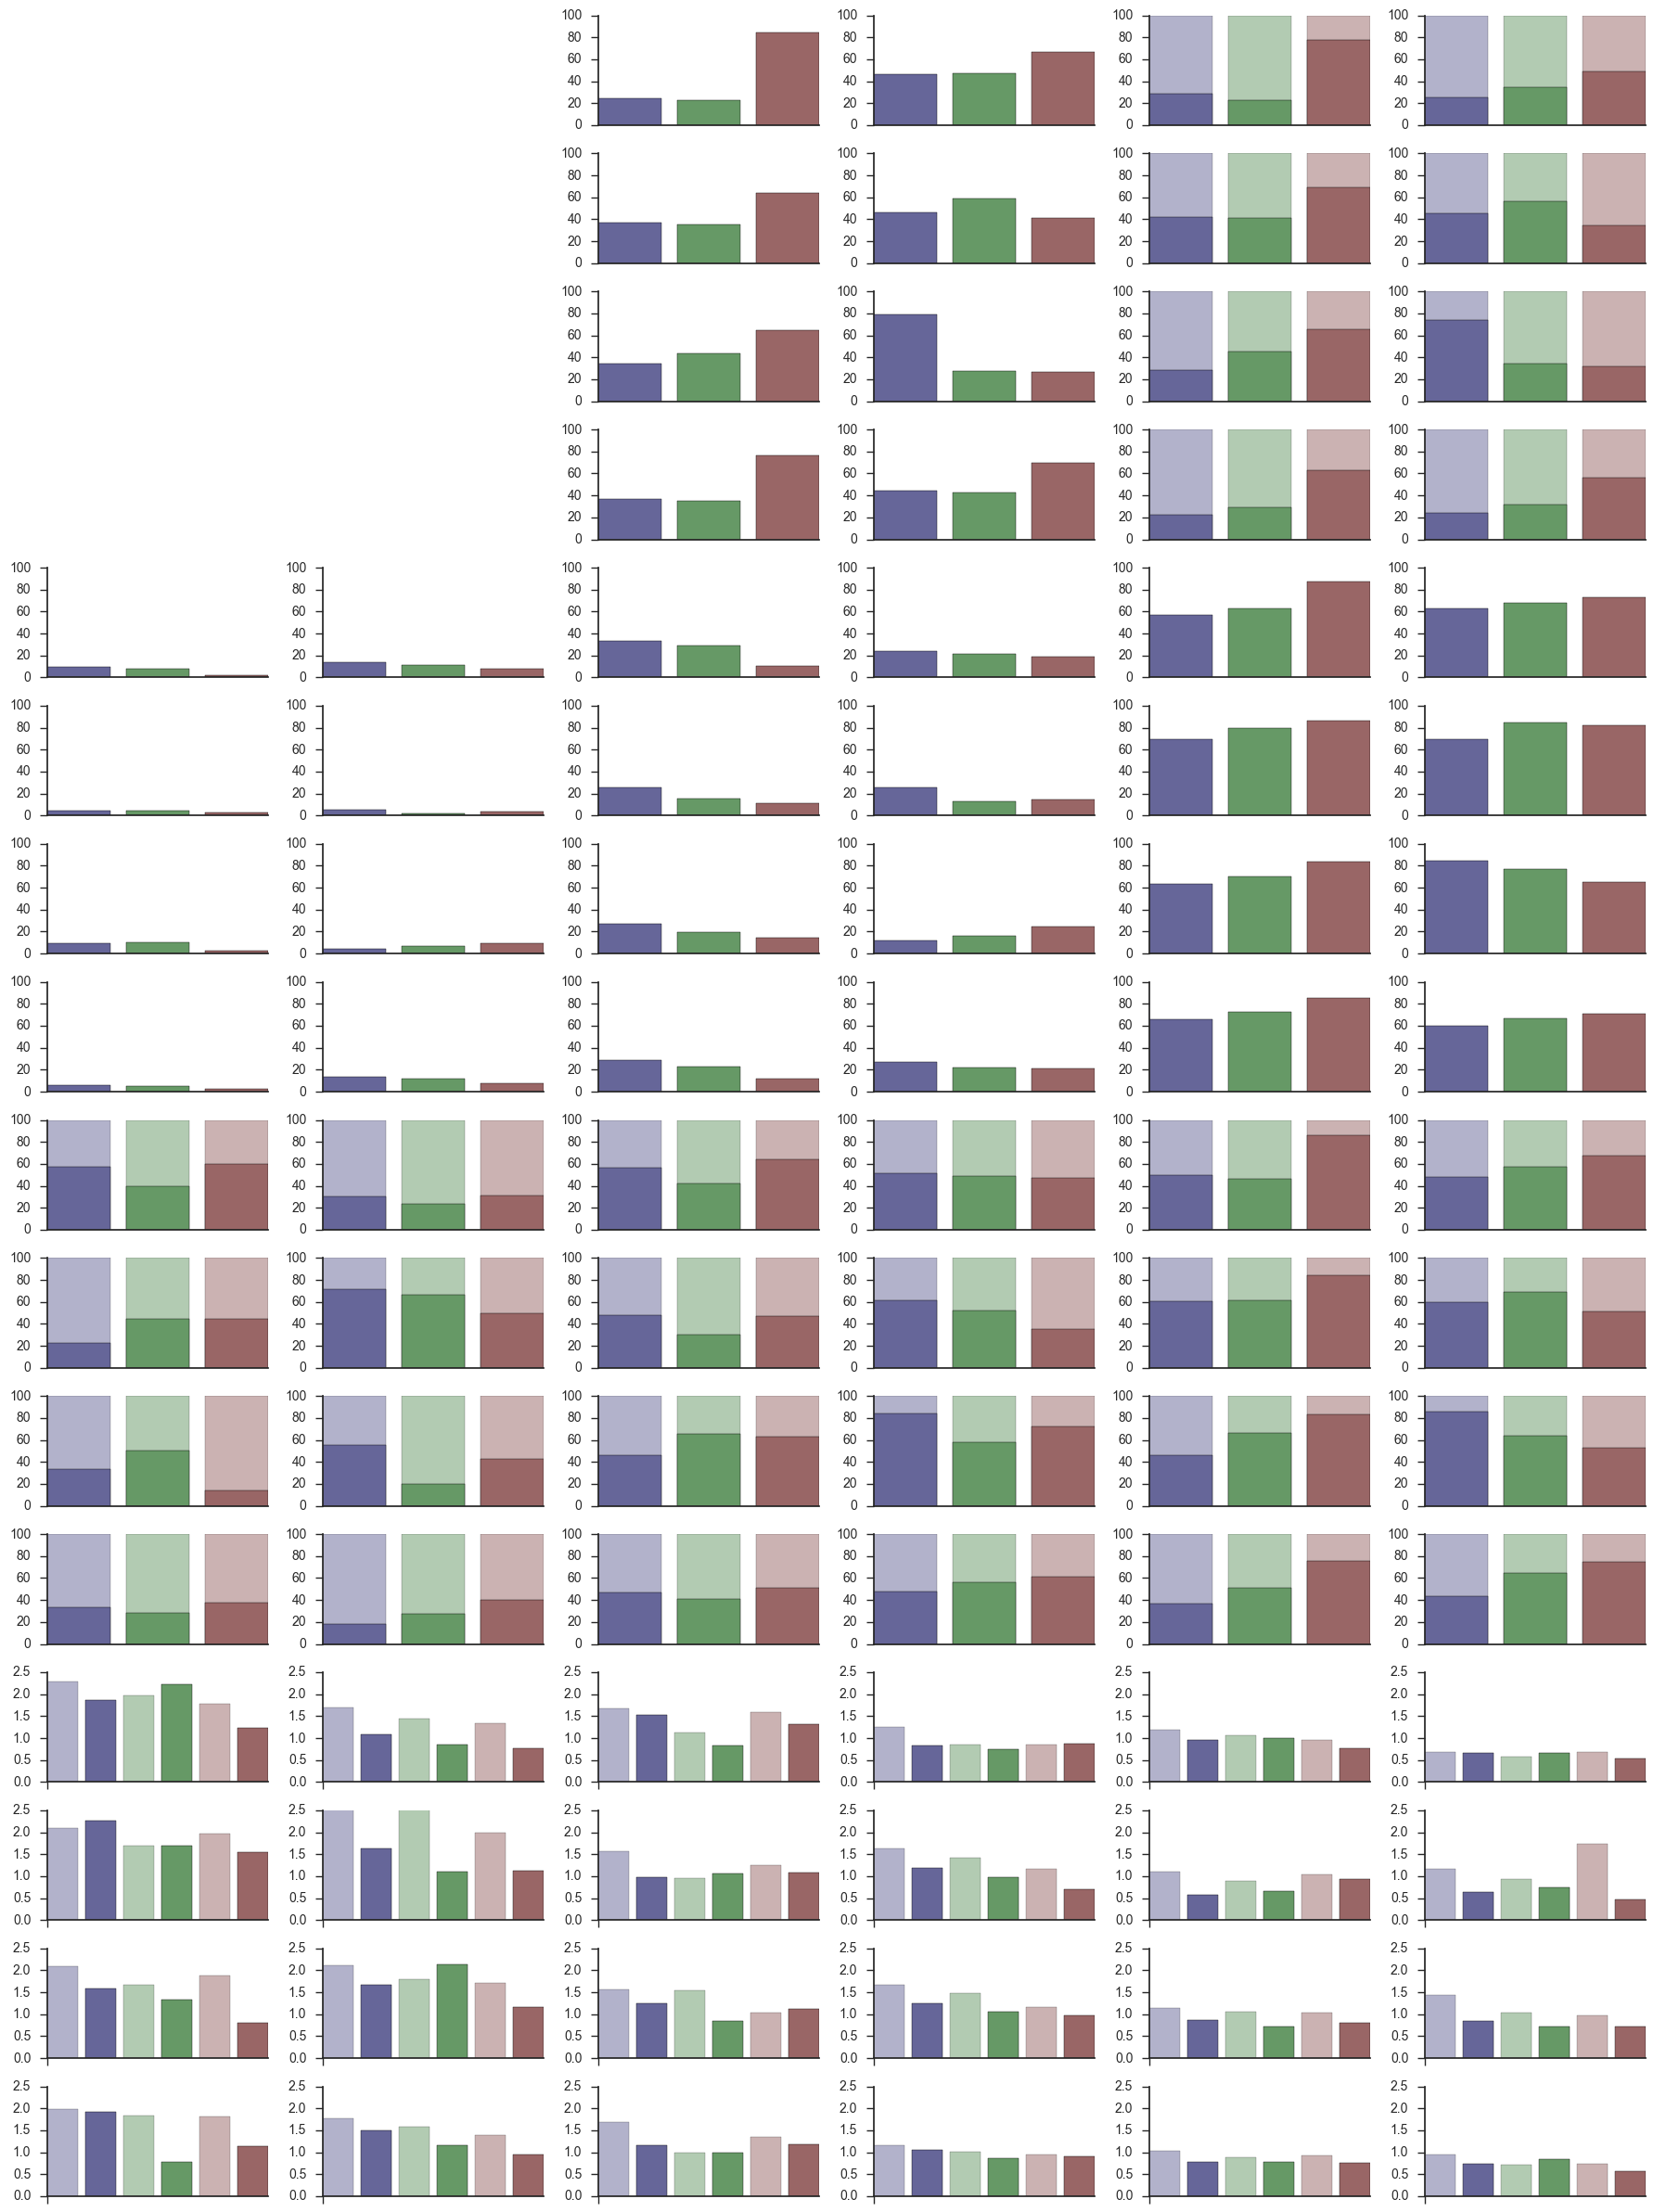

In [21]:
#### supplemental figure 8
import copy
grouplabeldef=['Medicated','non Medicated','female','male','avanto','sonata','with comorbidity','without comorb']
indicesgroup=[1,0,'F','M',1,0,1,0]

groupdefinition=[[MediADHD,1,1],[MediADHD,1,1],[genderADHD,genderSibADHD,genderCONTROL],[genderADHD,genderSibADHD,genderCONTROL],[locADHD,locSibADHD,locCONTROL],[locADHD,locSibADHD,locCONTROL],[comorbADHD,1,1],[comorbADHD,1,1]]
plotindex=[1,2,7,8,13,14,19,20]
plt.figure(figsize(18,24))
sns.set(style="ticks")
colorbar=[(153/255.,102/255.,102/255.),(102/255.,153/255.,102/255.),(102/255.,102/255.,153/255.)]
colorgroup=np.array([(0,204,0,200),(0,204,204,255),(255,0,0,200),(255,102,178,200),(204,0,204,200),(178,102,255,200),(0,0,255,200)])/255.
def sharedunique(overall):
    tot=np.float(np.sum(np.sign(np.sum(overall,0))))
    overall=np.array([np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]*overall[2])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]-np.sign(overall[1]+overall[2])*overall[0]),np.sum(overall[0]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[1]-np.sign(overall[0]+overall[2])*overall[1]),np.sum(overall[2]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[2]-np.sign(overall[1]+overall[0])*overall[2])])
    #percentage shared with other group
    shared=[overall[0]+overall[1]+overall[3],overall[0]+overall[3]+overall[5],overall[0]+overall[1]+overall[5]]
    overall2=np.array([(shared[0]+overall[2]),(shared[1]+overall[4]),(shared[2]+overall[6])])
    shared=np.array([shared[0]/(shared[0]+overall[2]),shared[1]/(shared[1]+overall[4]),shared[2]/(shared[2]+overall[6])])
    
    return overall2,shared,tot

def potencysharedunique(overall,meanprov,selecprov):
    overall=np.array([[overall[0]-np.sign(overall[0]*overall[1]+overall[0]*overall[2]),(overall[0]*overall[1]+overall[0]*overall[2])],[overall[1]-np.sign(overall[0]*overall[1]+overall[1]*overall[2]),(overall[0]*overall[1]+overall[1]*overall[2])],[overall[2]-np.sign(overall[2]*overall[1]+overall[0]*overall[2]),(overall[2]*overall[1]+overall[0]*overall[2])]])
    return [[np.mean([np.sum(np.abs(meanprov[t][i])*np.sign(overall[i][j]*selecprov[i][t]))/np.sum(np.sign(overall[i][j]*selecprov[i][t])) for t in range(3) if np.sum(np.sign(overall[i][j]*selecprov[i][t]))!=0]) for j in range(2)] for i in range(3)]#np.sqrt(len(tot[i][t+1]))
    
for e,gr in enumerate(grouplabeldef):
    meanprov=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
    meanprovN=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
    selecprov=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
    meanprov_all=np.zeros((3,len(np.triu_indices(number,1)[0])))
    selecprov_all=np.zeros((3,len(np.triu_indices(number,1)[0])))
    for t in range(1,len(NeuroIMAGE)):
        provth=[[] for g in range(3)]
        for diag,mat in enumerate([UpmatricesADHD,UpmatricesSibADHD,UpmatricesCONTROL]):
            #group definition
            #average group potency
            if e==0 or e==1 or e==6 or e==7:
                if diag==0:
                    lengroup=len(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]])
                    meanprov[diag,t-1]=np.mean(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]]*np.sqrt(lengroup),0)[np.triu_indices(number,1)]
                    meanprovN[diag,t-1]=np.mean(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]],0)[np.triu_indices(number,1)]
                    #meanprov[diag,t-1]=meanprovN[diag,t-1]
                else:
                    meanprov[diag,t-1]=np.mean(np.array(mat[t])*np.sqrt(len(mat[t])),0)[np.triu_indices(number,1)]
                    meanprovN[diag,t-1]=np.mean(np.array(mat[t]),0)[np.triu_indices(number,1)]
                    #meanprov[diag,t-1]=meanprovN[diag,t-1]
            else:
                lengroup=len(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]])
                meanprov[diag,t-1]=np.mean(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]]*np.sqrt(lengroup),0)[np.triu_indices(number,1)]
                meanprovN[diag,t-1]=np.mean(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]],0)[np.triu_indices(number,1)]
                #meanprov[diag,t-1]=meanprovN[diag,t-1]
            prov=selectionMM(meanprov[diag,t-1])
            provth[diag]=[prov[1],prov[2]]
        ###new
        #if e==0 or e==1 or e==6 or e==7:
        #    lengroup=len(np.concatenate([np.array(UpmatricesADHD[t])[np.where(np.array(groupdefinition[e][0][t])==indicesgroup[e])[0]],np.array(UpmatricesSibADHD[t]),np.array(UpmatricesCONTROL[t])],0))
        #    meanprov_all[t-1]=np.mean(np.concatenate([np.array(UpmatricesADHD[t])[np.where(np.array(groupdefinition[e][0][t])==indicesgroup[e])[0]],np.array(UpmatricesSibADHD[t]),np.array(UpmatricesCONTROL[t])],0)*np.sqrt(lengroup),0)[np.triu_indices(number,1)]
            
        #else:
        #    lengroup=len(np.concatenate([np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]] for diag,mat in enumerate([UpmatricesADHD,UpmatricesSibADHD,UpmatricesCONTROL])],0))
        #    meanprov_all[t-1]=np.mean(np.concatenate([np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]] for diag,mat in enumerate([UpmatricesADHD,UpmatricesSibADHD,UpmatricesCONTROL])],0)*np.sqrt(lengroup),0)[np.triu_indices(number,1)]
            
            
            #MMthresholding
        #prov=selectionMM(meanprov_all[t-1])        
        #prov3=np.zeros(len(np.triu_indices(number,1)[0]))
        #prov3[prov[0]]=1
    
        #selecprov_all[t-1]=copy.deepcopy(prov3)
        provth=[np.min([provth[i][0] for i in range(3)]), np.max([provth[i][1] for i in range(3)])]
        for diag in range(3):
            provbis=np.zeros(len(np.triu_indices(number,1)[0]))
            #selecprov[diag,t-1]=-1*selecprov[diag,t-1]
            provbis[np.where(meanprov[diag,t-1]<=provth[0])]=1
            provbis[np.where(meanprov[diag,t-1]>=provth[1])]=1
            
            selecprov[diag,t-1]=copy.deepcopy(provbis)
        
    #percentage overall three task per group
    overall=np.sign(np.sum(selecprov,1))#########################
    venn0=np.array([np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]*overall[2])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]-np.sign(overall[1]+overall[2])*overall[0]),np.sum(overall[0]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[1]-np.sign(overall[0]+overall[2])*overall[1]),np.sum(overall[2]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[2]-np.sign(overall[1]+overall[0])*overall[2])])
    overall2,shared,tot=sharedunique(overall)
    
    #percentage common unsp spe
    overallspe=np.sum(selecprov,1)##########################
    overallcom=copy.deepcopy(overallspe)
    overallcom[np.where(overallcom!=3)]=0
    overallcom=np.sign(overallcom)
    overallunspe=copy.deepcopy(overallspe)
    overallunspe[np.where(overallunspe!=2)]=0
    overallunspe=np.sign(overallunspe)
    overallspe[np.where(overallspe!=1)]=0
    overallspe=np.sign(overallspe)
    overallspe2,sharedspe,totspe=sharedunique(overallspe)
    overallunspe2,sharedunspe,totunspe=sharedunique(overallunspe)
    overallcom2,sharedcom,totcom=sharedunique(overallcom)
    
    venn0=venn0/tot
    print grouplabeldef[e],venn0
    plt.subplot(16,6,2+plotindex[e])
    plt.ylim([0,100])
    plot1=overall2/tot
    plt.xticks([0],[''])
    plt.bar([3,2,1],plot1*100,color=colorbar)
    plt.subplot(16,6,4+plotindex[e])
    plt.ylim([0,100])
    plot2=shared
    plt.xticks([0],[''])
    plt.bar([3,2,1],[100,100,100],color=colorbar,alpha=0.5)
    plt.bar([3,2,1],100*(1-plot2),color=colorbar)
    plt.subplot(16,6,24+plotindex[e])
    plt.ylim([0,100])
    plot3=overallcom2/overall2
    plt.xticks([0],[''])
    plt.bar([3,2,1],plot3*100,color=colorbar)
    plt.subplot(16,6,26+plotindex[e])
    plt.ylim([0,100])
    plot4=overallunspe2/overall2
    plt.xticks([0],[''])
    plt.bar([3,2,1],plot4*100,color=colorbar)
    plt.subplot(16,6,28+plotindex[e])
    plot5=overallspe2/overall2
    plt.xticks([0],[''])
    plt.ylim([0,100])
    plt.bar([3,2,1],plot5*100,color=colorbar)
    plt.subplot(16,6,48+plotindex[e])
    plt.ylim([0,100])
    plot6=sharedcom
    plt.xticks([0],[''])
    plt.bar([3,2,1],[100,100,100],color=colorbar,alpha=0.5)
    plt.bar([3,2,1],100-plot6*100,color=colorbar)
    plt.subplot(16,6,50+plotindex[e])
    plt.ylim([0,100])
    plot7=sharedunspe
    plt.xticks([0],[''])
    plt.bar([3,2,1],[100,100,100],color=colorbar,alpha=0.5)
    plt.bar([3,2,1],100-plot7*100,color=colorbar)
    plt.subplot(16,6,52+plotindex[e])
    plt.ylim([0,100])
    plot8=sharedspe
    plt.xticks([0],[''])
    plt.bar([3,2,1],[100,100,100],color=colorbar,alpha=0.5)
    plt.bar([3,2,1],100-plot8*100,color=colorbar)
    plt.subplot(16,6,72+plotindex[e])
    plt.xticks([0],[''])
    plot9=potencysharedunique(overallcom,meanprovN,selecprov)
    plot9=np.array(plot9)
    plot9[np.where(np.isnan(plot9))]=0.
    plt.ylim([0,2.5])
    for diag in range(3):
        for us in range(2):
            plt.bar([2*(2-diag)+us],plot9[diag][1-us],color=colorbar[diag],alpha=0.5+0.5*us)
    plt.subplot(16,6,74+plotindex[e])
    plot10=potencysharedunique(overallunspe,meanprovN,selecprov)
    plot10=np.array(plot10)
    plot10[np.where(np.isnan(plot10))]=0.
    plt.ylim([0,2.5])
    plt.xticks([0],[''])
    for diag in range(3):
        for us in range(2):
            plt.bar([2*(2-diag)+us],plot10[diag][1-us],color=colorbar[diag],alpha=0.5+0.5*us)
    plt.subplot(16,6,76+plotindex[e])
    plot11=potencysharedunique(overallspe,meanprovN,selecprov)
    plot11=np.array(plot11)
    plot11[np.where(np.isnan(plot11))]=0.
    plt.ylim([0,2.5])
    plt.xticks([0],[''])
    for diag in range(3):
        for us in range(2):
            plt.bar([2*(2-diag)+us],plot11[diag][1-us],color=colorbar[diag],alpha=0.5+0.5*us)
    #percentage of each shared or unique
    #average potency in fingerprint of shared and unique
    print grouplabeldef[e],plot1,plot2,plot3,plot4,plot5,plot6,plot7,plot8,plot9,plot10,plot11
    
sns.despine()
plt.tight_layout()
plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/barconfoundeffect29avril.pdf')

plt.show()

[ 0.16809605  0.06003431  0.20411664  0.05660377  0.18867925  0.06003431
  0.26243568]
[ 0.48885077  0.47341338  0.55060034] [ 0.58245614  0.60144928  0.52336449] [ 0.07017544  0.07246377  0.08722741] [ 0.17894737  0.16666667  0.20872274] [ 0.75087719  0.76086957  0.70404984] [ 0.7  0.5  0.5] [ 0.60784314  0.54347826  0.37313433] [ 0.36915888  0.38095238  0.31858407] [[ 0.91934597  1.58987731]
 [ 1.06267718  1.71120467]
 [ 1.30668951  1.80212192]] [[ 0.92089871  0.8679515 ]
 [ 0.95735774  0.86249341]
 [ 0.85634844  1.22980566]] [[ 0.61025515  0.69610303]
 [ 0.69266145  0.66258456]
 [ 0.57136808  0.78305986]]


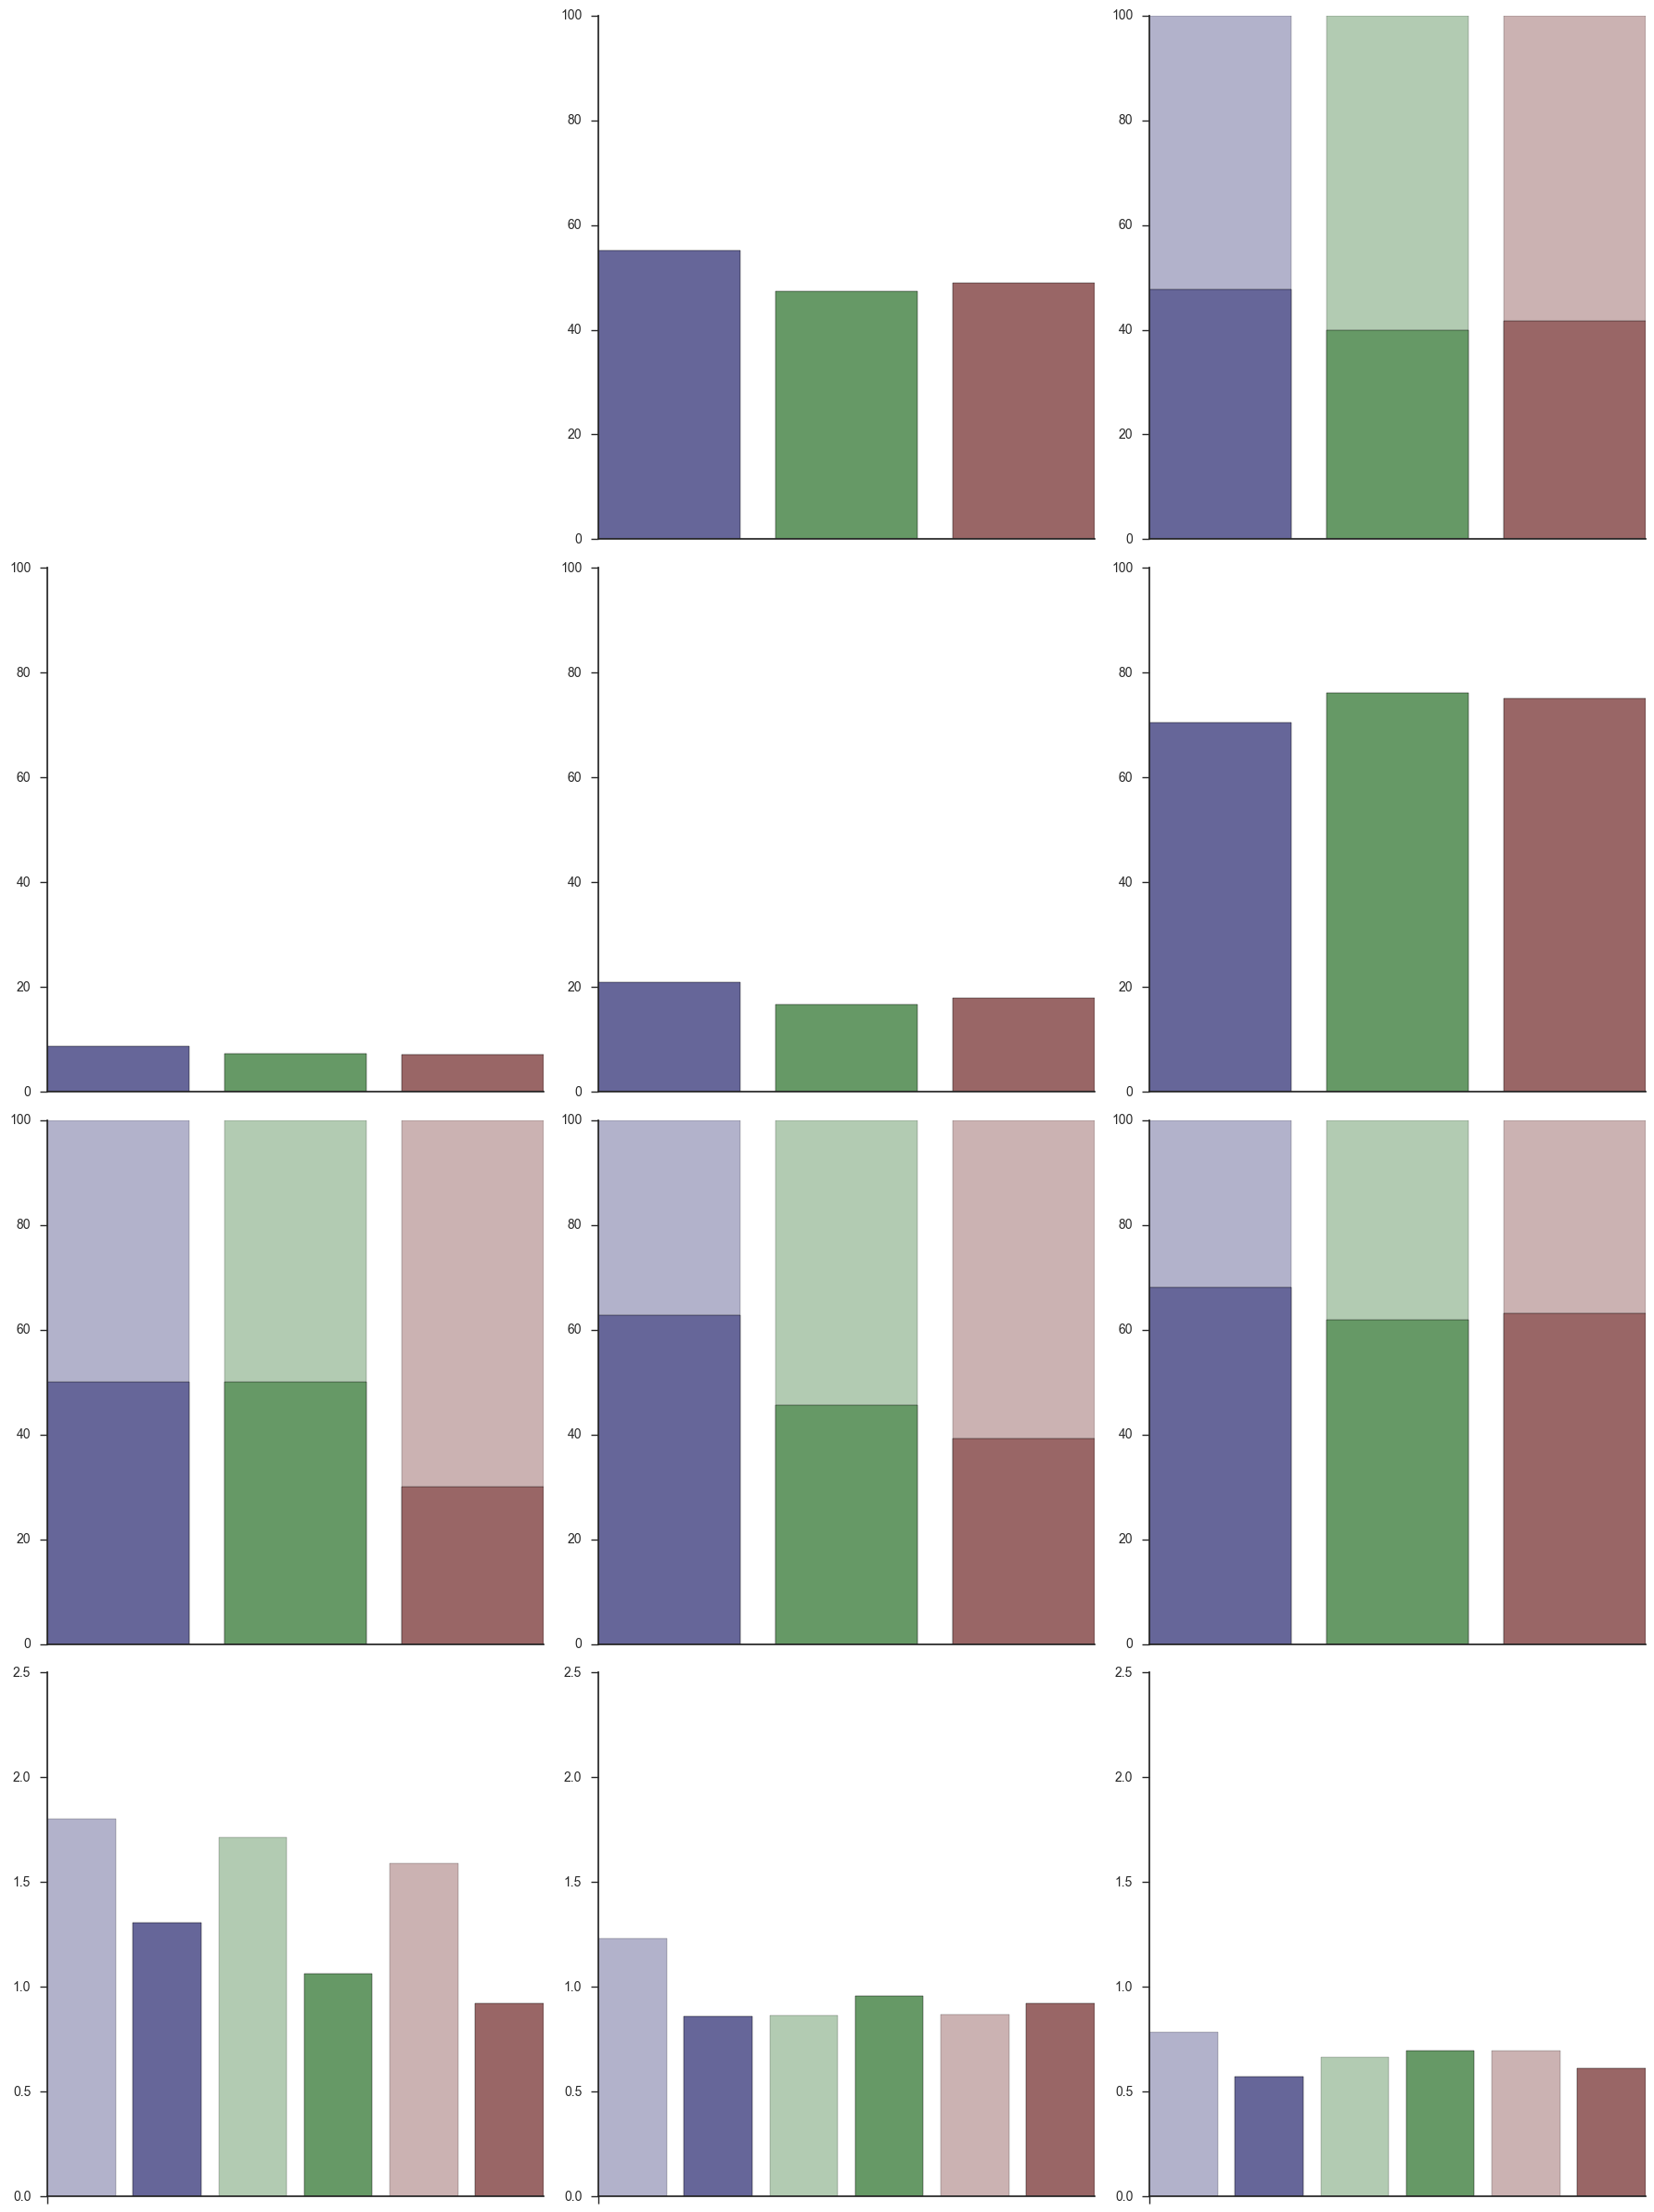

In [114]:
#### matching : supplemental figure 9
import copy

plotindex=[1,2,7,8,13,14,19,20]
plt.figure(figsize(18,24))
sns.set(style="ticks")
colorbar=[(153/255.,102/255.,102/255.),(102/255.,153/255.,102/255.),(102/255.,102/255.,153/255.)]
colorgroup=np.array([(0,204,0,200),(0,204,204,255),(255,0,0,200),(255,102,178,200),(204,0,204,200),(178,102,255,200),(0,0,255,200)])/255.
def sharedunique(overall):
    tot=np.float(np.sum(np.sign(np.sum(overall,0))))
    overall=np.array([np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]*overall[2])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]-np.sign(overall[1]+overall[2])*overall[0]),np.sum(overall[0]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[1]-np.sign(overall[0]+overall[2])*overall[1]),np.sum(overall[2]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[2]-np.sign(overall[1]+overall[0])*overall[2])])
    #percentage shared with other group
    shared=[overall[0]+overall[1]+overall[3],overall[0]+overall[3]+overall[5],overall[0]+overall[1]+overall[5]]
    overall2=np.array([(shared[0]+overall[2]),(shared[1]+overall[4]),(shared[2]+overall[6])])
    shared=np.array([shared[0]/(shared[0]+overall[2]),shared[1]/(shared[1]+overall[4]),shared[2]/(shared[2]+overall[6])])
    
    return overall2,shared,tot

def potencysharedunique(overall,meanprov,selecprov):
    overall=np.array([[overall[0]-np.sign(overall[0]*overall[1]+overall[0]*overall[2]),(overall[0]*overall[1]+overall[0]*overall[2])],[overall[1]-np.sign(overall[0]*overall[1]+overall[1]*overall[2]),(overall[0]*overall[1]+overall[1]*overall[2])],[overall[2]-np.sign(overall[2]*overall[1]+overall[0]*overall[2]),(overall[2]*overall[1]+overall[0]*overall[2])]])
    return [[np.mean([np.sum(np.abs(meanprov[t][i])*np.sign(overall[i][j]*selecprov[i][t]))/np.sum(np.sign(overall[i][j]*selecprov[i][t])) for t in range(3) if np.sum(np.sign(overall[i][j]*selecprov[i][t]))!=0]) for j in range(2)] for i in range(3)]#np.sqrt(len(tot[i][t+1]))
    
meanprov=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
meanprovN=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
selecprov=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
meanprov_all=np.zeros((3,len(np.triu_indices(number,1)[0])))
selecprov_all=np.zeros((3,len(np.triu_indices(number,1)[0])))
for t in range(1,len(NeuroIMAGE)):
    provth=[[] for g in range(3)]
    for diag,mat in enumerate([UpmatricesADHD,UpmatricesSibADHD,UpmatricesCONTROL]):
        meanprov[diag,t-1]=np.mean(np.array(mat[t])*np.sqrt(len(mat[t])),0)[np.triu_indices(number,1)]
        meanprovN[diag,t-1]=np.mean(np.array(mat[t]),0)[np.triu_indices(number,1)]
        prov=selectionMM(meanprov[diag,t-1])
        provth[diag]=[prov[1],prov[2]]
        
    provth=[np.min([provth[i][0] for i in range(3)]), np.max([provth[i][1] for i in range(3)])]
    for diag in range(3):
        provbis=np.zeros(len(np.triu_indices(number,1)[0]))
            #selecprov[diag,t-1]=-1*selecprov[diag,t-1]
        provbis[np.where(meanprov[diag,t-1]<=provth[0])]=1
        provbis[np.where(meanprov[diag,t-1]>=provth[1])]=1
            
        selecprov[diag,t-1]=copy.deepcopy(provbis)
        
    #percentage overall three task per group
overall=np.sign(np.sum(selecprov,1))#########################
venn0=np.array([np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]*overall[2])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]-np.sign(overall[1]+overall[2])*overall[0]),np.sum(overall[0]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[1]-np.sign(overall[0]+overall[2])*overall[1]),np.sum(overall[2]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[2]-np.sign(overall[1]+overall[0])*overall[2])])
overall2,shared,tot=sharedunique(overall)
    
    #percentage common unsp spe
overallspe=np.sum(selecprov,1)##########################
overallcom=copy.deepcopy(overallspe)
overallcom[np.where(overallcom!=3)]=0
overallcom=np.sign(overallcom)
overallunspe=copy.deepcopy(overallspe)
overallunspe[np.where(overallunspe!=2)]=0
overallunspe=np.sign(overallunspe)
overallspe[np.where(overallspe!=1)]=0
overallspe=np.sign(overallspe)
overallspe2,sharedspe,totspe=sharedunique(overallspe)
overallunspe2,sharedunspe,totunspe=sharedunique(overallunspe)
overallcom2,sharedcom,totcom=sharedunique(overallcom)
    
venn0=venn0/tot
print venn0
plt.subplot(4,3,2)
plt.ylim([0,100])
plot1=overall2/tot
plt.xticks([0],[''])
plt.bar([3,2,1],plot1*100,color=colorbar)
plt.subplot(4,3,3)
plt.ylim([0,100])
plot2=shared
plt.xticks([0],[''])
plt.bar([3,2,1],[100,100,100],color=colorbar,alpha=0.5)
plt.bar([3,2,1],100*(1-plot2),color=colorbar)
plt.subplot(4,3,4)
plt.ylim([0,100])
plot3=overallcom2/overall2
plt.xticks([0],[''])
plt.bar([3,2,1],plot3*100,color=colorbar)
plt.subplot(4,3,5)
plt.ylim([0,100])
plot4=overallunspe2/overall2
plt.xticks([0],[''])
plt.bar([3,2,1],plot4*100,color=colorbar)
plt.subplot(4,3,6)
plot5=overallspe2/overall2
plt.xticks([0],[''])
plt.ylim([0,100])
plt.bar([3,2,1],plot5*100,color=colorbar)
plt.subplot(4,3,7)
plt.ylim([0,100])
plot6=sharedcom
plt.xticks([0],[''])
plt.bar([3,2,1],[100,100,100],color=colorbar,alpha=0.5)
plt.bar([3,2,1],100-plot6*100,color=colorbar)
plt.subplot(4,3,8)
plt.ylim([0,100])
plot7=sharedunspe
plt.xticks([0],[''])
plt.bar([3,2,1],[100,100,100],color=colorbar,alpha=0.5)
plt.bar([3,2,1],100-plot7*100,color=colorbar)
plt.subplot(4,3,9)
plt.ylim([0,100])
plot8=sharedspe
plt.xticks([0],[''])
plt.bar([3,2,1],[100,100,100],color=colorbar,alpha=0.5)
plt.bar([3,2,1],100-plot8*100,color=colorbar)
plt.subplot(4,3,10)
plt.xticks([0],[''])
plot9=potencysharedunique(overallcom,meanprovN,selecprov)
plot9=np.array(plot9)
plot9[np.where(np.isnan(plot9))]=0.
plt.ylim([0,2.5])
for diag in range(3):
    for us in range(2):
        plt.bar([2*(2-diag)+us],plot9[diag][1-us],color=colorbar[diag],alpha=0.5+0.5*us)
plt.subplot(4,3,11)
plot10=potencysharedunique(overallunspe,meanprovN,selecprov)
plot10=np.array(plot10)
plot10[np.where(np.isnan(plot10))]=0.
plt.ylim([0,2.5])
plt.xticks([0],[''])
for diag in range(3):
    for us in range(2):
        plt.bar([2*(2-diag)+us],plot10[diag][1-us],color=colorbar[diag],alpha=0.5+0.5*us)
plt.subplot(4,3,12)
plot11=potencysharedunique(overallspe,meanprovN,selecprov)
plot11=np.array(plot11)
plot11[np.where(np.isnan(plot11))]=0.
plt.ylim([0,2.5])
plt.xticks([0],[''])
for diag in range(3):
    for us in range(2):
        plt.bar([2*(2-diag)+us],plot11[diag][1-us],color=colorbar[diag],alpha=0.5+0.5*us)
    #percentage of each shared or unique
    #average potency in fingerprint of shared and unique
print plot1,plot2,plot3,plot4,plot5,plot6,plot7,plot8,plot9,plot10,plot11
    
sns.despine()
plt.tight_layout()
plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/matchingBar.pdf')

plt.show()

In [117]:
##paper
def venndia2(titre,prov,colorgroup=np.array([(0,204,0,200),(0,204,204,255),(255,0,0,200),(255,102,178,200),(204,0,204,200),(178,102,255,200),(0,0,255,200)])/255.,labeldatasens=['STOP task','REWARD task','WM task'],labeldataspecom=['STOP task','REWARD task','WM task','all tasks'],subtitle=['sensitive','task representation'],grouplabel=['all group','ADHD & Control','ADHD','ADHD & ADHD Siblings','ADHD Siblings','ADHD Siblings & Control','Control']):
    
    #data shape [[percentage],[percentage per task 3*ngroup]]
    #colordata same shape than data
    sys.path.append('pathtoscripts')
    from matplotlib_venn import venn3
    locgroup=['111','101','100','110','010','011','001']
    plt.figure(figsize=(10,5))
    order=[2,4,3,6,1,5,0]
    
    
    
    #legend
    #plt.subplot2grid((16,4), (0,0),colspan=1,rowspan=8)
    
    
        
        
    v=venn3(subsets=prov[order],set_labels=('','',''))#,set_labels=('Adhd','Sibling','Control'))
        
    for i in order:
        v.get_patch_by_id(locgroup[i]).set_color(colorgroup[i])
        
    plt.tight_layout()

Medicated [ 0.11596386  0.01656627  0.09638554  0.01957831  0.21837349  0.19427711
  0.33885542]


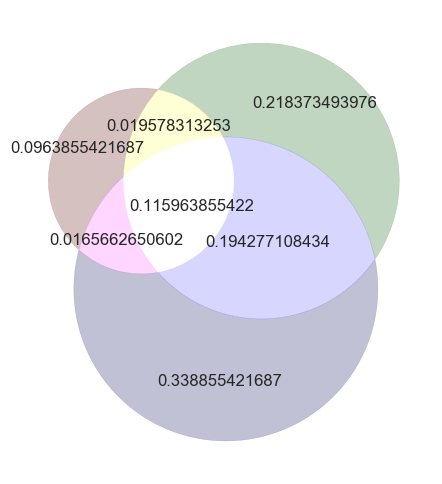

non Medicated [ 0.20221607  0.06094183  0.15789474  0.03185596  0.18836565  0.08725762
  0.27146814]


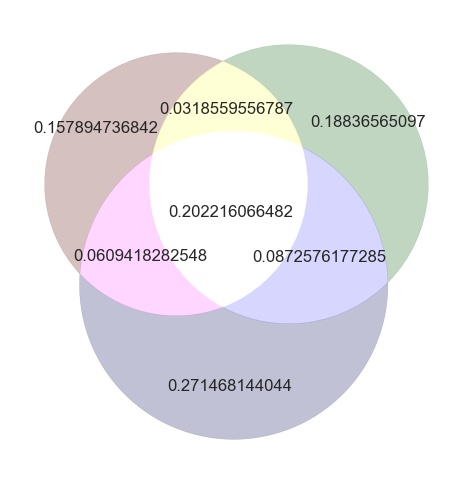

female [ 0.13625304  0.0486618   0.14111922  0.02189781  0.25790754  0.11678832
  0.27737226]


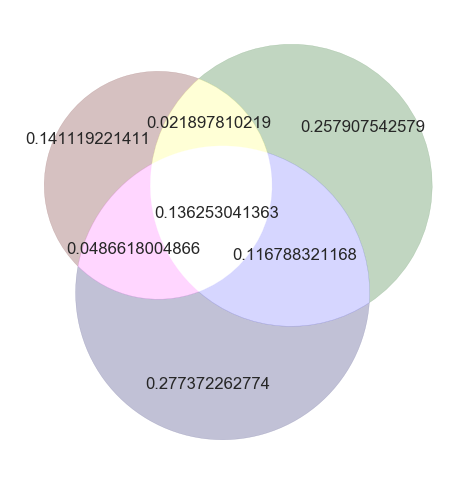

male [ 0.14460784  0.10784314  0.32598039  0.04166667  0.14705882  0.02205882
  0.21078431]


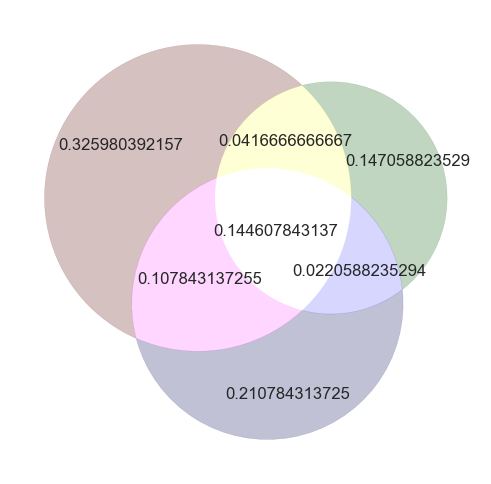

avanto [ 0.15555556  0.07333333  0.12222222  0.00888889  0.16666667  0.12
  0.35333333]


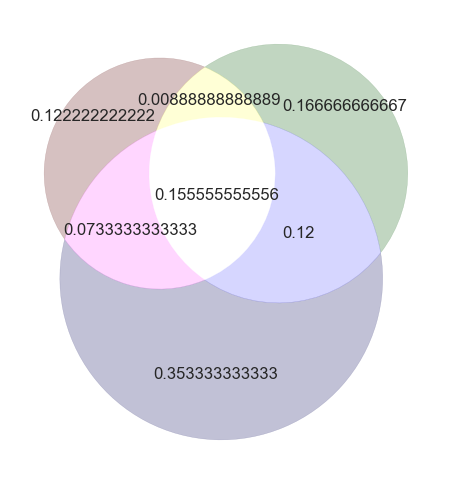

sonata [ 0.12121212  0.04242424  0.36666667  0.08181818  0.20606061  0.03636364
  0.14545455]


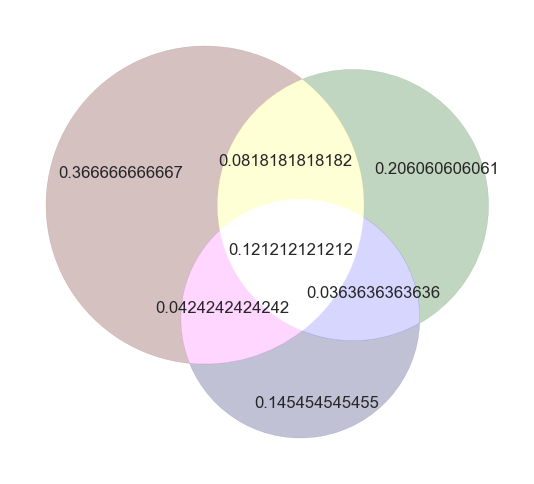

with comorbidity [ 0.16374269  0.04824561  0.14035088  0.02631579  0.19736842  0.13011696
  0.29385965]


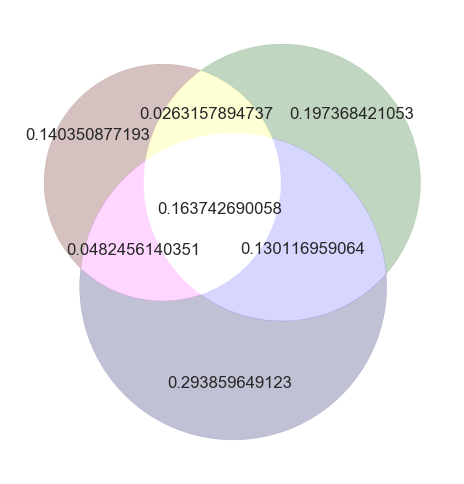

without comorb [ 0.15647226  0.03698435  0.12517781  0.01849218  0.21337127  0.14224751
  0.30725462]


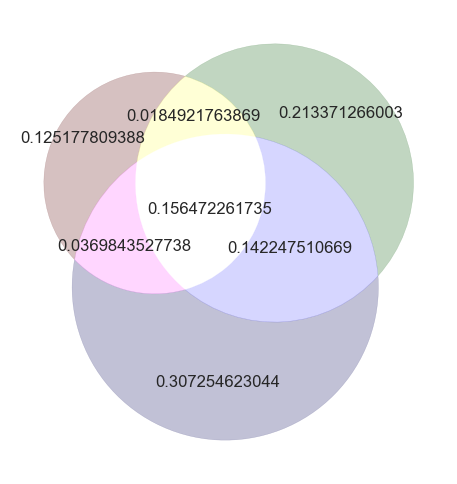

In [41]:
#### supplemental figure 8, venn diagram
grouplabeldef=['Medicated','non Medicated','female','male','avanto','sonata','with comorbidity','without comorb']
indicesgroup=[1,0,'F','M',1,0,1,0]
groupdefinition=[[MediADHD,1,1],[MediADHD,1,1],[genderADHD,genderSibADHD,genderCONTROL],[genderADHD,genderSibADHD,genderCONTROL],[locADHD,locSibADHD,locCONTROL],[locADHD,locSibADHD,locCONTROL],[comorbADHD,1,1],[comorbADHD,1,1]]
plotindex=[1,2,7,8,13,14]
plt.figure(figsize(18,24))
sns.set(style="ticks")
colorbar=[(153/255.,102/255.,102/255.),(102/255.,153/255.,102/255.),(102/255.,102/255.,153/255.)]
colorgroup=np.array([(255/255.,255/255.,255/255.),(255/255.,153/255.,255/255.),(153/255.,102/255.,102/255.),(255/255.,255/255.,153/255.),(102/255.,153/255.,102/255.),(153/255.,153/255.,255/255.),(102/255.,102/255.,153/255.)])
                     
def sharedunique(overall):
    tot=np.float(np.sum(np.sign(np.sum(overall,0))))
    overall=np.array([np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]*overall[2])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]-np.sign(overall[1]+overall[2])*overall[0]),np.sum(overall[0]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[1]-np.sign(overall[0]+overall[2])*overall[1]),np.sum(overall[2]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[2]-np.sign(overall[1]+overall[0])*overall[2])])
    #percentage shared with other group
    shared=[overall[0]+overall[1]+overall[3],overall[0]+overall[3]+overall[5],overall[0]+overall[1]+overall[5]]
    overall2=np.array([(shared[0]+overall[2]),(shared[1]+overall[4]),(shared[2]+overall[6])])
    shared=np.array([shared[0]/(shared[0]+overall[2]),shared[1]/(shared[1]+overall[4]),shared[2]/(shared[2]+overall[6])])
    
    return overall2,shared,tot

def potencysharedunique(overall,meanprov,selecprov):
    overall=np.array([[overall[0]-np.sign(overall[0]*overall[1]+overall[0]*overall[2]),(overall[0]*overall[1]+overall[0]*overall[2])],[overall[1]-np.sign(overall[0]*overall[1]+overall[1]*overall[2]),(overall[0]*overall[1]+overall[1]*overall[2])],[overall[2]-np.sign(overall[2]*overall[1]+overall[0]*overall[2]),(overall[2]*overall[1]+overall[0]*overall[2])]])
    return [[np.mean([np.sum(np.abs(meanprov[t][i])*np.sign(overall[i][j]*selecprov[i][t]))/np.sum(np.sign(overall[i][j]*selecprov[i][t])) for t in range(3) if np.sum(np.sign(overall[i][j]*selecprov[i][t]))!=0]) for j in range(2)] for i in range(3)]#np.sqrt(len(tot[i][t+1]))
    
for e,gr in enumerate(grouplabeldef):
    meanprov=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
    meanprovN=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
    selecprov=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
    meanprov_all=np.zeros((3,len(np.triu_indices(number,1)[0])))
    selecprov_all=np.zeros((3,len(np.triu_indices(number,1)[0])))
    for t in range(1,len(NeuroIMAGE)):
        provth=[[] for g in range(3)]
        for diag,mat in enumerate([UpmatricesADHD,UpmatricesSibADHD,UpmatricesCONTROL]):
            #group definition
            #average group potency
            if e==0 or e==1 or e==6 or e==7:
                if diag==0:
                    lengroup=len(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]])
                    meanprov[diag,t-1]=np.mean(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]]*np.sqrt(lengroup),0)[np.triu_indices(number,1)]
                    meanprovN[diag,t-1]=np.mean(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]],0)[np.triu_indices(number,1)]
                else:
                    meanprov[diag,t-1]=np.mean(np.array(mat[t])*np.sqrt(len(mat[t])),0)[np.triu_indices(number,1)]
                    meanprovN[diag,t-1]=np.mean(np.array(mat[t]),0)[np.triu_indices(number,1)]
            else:
                lengroup=len(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]])
                meanprov[diag,t-1]=np.mean(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]]*np.sqrt(lengroup),0)[np.triu_indices(number,1)]
                meanprovN[diag,t-1]=np.mean(np.array(mat[t])[np.where(np.array(groupdefinition[e][diag][t])==indicesgroup[e])[0]],0)[np.triu_indices(number,1)]
            prov=selectionMM(meanprov[diag,t-1])
            provth[diag]=[prov[1],prov[2]]
       
        provth=[np.min([provth[i][0] for i in range(3)]), np.max([provth[i][1] for i in range(3)])]
        for diag in range(3):
            provbis=np.zeros(len(np.triu_indices(number,1)[0]))
            #selecprov[diag,t-1]=-1*selecprov[diag,t-1]
            provbis[np.where(meanprov[diag,t-1]<=provth[0])]=1
            provbis[np.where(meanprov[diag,t-1]>=provth[1])]=1
            
            selecprov[diag,t-1]=copy.deepcopy(provbis)    
    
            
    #percentage overall three task per group
    overall=np.sign(np.sum(selecprov,1))
    venn0=np.array([np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]*overall[2])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]-np.sign(overall[1]+overall[2])*overall[0]),np.sum(overall[0]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[1]-np.sign(overall[0]+overall[2])*overall[1]),np.sum(overall[2]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[2]-np.sign(overall[1]+overall[0])*overall[2])])
    overall2,shared,tot=sharedunique(overall)
    
    
    venn0=venn0/tot
    print grouplabeldef[e],venn0
    
    venndia2(grouplabeldef[e],venn0,colorgroup=colorgroup,labeldatasens=['STOP task','REWARD task','WM task'],labeldataspecom=['STOP task','REWARD task','WM task','all tasks'],subtitle=['sensitive','task representation'],grouplabel=['all group','ADHD & Control','ADHD','ADHD & ADHD Siblings','ADHD Siblings','ADHD Siblings & Control','Control'])
    plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/'+grouplabeldef[e]+'_confoundeffect29avril.pdf')

    plt.show()

[ 0.16809605  0.06003431  0.20411664  0.05660377  0.18867925  0.06003431
  0.26243568]


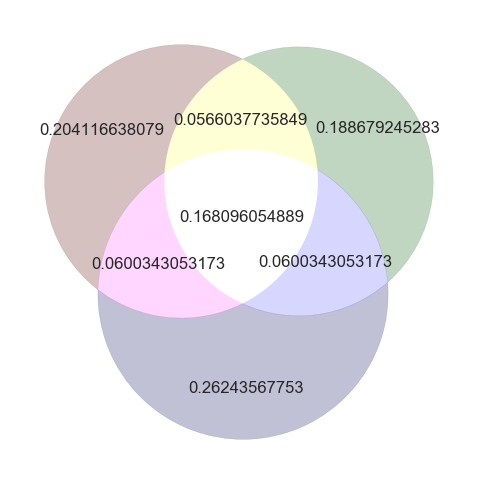

In [122]:
#### matching: supplemental figure 9 venn diagram
import copy
grouplabeldef=['Medicated','non Medicated','female','male','avanto','sonata','with comorbidity','without comorb']
indicesgroup=[1,0,'F','M',1,0,1,0]

groupdefinition=[[MediADHD,1,1],[MediADHD,1,1],[genderADHD,genderSibADHD,genderCONTROL],[genderADHD,genderSibADHD,genderCONTROL],[locADHD,locSibADHD,locCONTROL],[locADHD,locSibADHD,locCONTROL],[comorbADHD,1,1],[comorbADHD,1,1]]
plotindex=[1,2,7,8,13,14,19,20]
plt.figure(figsize(18,24))
sns.set(style="ticks")

colorbar=[(153/255.,102/255.,102/255.),(102/255.,153/255.,102/255.),(102/255.,102/255.,153/255.)]
colorgroup=np.array([(255/255.,255/255.,255/255.),(255/255.,153/255.,255/255.),(153/255.,102/255.,102/255.),(255/255.,255/255.,153/255.),(102/255.,153/255.,102/255.),(153/255.,153/255.,255/255.),(102/255.,102/255.,153/255.)])
def sharedunique(overall):
    tot=np.float(np.sum(np.sign(np.sum(overall,0))))
    overall=np.array([np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]*overall[2])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]-np.sign(overall[1]+overall[2])*overall[0]),np.sum(overall[0]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[1]-np.sign(overall[0]+overall[2])*overall[1]),np.sum(overall[2]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[2]-np.sign(overall[1]+overall[0])*overall[2])])
    #percentage shared with other group
    shared=[overall[0]+overall[1]+overall[3],overall[0]+overall[3]+overall[5],overall[0]+overall[1]+overall[5]]
    overall2=np.array([(shared[0]+overall[2]),(shared[1]+overall[4]),(shared[2]+overall[6])])
    shared=np.array([shared[0]/(shared[0]+overall[2]),shared[1]/(shared[1]+overall[4]),shared[2]/(shared[2]+overall[6])])
    
    return overall2,shared,tot

def potencysharedunique(overall,meanprov,selecprov):
    overall=np.array([[overall[0]-np.sign(overall[0]*overall[1]+overall[0]*overall[2]),(overall[0]*overall[1]+overall[0]*overall[2])],[overall[1]-np.sign(overall[0]*overall[1]+overall[1]*overall[2]),(overall[0]*overall[1]+overall[1]*overall[2])],[overall[2]-np.sign(overall[2]*overall[1]+overall[0]*overall[2]),(overall[2]*overall[1]+overall[0]*overall[2])]])
    return [[np.mean([np.sum(np.abs(meanprov[t][i])*np.sign(overall[i][j]*selecprov[i][t]))/np.sum(np.sign(overall[i][j]*selecprov[i][t])) for t in range(3) if np.sum(np.sign(overall[i][j]*selecprov[i][t]))!=0]) for j in range(2)] for i in range(3)]#np.sqrt(len(tot[i][t+1]))
    
meanprov=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
meanprovN=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
selecprov=np.zeros((3,3,len(np.triu_indices(number,1)[0])))
meanprov_all=np.zeros((3,len(np.triu_indices(number,1)[0])))
selecprov_all=np.zeros((3,len(np.triu_indices(number,1)[0])))
for t in range(1,len(NeuroIMAGE)):
    provth=[[] for g in range(3)]
    for diag,mat in enumerate([UpmatricesADHD,UpmatricesSibADHD,UpmatricesCONTROL]):
        meanprov[diag,t-1]=np.mean(np.array(mat[t])*np.sqrt(len(mat[t])),0)[np.triu_indices(number,1)]
        meanprovN[diag,t-1]=np.mean(np.array(mat[t]),0)[np.triu_indices(number,1)]
        prov=selectionMM(meanprov[diag,t-1])
        provth[diag]=[prov[1],prov[2]]
        
    provth=[np.min([provth[i][0] for i in range(3)]), np.max([provth[i][1] for i in range(3)])]
    for diag in range(3):
        provbis=np.zeros(len(np.triu_indices(number,1)[0]))
            #selecprov[diag,t-1]=-1*selecprov[diag,t-1]
        provbis[np.where(meanprov[diag,t-1]<=provth[0])]=1
        provbis[np.where(meanprov[diag,t-1]>=provth[1])]=1
            
        selecprov[diag,t-1]=copy.deepcopy(provbis)

            
    #percentage overall three task per group
overall=np.sign(np.sum(selecprov,1))
venn0=np.array([np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]*overall[2])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[0]-np.sign(overall[1]+overall[2])*overall[0]),np.sum(overall[0]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[1]-np.sign(overall[0]+overall[2])*overall[1]),np.sum(overall[2]*overall[1])-np.sum(overall[0]*overall[1]*overall[2]),np.sum(overall[2]-np.sign(overall[1]+overall[0])*overall[2])])
overall2,shared,tot=sharedunique(overall)
    
    
venn0=venn0/tot
print venn0
    
venndia2('matching',venn0,colorgroup=colorgroup,labeldatasens=['STOP task','REWARD task','WM task'],labeldataspecom=['STOP task','REWARD task','WM task','all tasks'],subtitle=['sensitive','task representation'],grouplabel=['all group','ADHD & Control','ADHD','ADHD & ADHD Siblings','ADHD Siblings','ADHD Siblings & Control','Control'])
plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/matching_venn.pdf')

plt.show()

In [31]:
def make_demofig(mytitle, sample_sex, sample_age, agehist, agebins, ymax,savetitle):
    #author: maarten mennes
    sns.set_style('white')
    sns.set_style('ticks')
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    fig = plt.figure(figsize=[16,6], dpi=300)
    
    # plot age histogram
    ax1 = fig.add_subplot(111)
    
    width = 0.6*(agebins[1]-agebins[0])
    center = (agebins[:-1]+agebins[1:])/2
    # plot bars
    ax1.bar(center, agehist, color='#f1ff19', align = 'center', width=width)
    ax1.set_xlim([0,95])
    # change ticks and spines
    ax1.set_xticks(range(0,95,10))
    ax1.tick_params('both',labelsize=18, pad=10, which='major', right='off', top='off', width=2, direction='in')
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    # add labels
    ax1.set_ylabel('N Individuals', fontdict={'fontsize':24},labelpad=12)
    ax1.set_xlabel('Age', fontdict={'fontsize':24},labelpad=12)
    #ax1.set_title('Age Distribution', fontdict={'fontsize':24})
    ax1.axhline(y=-1, linewidth=4, color ='k')
    ax1.axvline(x=0, linewidth=3, color ='k')
    ax1.set_ylim([-1, ymax])
    ax1.set_yticks(range(0,ymax+1,5))
    
    
    
    # plot pie chart in empty space histogram
    a = plt.axes([.68, .45, .15, .33], axisbg='y')
    wedges, texts, autotexts = pylab.pie([sample_sex.count(1), sample_sex.count(0)], labels=['Male', 'Female'], autopct='%1.0f%%', startangle=90, colors=['CornflowerBlue', 'Orchid'])
    wedges[0].set_lw(1)
    wedges[1].set_lw(1)
    proptease = matplotlib.font_manager.FontProperties()
    proptease.set_size('12')
    plt.setp(autotexts, fontproperties=proptease)
    proptease.set_size('14')
    plt.setp(texts, fontproperties=proptease)
    title('Sex Distribution', fontdict={'fontsize':18})
    
    
    pies = [len([x for x in sample_age if 20 < x <100]), 
            len([x for x in sample_age if 16 < x < 19.9]), 
            len([x for x in sample_age if 12 < x <15.9]), 
            len([x for x in sample_age if x <11.9])]
    pielabels = ['>20', '16-20', '12-16', '<12']
    piecolors = ['#7bb0ca','#a0c6d9','#c4dce7','#e9f2f6']
    count = 0
    mypies = []
    mypielabels = []
    mypiecolors = []
    for p in range(0,len(pies)):
        if pies[p] > 0:
            mypies.append(pies[p])
            mypielabels.append(pielabels[p])
            mypiecolors.append(piecolors[p])
    
        
    a = plt.axes([.45, .45, .15, .33], axisbg='y')        
    wedges, texts, autotexts = pylab.pie(mypies, labels=mypielabels, autopct='%1.0f%%', startangle=90, colors=mypiecolors)
    wedges[0].set_lw(1)
    wedges[1].set_lw(1)
    proptease = matplotlib.font_manager.FontProperties()
    proptease.set_size('12')
    plt.setp(autotexts, fontproperties=proptease)
    proptease.set_size('14')
    plt.setp(texts, fontproperties=proptease)
    title('Age Distribution', fontdict={'fontsize':18})
    
    # make sure full xlabel is there
    gcf().subplots_adjust(bottom=0.15)
    
    plt.suptitle(mytitle, fontdict={'fontsize':24})
    plt.savefig(savetitle)
    plt.show()
    
    return

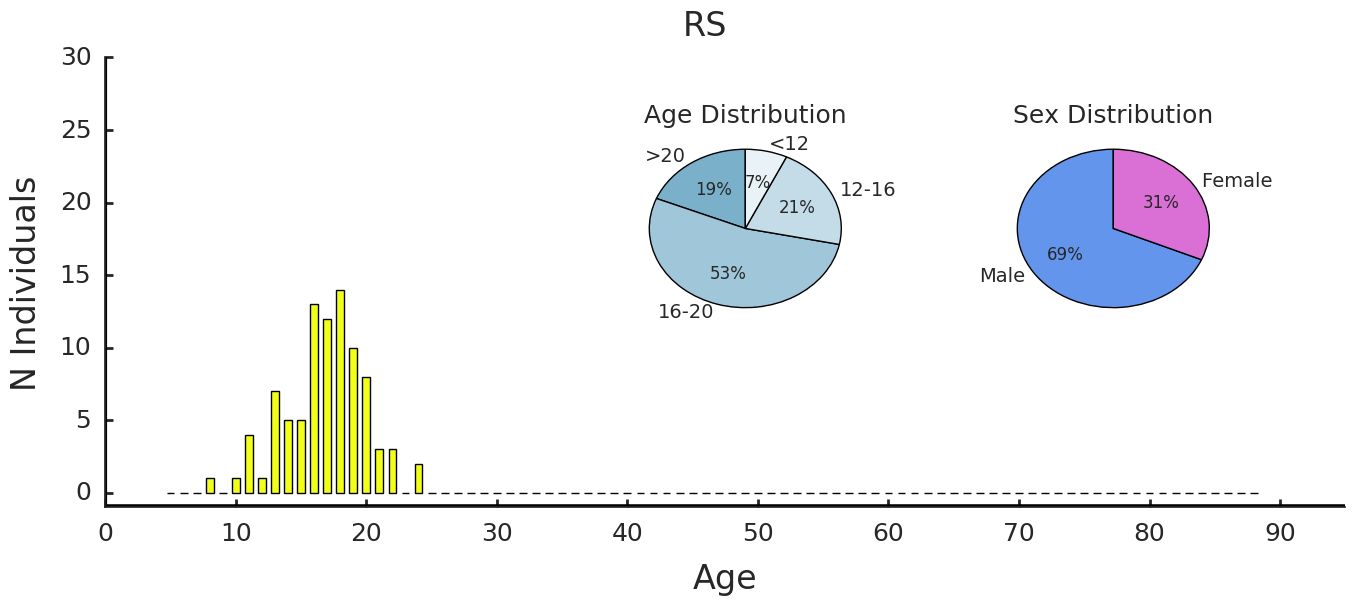

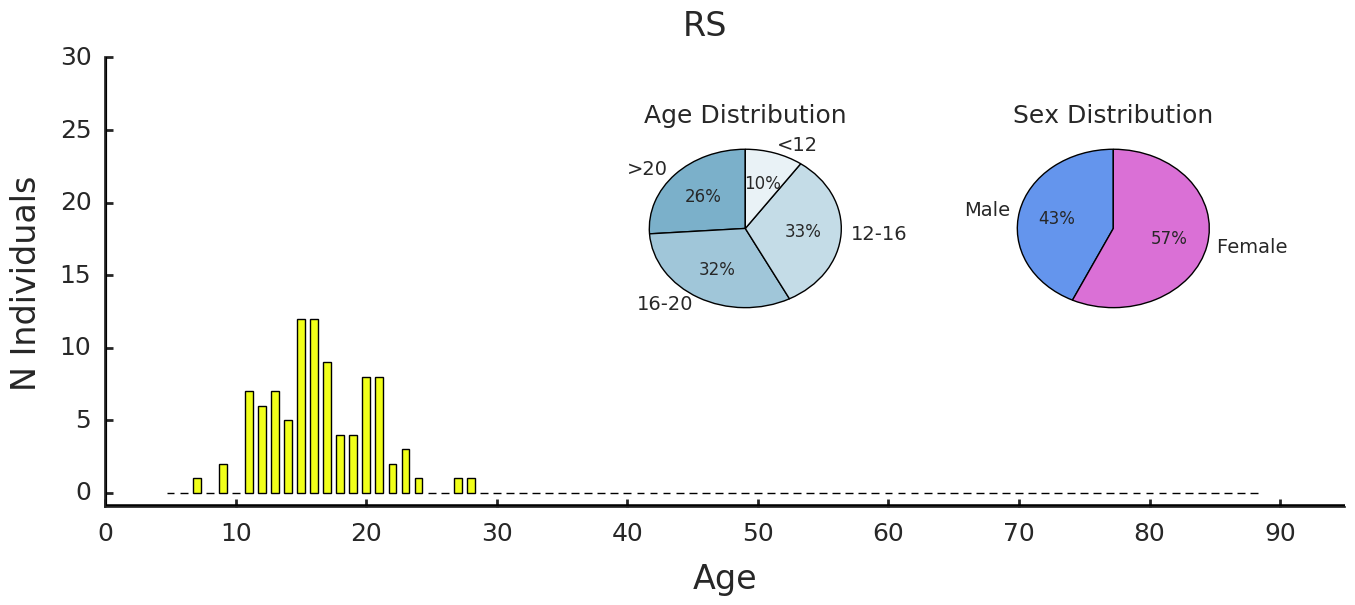

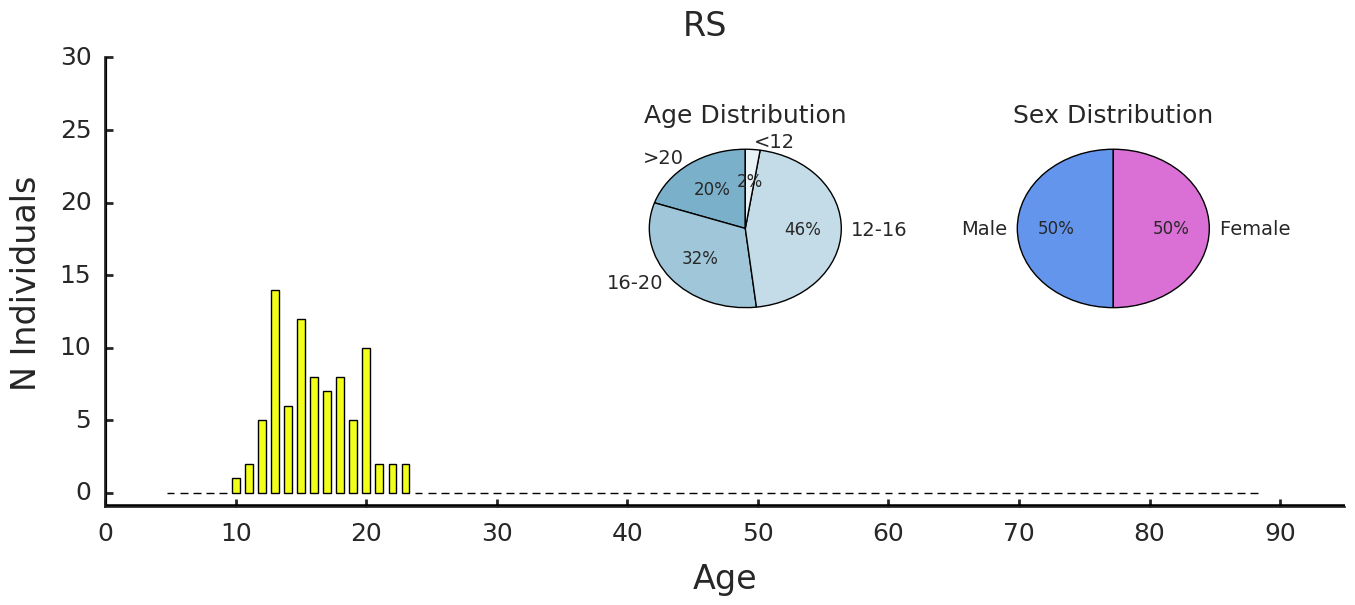

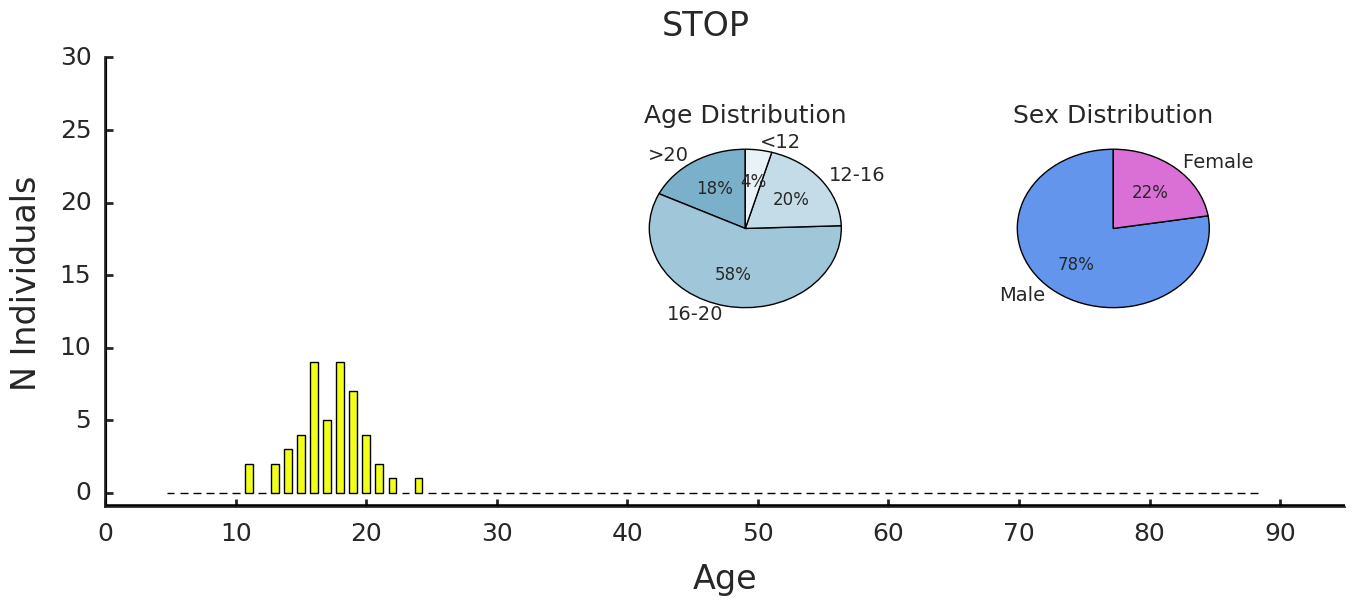

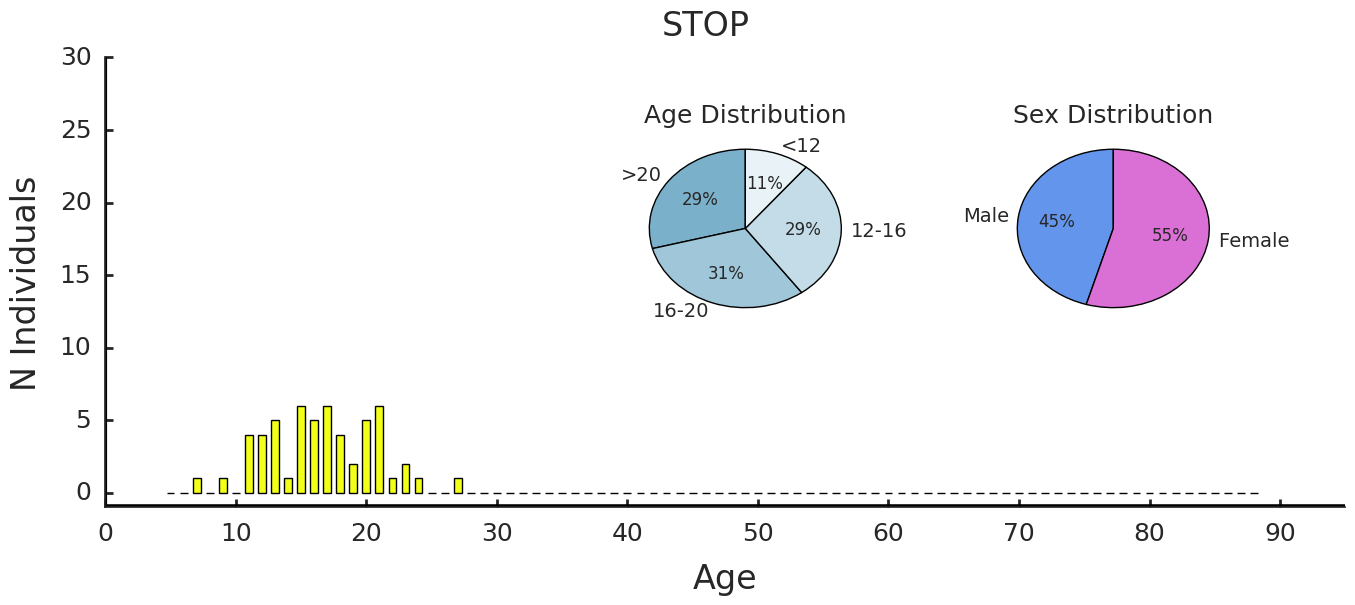

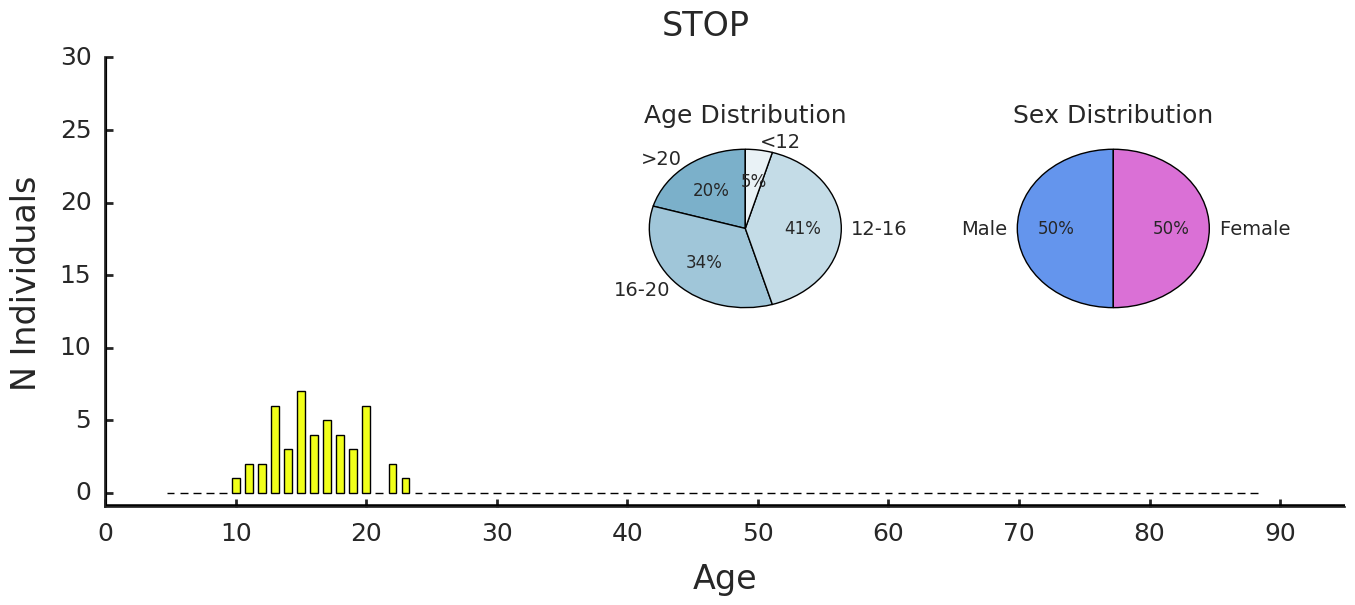

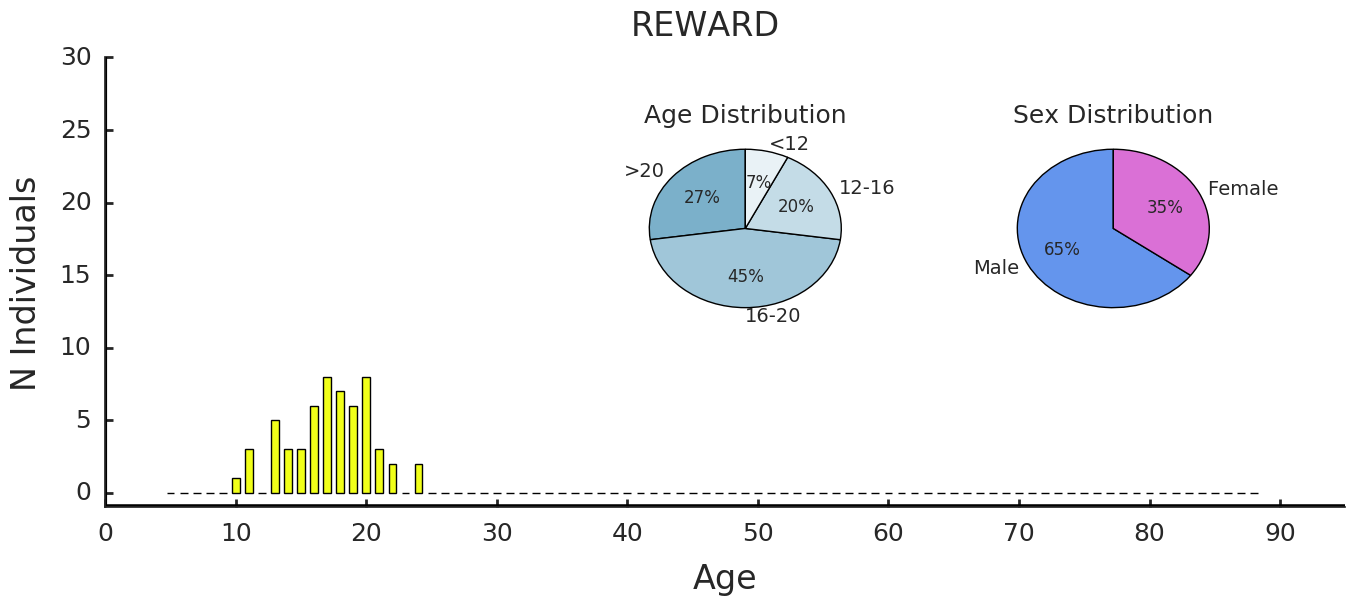

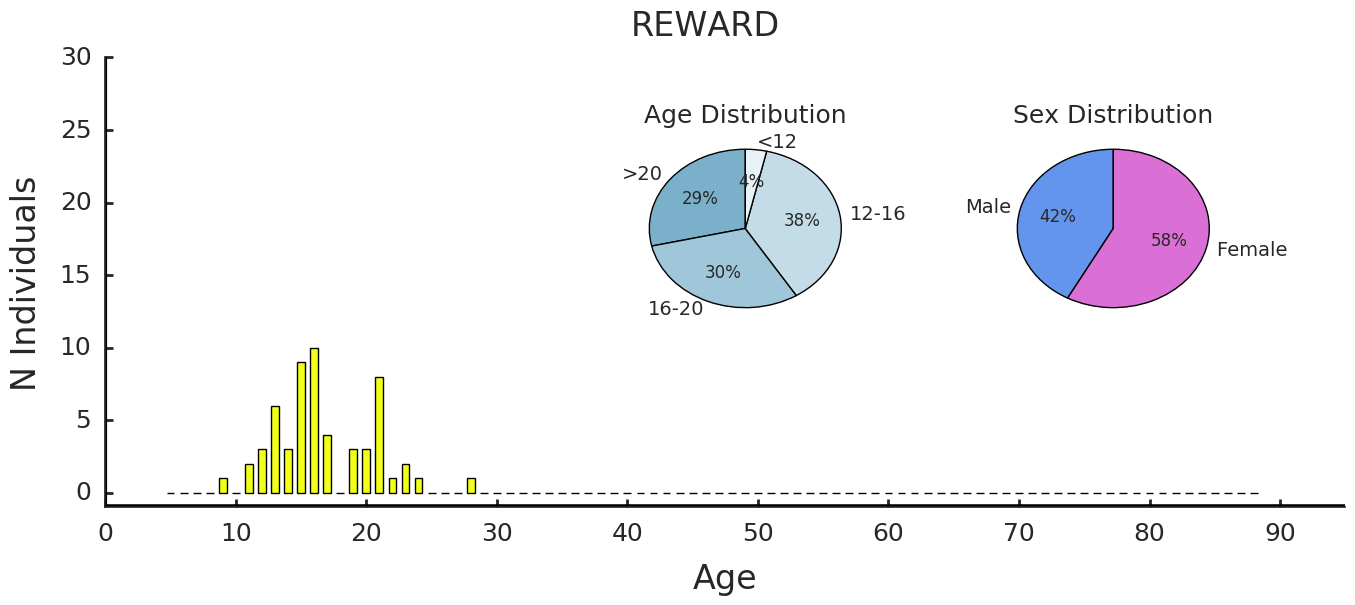

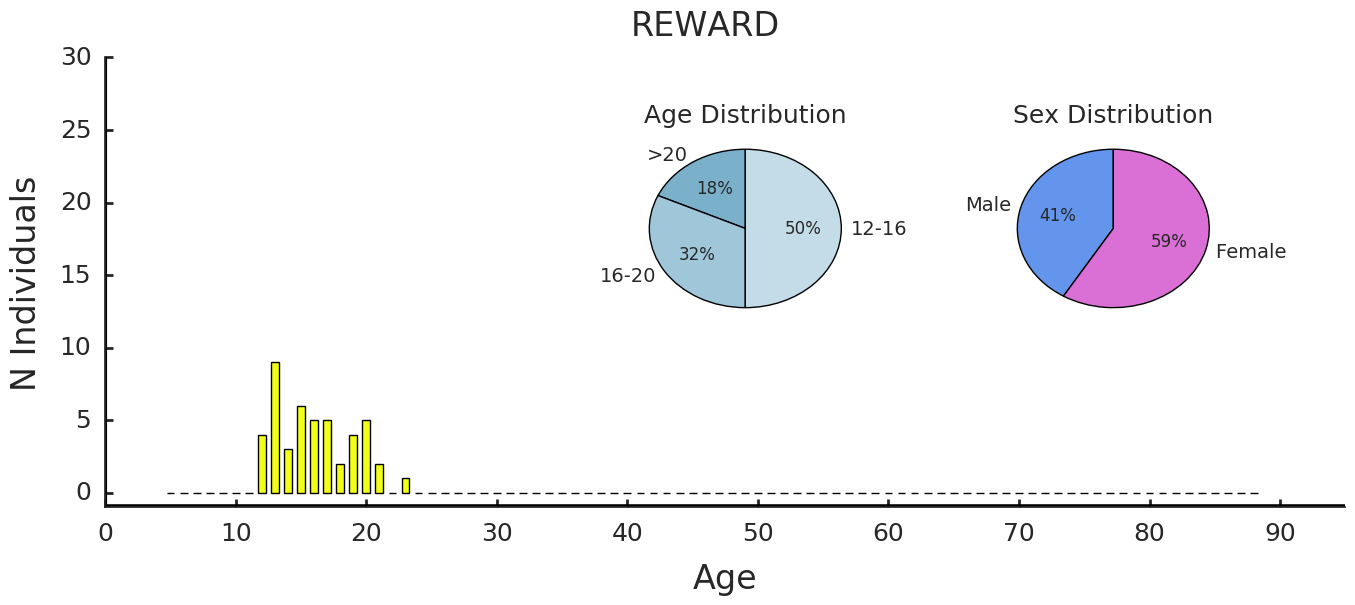

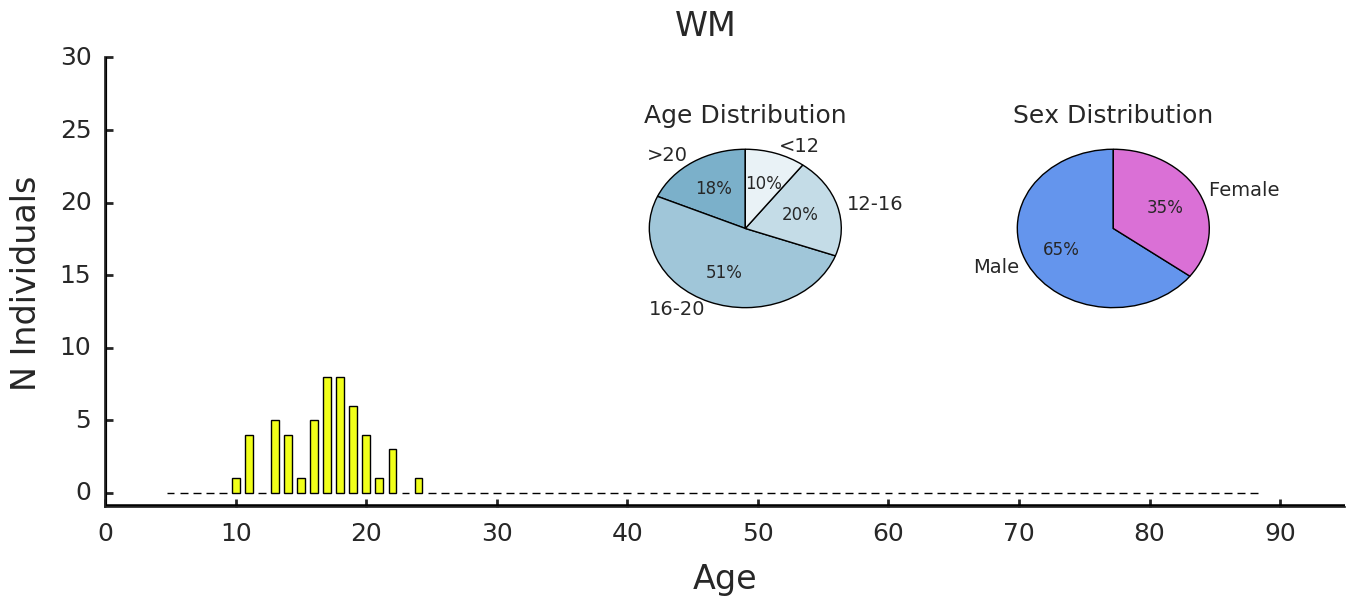

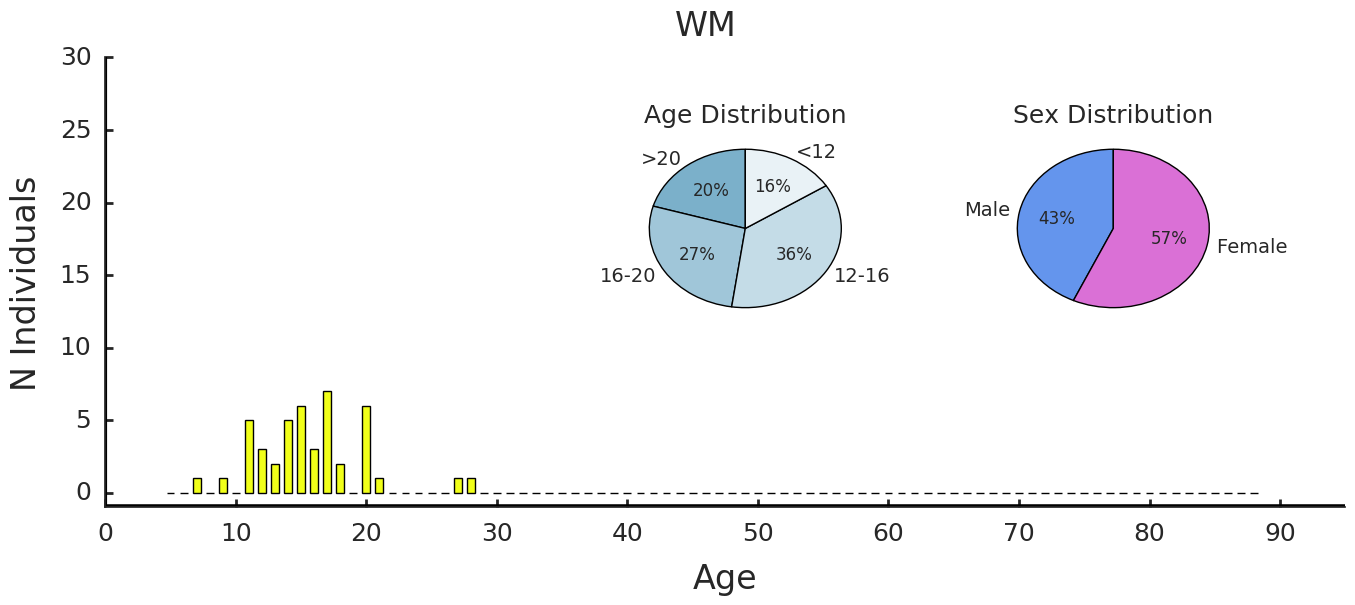

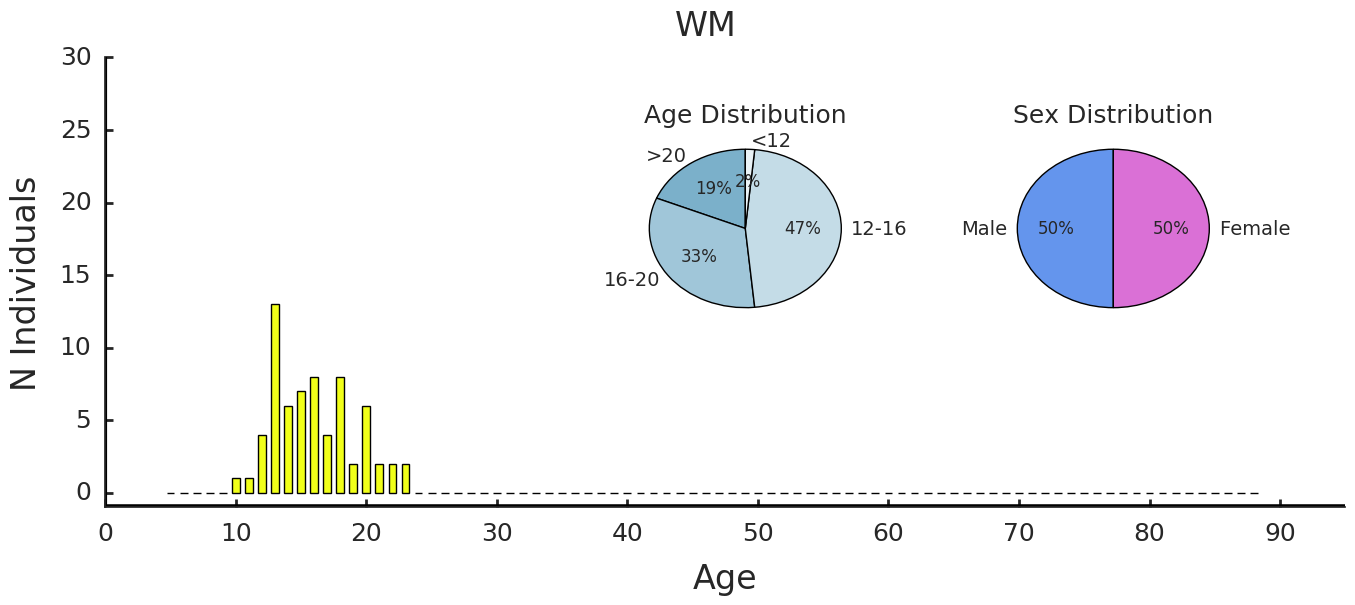

In [32]:
#suplementary figure 1 demographic
for i in range(len(NeuroIMAGE)):
    ymax=30
    sample = NeuroIMAGE[i]
    sample_sex = [int(j=='M') for j in genderADHD[i]]
    sample_age = ageADHD[i]
    
    agehist, agebins = np.histogram(sample_age, bins=range(5,90,1))
    
    make_demofig(NeuroIMAGE[i], sample_sex, sample_age, agehist, agebins, ymax,'pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/demographic'+NeuroIMAGE[i]+'_ADHD.pdf')
    
    sample_sex = [int(j=='M') for j in genderSibADHD[i]]
    sample_age = ageSibADHD[i]
    
    agehist, agebins = np.histogram(sample_age, bins=range(5,90,1))
    
    make_demofig(NeuroIMAGE[i], sample_sex, sample_age, agehist, agebins, ymax,'pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/demographic'+NeuroIMAGE[i]+'_SibADHD.pdf')

    sample_sex = [int(j=='M') for j in genderCONTROL[i]]
    sample_age = ageCONTROL[i]
    
    agehist, agebins = np.histogram(sample_age, bins=range(5,90,1))
    
    make_demofig(NeuroIMAGE[i], sample_sex, sample_age, agehist, agebins, ymax,'pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/demographic'+NeuroIMAGE[i]+'_CONTROL.pdf')

In [43]:
#overlap subjects between task 
for t in range(len(NeuroIMAGE)):
    for t2 in range(t,len(NeuroIMAGE)):
        sA=0
        sS=0
        sC=0
        for s in keepsujADHD[t]:
            if s in keepsujADHD[t2]:
                sA+=1
        for s in keepsujSibADHD[t]:
            if s in keepsujSibADHD[t2]:
                sS+=1
        for s in keepsujCONTROL[t]:
            if s in keepsujCONTROL[t2]:
                sC+=1
        print t,t2,sA,sS,sC

0 0 89 93 84
0 1 47 55 44
0 2 52 56 46
0 3 44 44 65
1 1 49 55 46
1 2 20 23 12
1 3 17 19 29
2 2 57 57 46
2 3 22 21 32
3 3 51 44 66


In [22]:
#check overlap ratio between acquisition
print 'ADHD',22/49.,22/57.,17/49., 17/51.,22/57.,  22/51.
print 'SibADHD',23/55., 23/57.,19/55.,19/44., 21/57., 21/44.
print 'CONTROL',12/46.,12/46.,29/46., 29/66., 32/46., 32/66.
import scipy.stats as ss
print ss.chi2_contingency([[55,23,19, 57, 21, 44],[49,22, 17, 57, 22, 51]])
print ss.chi2_contingency([[55,23,19, 57, 21, 44],[46,12,29,46, 32, 66]])
print ss.chi2_contingency([[46,12,29,46, 32, 66],[49,22, 17, 57, 22, 51]])


print ss.chi2_contingency([[22/49.,22/57.,17/49., 17/51.,22/57.,  22/51.],[23/55., 23/57.,19/55.,19/44., 21/57., 21/44.]])
print ss.chi2_contingency([[23/55., 23/57.,19/55.,19/44., 21/57., 21/44.],[12/46.,12/46.,29/46., 29/66., 32/46., 32/66.]])
print ss.chi2_contingency([[22/49.,22/57.,17/49., 17/51.,22/57.,  22/51.],[12/46.,12/46.,29/46., 29/66., 32/46., 32/66.]])



ADHD 0.448979591837 0.385964912281 0.34693877551 0.333333333333 0.385964912281 0.43137254902
SibADHD 0.418181818182 0.40350877193 0.345454545455 0.431818181818 0.368421052632 0.477272727273
CONTROL 0.260869565217 0.260869565217 0.630434782609 0.439393939394 0.695652173913 0.484848484848
(1.0162494591469295, 0.96124452254410542, 5, array([[ 52.11899314,  22.55148741,  18.04118993,  57.13043478,
         21.54919908,  47.60869565],
       [ 51.88100686,  22.44851259,  17.95881007,  56.86956522,
         21.45080092,  47.39130435]]))
(13.890109949493555, 0.01632272769645797, 5, array([[ 49.15333333,  17.03333333,  23.36      ,  50.12666667,
         25.79333333,  53.53333333],
       [ 51.84666667,  17.96666667,  24.64      ,  52.87333333,
         27.20666667,  56.46666667]]))
(10.748652652179793, 0.056597598623309195, 5, array([[ 48.8752784 ,  17.4922049 ,  23.66592428,  52.99109131,
         27.78173719,  60.19376392],
       [ 46.1247216 ,  16.5077951 ,  22.33407572,  50.00890869,
   

In [14]:
#testing methods
# value vs distribution
def testp(a,b):
    
    p=len(np.where(b>a)[0])/np.float(len(b))
    if a<np.mean(b):
        p=1-p
    return p


# two distributions 
def testboot(a,b):
    
    p=(len(np.where(a>np.mean(b))[0])+len(np.where(b<np.mean(a))[0]))/np.float(len(a)+len(b))
    if np.mean(a)>np.mean(b):
        p=1-p
    return p,np.mean(a),np.mean(b),np.std(a),np.std(b)




# plotting figure

In [23]:
def plotslicesZonecolor(brainVal,ortho='z',cut_coords=20,axes=None,reduc=1,title='',col='r'):
    import nilearn.plotting
    import nilearn.image   
    from nilearn.plotting import plot_roi, plot_stat_map
    from nilearn.image.image import mean_img
    import nibabel
    import seaborn as sns
    
    pal=np.concatenate([sns.color_palette("deep",6),sns.color_palette("pastel",6)],axis=0)
    if atlas=='ICPAtlas_v3_2':
        N=np.array([12,21,18,20,23,17,13,27,14])
    else:
        N=[20,11,22,22,18,8,18,13,7,17,23] #to verify if not 22,23
    pal2=np.concatenate([[col for j in range(N[i])] for i in range(number2)],axis=0)
    #col2=[sns.light_palette(col, as_cmap=True) for i in range(len(pal2))]
    initialcol='Greys'#sns.light_palette((0,0,0), as_cmap=True)
    
    atlasname='pathtodata/atlases/'
    j=0
    if atlas=='ICPAtlas_v3_2':
        func_filename = atlasname+'ICPAtlas_v3_2mm_4D.nii.gz'    
    else:
        func_filename = atlasname+'atlas_complete_GM_1mm_4Dwithout149_152_155_158_159_160.nii.gz'
    mean_epi = nibabel.load(func_filename)#nilearn.image.image.mean_img(func_filename)
    mean_epi_dat=mean_epi.get_data()
        #print mean_epi_dat.shape
        #blanck all area that do not interest us, binary all other
    mean_epi_dat=mean_epi_dat.T
    
    for j in range(mean_epi_dat.shape[0]):
        if brainVal[j]/np.max(brainVal)==0:
            #print j, mean_epi_dat.shape
            mean_epi_dat[j]=0
    mean_epi_dat=np.sign(np.sum(mean_epi_dat,0)).T
    #save
    func=nibabel.nifti1.Nifti1Image(mean_epi_dat,mean_epi.get_affine())
    
    
    brain=nilearn.plotting.plot_roi(func, func,colorbar=False,cut_coords=cut_coords,display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=axes,annotate=False)
    if title!='':
        brain.title(title,size=15./reduc,color=(0,0,0),bgcolor=(1,1,1))
    j=0
    if atlas=='ICPAtlas_v3_2':
        func_filename = atlasname+'ICPAtlas_v3_2mm_4D.nii.gz'    
    else:
        func_filename = atlasname+'atlas_complete_GM_1mm_4Dwithout149_152_155_158_159_160.nii.gz'
    
    atlas_imgs=nilearn.image.iter_img(func_filename)
    if reduc==1:
        lineW=1
    else:
        lineW=1./reduc
    for img in atlas_imgs:
        if brainVal[j]/np.max(brainVal)!=0:# and do<=5:
            mean_epi = mean_img(img)
            img3=img
            
            img2=nilearn.image.smooth_img(mean_epi,1)#trickimage(nilearn.image.smooth_img(mean_epi,1),0.02)
            brain.add_contours(img2,filled=True,levels=[0.02],cmap=None,colors=[[pal2[j][0],pal2[j][1],pal2[j][2]]],linewidths=lineW,alpha=brainVal[j]/np.max(brainVal))#cmap=sns.light_palette(col2[j](255*brainVal[j]/np.max(brainVal)), as_cmap=True))
        j+=1
    brain.add_contours(nilearn.image.smooth_img('/Software/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz',5),alpha=1, levels=[95],linewidths=lineW, cmap=sns.dark_palette('w', as_cmap=True),)#color='w',levels=[95,50]        
    brain.add_contours(nilearn.image.smooth_img('/Software/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz',0.5),alpha=0.8, levels=[5000],linewidths=lineW, cmap=sns.dark_palette('w', as_cmap=True))
    brain.annotate(left_right=False,size=int(12*lineW))

# BOOTSTRAPPING

In [20]:
#to redo
MeanBootADHD=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_mean80potency_ADHD_1030.npy')
MeanBootSIB=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_mean80potency_SIBLING_1030.npy')
MeanBootCON=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_mean80potency_CONTROL_1030.npy')
SelecBootADHD=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_selec80potency_ADHD_1030.npy')
SelecBootSIB=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_selec80potency_SIBLING_1030.npy')
SelecBootCON=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_selec80potency_CONTROL_1030.npy')



In [17]:

#to redo
MeanBootADHD2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_mean80potency_ADHD_randomlabel_1030.npy')
MeanBootSIB2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_mean80potency_SIBLING_randomlabel_1030.npy')
MeanBootCON2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_mean80potency_CONTROL_randomlabel_1030.npy')
SelecBootADHD2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_selec80potency_ADHD_randomlabel_1030.npy')
SelecBootSIB2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_selec80potency_SIBLING_randomlabel_1030.npy')
SelecBootCON2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_selec80potency_CONTROL_randomlabel_1030.npy')

In [21]:

#  compute mean potency for edges unic and shared for each edge lebal (sensitivity, Pall, Pmix, Psingle)


import copy
tri=np.zeros((number,number))
tri[np.triu_indices(number,1)]=1

# In[58]:
bootstrap=10000
#test of the significance of these percentage
#permutation testing
p=np.triu_indices(number,1)
meangroupUnicShared=np.zeros((3,3,4,bootstrap,2))#task,group,SensSpeUnspeCom,bootstrap,unicShared

Nareakeep=int(5*number/100)
#
pairedsplitgroup=[[0,1],[0,2],[1,2]]
pairedtask=[[0,1],[0,2],[1,2]]

groupS=[[0,1,2,3],[0,3,4,5],[0,1,5,6]]
keepwrong=np.zeros((3,3,4,2))
for b in range(bootstrap):
    if b/310.==float(b/100):
        print b
    #2 comput mean z selection, sens spe com
  
    
    Upmatricessplit=np.zeros((3,3,len(SelecBootADHD[0][0])))
    for i in range(3):
        Upmatricessplit[i][0]=copy.deepcopy(SelecBootADHD[i][b])
        Upmatricessplit[i][1]=copy.deepcopy(SelecBootSIB[i][b])
        Upmatricessplit[i][2]=copy.deepcopy(SelecBootCON[i][b])
        
        
    
    
    if True:
        # for no percentages : [1.,1.,1.]#
        #specificity
        UpmatricessplitSPE=np.sum(np.array(Upmatricessplit),0)
        UpmatricessplitCOM=copy.deepcopy(UpmatricessplitSPE)
        UpmatricessplitUN=copy.deepcopy(UpmatricessplitSPE)
        UpmatricessplitSPE[np.where(UpmatricessplitSPE!=1)]=0
        UpmatricessplitSPE=[UpmatricessplitSPE*Upmatricessplit[i] for i in range(3)]

        
        # for no percentages : [1.,1.,1.]#
        # undefined
        UpmatricessplitUN[np.where(UpmatricessplitUN!=2)]=0
        UpmatricessplitUNG=np.sign([UpmatricessplitUN*Upmatricessplit[i] for i in range(3)])
        UpmatricessplitUN=np.sign([UpmatricessplitUN*Upmatricessplit[a[0]]*Upmatricessplit[a[1]] for a in pairedtask])
        
        #common
        UpmatricessplitCOM[np.where(UpmatricessplitCOM!=3)]=0
        UpmatricessplitCOM=np.sign(UpmatricessplitCOM)
        
        
        for t in range(3):
            for e,g in enumerate([np.sign(Upmatricessplit),np.sign(UpmatricessplitSPE),np.sign(UpmatricessplitUNG),np.repeat([UpmatricessplitCOM],3,axis=0)]):
                meangroupUnicShared[t][0][e][b]=[np.mean(np.abs(MeanBootADHD[t][b][np.where((g[t][0]-(g[t][1]+g[t][2]))>0)])),np.mean(np.abs(MeanBootADHD[t][b][np.where((g[t][0]*g[t][1]+g[t][0]*g[t][2])>0)]))]/np.sqrt(int(len(UpmatricesADHD[t+1])*0.8))
                meangroupUnicShared[t][1][e][b]=[np.mean(np.abs(MeanBootSIB[t][b][np.where((g[t][0]-(g[t][1]+g[t][2]))>0)])),np.mean(np.abs(MeanBootSIB[t][b][np.where((g[t][0]*g[t][1]+g[t][1]*g[t][2])>0)]))]/np.sqrt(int(len(UpmatricesSibADHD[t+1])*0.8))
                meangroupUnicShared[t][2][e][b]=[np.mean(np.abs(MeanBootCON[t][b][np.where((g[t][0]-(g[t][1]+g[t][2]))>0)])),np.mean(np.abs(MeanBootCON[t][b][np.where((g[t][2]*g[t][1]+g[t][0]*g[t][2])>0)]))]/np.sqrt(int(len(UpmatricesCONTROL[t+1])*0.8))
                
                
   

0


In [18]:
#null version

import copy
tri=np.zeros((number,number))
tri[np.triu_indices(number,1)]=1


bootstrap=10000
#test of the significance of these percentage
#permutation testing
p=np.triu_indices(number,1)
meangroupUnicShared2=np.zeros((3,3,4,bootstrap,2))#task,group,SensSpeUnspeCom,bootstrap,unicShared

Nareakeep=int(5*number/100)
#
pairedsplitgroup=[[0,1],[0,2],[1,2]]
pairedtask=[[0,1],[0,2],[1,2]]

groupS=[[0,1,2,3],[0,3,4,5],[0,1,5,6]]
keepwrong=np.zeros((3,3,4,2))
for b in range(bootstrap):
    if b/310.==float(b/100):
        print b
    #2 comput mean z selection, sens spe com
  
    
    Upmatricessplit2=np.zeros((3,3,len(SelecBootADHD2[0][0])))
    for i in range(3):
        Upmatricessplit2[i][0]=copy.deepcopy(SelecBootADHD2[i][b])
        Upmatricessplit2[i][1]=copy.deepcopy(SelecBootSIB2[i][b])
        Upmatricessplit2[i][2]=copy.deepcopy(SelecBootCON2[i][b])
        
        
    
    
    if True:
        # for no percentages : [1.,1.,1.]#
        #specificity
        UpmatricessplitSPE2=np.sum(np.array(Upmatricessplit2),0)
        UpmatricessplitCOM2=copy.deepcopy(UpmatricessplitSPE2)
        UpmatricessplitUN2=copy.deepcopy(UpmatricessplitSPE2)
        UpmatricessplitSPE2[np.where(UpmatricessplitSPE2!=1)]=0
        UpmatricessplitSPE2=[UpmatricessplitSPE2*Upmatricessplit2[i] for i in range(3)]

        
        # for no percentages : [1.,1.,1.]#
        # undefined
        UpmatricessplitUN2[np.where(UpmatricessplitUN2!=2)]=0
        UpmatricessplitUNG2=np.sign([UpmatricessplitUN2*Upmatricessplit2[i] for i in range(3)])
        UpmatricessplitUN2=np.sign([UpmatricessplitUN2*Upmatricessplit2[a[0]]*Upmatricessplit2[a[1]] for a in pairedtask])
        
        #common
        UpmatricessplitCOM2[np.where(UpmatricessplitCOM2!=3)]=0
        UpmatricessplitCOM2=np.sign(UpmatricessplitCOM2)
        
        
        for t in range(3):
            for e,g in enumerate([np.sign(Upmatricessplit2),np.sign(UpmatricessplitSPE2),np.sign(UpmatricessplitUNG2),np.repeat([UpmatricessplitCOM2],3,axis=0)]):
                meangroupUnicShared2[t][0][e][b]=[np.mean(np.abs(MeanBootADHD2[t][b][np.where((g[t][0]-(g[t][1]+g[t][2]))>0)])),np.mean(np.abs(MeanBootADHD2[t][b][np.where((g[t][0]*g[t][1]+g[t][0]*g[t][2])>0)]))]/np.sqrt(int(len(UpmatricesADHD[t+1])*0.8))
                meangroupUnicShared2[t][1][e][b]=[np.mean(np.abs(MeanBootSIB2[t][b][np.where((g[t][0]-(g[t][1]+g[t][2]))>0)])),np.mean(np.abs(MeanBootSIB2[t][b][np.where((g[t][0]*g[t][1]+g[t][1]*g[t][2])>0)]))]/np.sqrt(int(len(UpmatricesSibADHD[t+1])*0.8))
                meangroupUnicShared2[t][2][e][b]=[np.mean(np.abs(MeanBootCON2[t][b][np.where((g[t][0]-(g[t][1]+g[t][2]))>0)])),np.mean(np.abs(MeanBootCON2[t][b][np.where((g[t][2]*g[t][1]+g[t][0]*g[t][2])>0)]))]/np.sqrt(int(len(UpmatricesCONTROL[t+1])*0.8))
                
                
   

0


In [22]:
meangroupUnicShared[np.where(np.isnan(meangroupUnicShared))]=0

In [19]:
meangroupUnicShared2[np.where(np.isnan(meangroupUnicShared2))]=0

In [20]:
np.save('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/meangroupUnicShared_24av.npy',meangroupUnicShared)
np.save('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/meangroupUnicShared_randomlabel_24av.npy',meangroupUnicShared2)
np.save('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/perc95groupUnicShared_24av.npy',perc95groupUnicShared)
np.save('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/area5percgroupUnicShared_24av.npy',area5percgroupUnicShared)

In [9]:
meangroupUnicShared=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/meangroupUnicShared_24av.npy')
meangroupUnicShared2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/meangroupUnicShared_randomlabel_24av.npy')

ADHD unic spe : (0.0039000000000000146, 1.4110750123155125, 1.1353616621613793, 0.094385508390319089, 0.048542975047715965)
SibADHD unic spe : (0.49339999999999995, 0.58241151649506995, 0.57665543570213695, 0.11269232088374131, 0.067001113961953143)
CONTROL unic spe : (0.3183, 0.62246194173000335, 0.58018403246466077, 0.11891468373192811, 0.069131508912654627)
ADHD shared spe : (0.4438, 1.2319315035425189, 1.1927889675441457, 0.30615429265136929, 0.14539631186874741)
SibADHD shared spe : (0.26344999999999996, 1.3070002879586133, 1.2033706526917922, 0.29601492061182894, 0.13241232128627312)
CONTROL shared spe : (0.36365, 1.1828563411511193, 1.1843948400869022, 0.30946466105189352, 0.1765156752363819)
[ 0.0234  0.4934  0.4934  0.4934  0.4934  0.4934]
ADHD unic unspe : (0.017349999999999977, 1.5626839305382594, 1.2845440802709482, 0.14216706997590936, 0.092699188467477073)
SibADHD unic unspe : (0.38065000000000004, 0.98289634932753756, 0.94491105127605646, 0.17930463044456071, 0.121227093

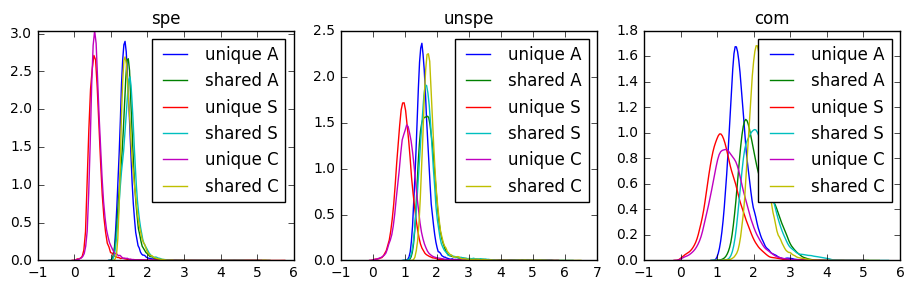

In [25]:
###test differences between unique and shared potency amplitude for each edge category
co=['sens','spe','unspe','com']
plt.figure(figsize=(12,3))
for c in range(1,4):
    keep=[]
    
    plt.subplot(1,4,c+1)
    gr=['A','S','C']
                
    Anan=np.where(np.array(np.mean([meangroupUnicShared[t][0][c].T[0] for t in range(3)],0))!=0)#range(10000)#
    Snan=np.where(np.array(np.mean([meangroupUnicShared[t][1][c].T[0] for t in range(3)],0))!=0)
    Cnan=np.where(np.array(np.mean([meangroupUnicShared[t][2][c].T[0] for t in range(3)],0))!=0)
    
    
    Anan2=np.where(np.array(np.mean([meangroupUnicShared2[t][0][c].T[0] for t in range(3)],0))!=0)#range(10000)#
    Snan2=np.where(np.array(np.mean([meangroupUnicShared2[t][1][c].T[0] for t in range(3)],0))!=0)
    Cnan2=np.where(np.array(np.mean([meangroupUnicShared2[t][2][c].T[0] for t in range(3)],0))!=0)
    
    prov=testboot((np.array(np.mean([meangroupUnicShared[t][0][c].T[0] for t in range(3)],0))[Anan]),np.array(np.mean([meangroupUnicShared2[t][0][c].T[0] for t in range(3)],0))[Anan2])
    print 'ADHD unic '+co[c]+' :', prov
    
    prov=testboot((np.array(np.mean([meangroupUnicShared[t][1][c].T[0] for t in range(3)],0))[Snan]),np.array(np.mean([meangroupUnicShared2[t][1][c].T[0] for t in range(3)],0))[Snan2])
    print 'SibADHD unic '+co[c]+' :', prov
    
    prov=testboot((np.array(np.mean([meangroupUnicShared[t][2][c].T[0] for t in range(3)],0))[Cnan]),np.array(np.mean([meangroupUnicShared2[t][2][c].T[0] for t in range(3)],0))[Cnan2])
    print 'CONTROL unic '+co[c]+' :', prov
    
    prov=testboot((np.array(np.mean([meangroupUnicShared[t][0][c].T[1] for t in range(3)],0))[Anan]),np.array(np.mean([meangroupUnicShared2[t][0][c].T[1] for t in range(3)],0))[Anan2])
    print 'ADHD shared '+co[c]+' :', prov
    
    prov=testboot((np.array(np.mean([meangroupUnicShared[t][1][c].T[1] for t in range(3)],0))[Snan]),np.array(np.mean([meangroupUnicShared2[t][1][c].T[1] for t in range(3)],0))[Snan2])
    print 'SibADHD shared '+co[c]+' :', prov
    
    prov=testboot((np.array(np.mean([meangroupUnicShared[t][2][c].T[1] for t in range(3)],0))[Cnan]),np.array(np.mean([meangroupUnicShared2[t][2][c].T[1] for t in range(3)],0))[Cnan2])
    print 'CONTROL shared '+co[c]+' :', prov
    
    
    
    for g in range(3):
        sns.distplot((np.array([meangroupUnicShared[t][g][c].T[0] for t in range(3)])[np.where(np.array([meangroupUnicShared[t][g][c].T[0] for t in range(3)])!=0)]),label='unique '+gr[g],hist=False)
        
        
        sns.distplot((np.array([meangroupUnicShared[t][g][c].T[1] for t in range(3)])[np.where(np.array([meangroupUnicShared[t][g][c].T[1] for t in range(3)])!=0)]),label='shared '+gr[g],hist=False)
    plt.title(co[c])
    #plt.xlim(-10,3)
    plt.legend()
plt.tight_layout()
plt.show()

In [36]:
print 'unic shared : spe, unspe, com' #per group fdr correction
print pval_correction.correct(np.array([0.0039000000000000146,0.4438,0.017349999999999977,0.09789999999999999,0.09018338727076591,0.04110032362459548]), correction='fdr')
print pval_correction.correct(np.array([0.49339999999999995,0.26344999999999996,0.38065000000000004,0.06164999999999998,0.4104099244875944,0.013052858683926694]), correction='fdr')
print pval_correction.correct(np.array([0.3183,0.36365,0.19379999999999997,0.0877,0.221143473570658,0.017961165048543726]), correction='fdr')


unic shared : spe, unspe, com
[ 0.0234      0.4438      0.05205     0.11748     0.11748     0.08220065]
[ 0.4934      0.49249191  0.49249191  0.18495     0.49249191  0.07831715]
[ 0.36365     0.36365     0.33171521  0.2631      0.33171521  0.10776699]


In [ ]:
#looking at percentage of selected edges differences

In [12]:
modulatebysens=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSENS80percent_1030.npy')
modulatebyspe=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSPE80percent_1030.npy')
modulatebycom=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapCOM80percent_1030.npy')
modulatebyun=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapUN80percent_1030.npy')
SUMundefined=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapUN80percent_alledges_1030.npy')
SUMsensitivity=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSENS80percent_alledges_1030.npy')
SUMspecificity=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSPE80percent_alledges_1030.npy')
SUMcommon=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapCOM80percent_alledges_1030.npy')
#
modulatebysens2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSENS80percent_randomlabel_1030.npy')
modulatebyspe2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSPE80percent_randomlabel_1030.npy')
modulatebycom2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapCOM80percent_randomlabel_1030.npy')
modulatebyun2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapUN80percent_randomlabel_1030.npy')
SUMundefined2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapUN80percent_alledges_randomlabel_1030.npy')
SUMsensitivity2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSENS80percent_alledges_randomlabel_1030.npy')
SUMspecificity2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSPE80percent_alledges_randomlabel_1030.npy')
SUMcommon2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapCOM80percent_alledges_randomlabel_1030.npy')

In [13]:
modulatebysensG2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSENS80percent_randomlabel_group_1030.npy')
modulatebyspeG2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSPE80percent_randomlabel_group_1030.npy')
modulatebycomG2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapCOM80percent_randomlabel_group_1030.npy')
modulatebyunG2=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapUN80percent_randomlabel_group_1030.npy')

In [11]:
modulatebysensG=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSENS80percent_group_1030.npy')
modulatebyspeG=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapSPE80percent_group_1030.npy')
modulatebycomG=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapCOM80percent_group_1030.npy')
modulatebyunG=np.load('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_permutationtestingoverlapUN80percent_group_1030.npy')

In [19]:
##against random
import pval_correction
import scipy.stats as ss

namedat=['SENS','SPE','UNSPE','COM']
for e,dat in enumerate([[modulatebyspeG,modulatebyspeG2],[modulatebyunG,modulatebyunG2],[modulatebycomG,modulatebycomG2]]):
    print namedat[e+1],'pvalue against rand',np.array([testp(np.mean(np.mean(dat[0],0),1)[g],np.mean(dat[1],0)[g]) for g in range(len(np.mean(dat[1],0)))])#pval_correction.correct(, correction='fdr')
    print namedat[e+1],'mean value against rand',[[np.mean(np.mean(dat[0],0),1)[g],np.mean(np.mean(dat[1],0)[g])] for g in range(len(np.mean(dat[1],0)))]
    print namedat[e+1],'std value against rand',[[np.std(np.mean(dat[0],0),1)[g],np.std(np.mean(dat[1],0)[g])] for g in range(len(np.mean(dat[1],0)))]


SPE pvalue against rand [ 0.0319  0.0365  0.1825]
SPE mean value against rand [[0.57727777390980239, 0.50125107236438293], [0.58150915799035541, 0.50857067643945875], [0.52464776578095773, 0.48488358979473234]]
SPE mean value against rand [[0.057555252823171726, 0.040792054104637362], [0.049674514172406287, 0.040676585768708244], [0.051997192421771234, 0.044080188689865019]]
UNSPE pvalue against rand [ 0.4185  0.2457  0.3211]
UNSPE mean value against rand [[0.28368079473634039, 0.2935300038336236], [0.25527383986138819, 0.28226574329719645], [0.297745933150523, 0.31997063602403703]]
UNSPE mean value against rand [[0.05485510281115169, 0.040582212127200847], [0.046752879185404016, 0.039188818488411339], [0.051546768210058394, 0.045064772925781316]]
COM pvalue against rand [ 0.033   0.0971  0.3312]
COM mean value against rand [[0.13904143135385622, 0.20521892380199339], [0.16321700214825613, 0.20916358026334486], [0.17760630106851841, 0.19514577418123052]]
COM mean value against rand [[0

In [18]:
import pval_correction

print"per group"
print pval_correction.correct(np.array([ 0.0045,0.0319, 0.4185,0.033  ]), correction='fdr')
print pval_correction.correct(np.array([  0.0535,0.0365, 0.2457,  0.0971]), correction='fdr')
print pval_correction.correct(np.array([ 0.2449,0.1825,  0.3211,  0.3312]), correction='fdr')


perlabel
[ 0.05475  0.05475  0.1825 ]
[ 0.4185  0.4185  0.4185]
[ 0.099    0.14565  0.3312 ]
per group
[ 0.018   0.044   0.4185  0.044 ]
[ 0.107       0.107       0.2457      0.12946667]
[ 0.3312  0.3312  0.3312  0.3312]
all
[ 0.1095    0.4185    0.1095    0.1095    0.36855   0.218475  0.3285
  0.3726    0.3726  ]


In [16]:
# for the dimention of size 7 : ACS, AC, A, SA, S, CS, C
sharedG=[[0,1,3],[0,3,5],[0,1,5]]
uniqueG=[2,4,6]
totG=[[0,1,3,2],[0,3,5,4],[0,1,5,6]]

In [17]:

totG=[[0,1,2,3],[0,3,4,5],[0,1,5,6]]
import pval_correction
with open('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/10000_test_SENS_shared_unique_1030.txt','w') as f:
    namedat=['SENS']
    
    f.write('\n\n""""SENSITIVITY"""')
    dat=np.array([[(np.sum(modulatebysensG[t][totG[g]],0)/np.sum(modulatebysensG[t],0)) for g in range(3)] for t in range(3)])
    dat[np.where(np.isnan(dat))]=0
    
    dat2=np.array([[(np.sum(modulatebysensG2[t][totG[g]],0)/np.sum(modulatebysensG2[t],0)) for g in range(3)] for t in range(3)])
    dat2[np.where(np.isnan(dat2))]=0
    
    e=0
    if True:
        keep=[]
        keep2=[]
        f.write('\n'+namedat[e]+'\t pvalue\tmean1\tmean2\tstd1\tstd2\n')
        for t in range(3):
            res2=testp(np.mean(dat[t][0]),dat2[t][0])
            f.write('1ADHD rand: '+NeuroIMAGE[t+1]+'\t'+np.str(res2)+'\t'+np.str(np.mean(dat[t][0]))+'\t'+np.str(np.mean(dat2[t][0]))+'\t'+np.str(np.std(dat[t][0]))+'\t'+np.str(np.std(dat2[t][0]))+'\n')
            res2=testp(np.mean(dat[t][1]),dat2[t][1])
            f.write('1SIBLING rand: '+NeuroIMAGE[t+1]+'\t'+np.str(res2)+'\t'+np.str(np.mean(dat[t][1]))+'\t'+np.str(np.mean(dat2[t][1]))+'\t'+np.str(np.std(dat[t][1]))+'\t'+np.str(np.std(dat2[t][1]))+'\n')
            res2=testp(np.mean(dat[t][2]),dat2[t][2])
            f.write('CONTROL rand: '+NeuroIMAGE[t+1]+'\t'+np.str(res2)+'\t'+np.str(np.mean(dat[t][2]))+'\t'+np.str(np.mean(dat2[t][2]))+'\t'+np.str(np.std(dat[t][2]))+'\t'+np.str(np.std(dat2[t][2]))+'\n')
            
            
        res2=testp(np.mean(np.mean(dat,0)[0]),np.mean(dat2,0)[0])
        f.write('1ADHD rand: ALL\t'+np.str(res2)+'\t'+np.str(np.mean(np.mean(dat,0)[0]))+'\t'+np.str(np.mean(np.mean(dat2,0)[0]))+'\t'+np.str(np.std(np.mean(dat,0)[0]))+'\t'+np.str(np.std(np.mean(dat2,0)[0]))+'\n')
        res2=testp(np.mean(np.mean(dat,0)[1]),np.mean(dat2,0)[1])
        f.write('1SIBLING rand: ALL\t'+np.str(res2)+'\t'+np.str(np.mean(np.mean(dat,0)[1]))+'\t'+np.str(np.mean(np.mean(dat2,0)[1]))+'\t'+np.str(np.std(np.mean(dat,0)[1]))+'\t'+np.str(np.std(np.mean(dat2,0)[1]))+'\n')
        res2=testp(np.mean(np.mean(dat,0)[2]),np.mean(dat2,0)[2])
        f.write('1CONTROL rand: ALL\t'+np.str(res2)+'\t'+np.str(np.mean(np.mean(dat,0)[2]))+'\t'+np.str(np.mean(np.mean(dat2,0)[2]))+'\t'+np.str(np.std(np.mean(dat,0)[2]))+'\t'+np.str(np.std(np.mean(dat2,0)[2]))+'\n')
        
        
        
        
     

[ 0.49535  0.49535  0.49535]
[ 0.259125  0.17565   0.26275 ]


In [13]:
taskpair=[[0,0],[1,0],[1,1]]
taskpair2=[[0,1],[0,2],[1,2]]

In [15]:
import matplotlib.patches as patches
def addTriangle():
    plt.plot([-1, 0], [0, 1], 'k-', lw=2,alpha=0.5)
    plt.plot([-1, 1], [0, 0], 'k-', lw=2,alpha=0.5)
    plt.plot([0, 1], [1, 0], 'k-', lw=2,alpha=0.5)
    plt.plot([0, 0], [0, 1], 'k-', lw=1,alpha=0.5)
    plt.gca().add_patch(plt.Polygon(np.array([[-1,0],[-1,1],[0,1]]),closed=True,color='w',edgecolor="none"))
    plt.gca().add_patch(plt.Polygon(np.array([[1,0],[1,1],[0,1]]),closed=True,color='w',edgecolor="none"))
    sns.despine(left=True,bottom=True)

[[0, 0], [1, 0], [1, 1]]


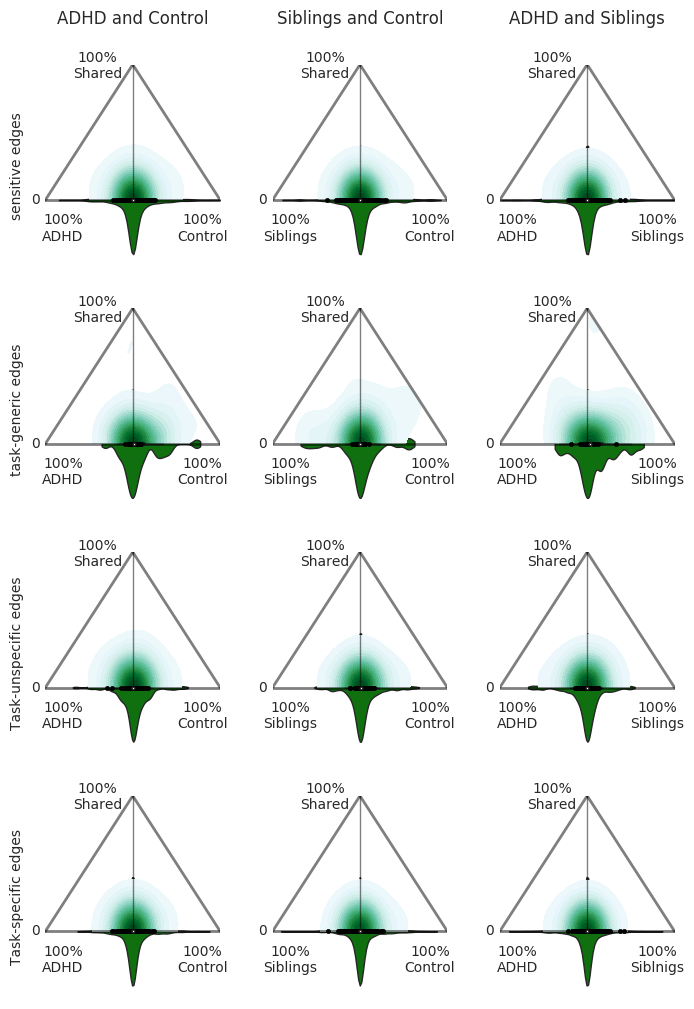

[[0, 0], [1, 0], [1, 1]]


In [18]:
#supplemental figure 5: reproducibility of edge selection across bootstrapp / group comparison
bootstrap=10000
plt.figure(figsize=(8,11))
sns.set_style('white')
sns.despine()
t=range(3)

taskpair=taskpairindex
print taskpair

    
d=.8
v=0.15#2
g=0.2

    
plt.subplot(4,3,1)

keepx=[]
keepy=[]
for i in t:

    AC=(SUMsensitivity[i][0]+SUMsensitivity[i][1])[np.triu_indices(number,1)]
    A_C=-(SUMsensitivity[i][2]+SUMsensitivity[i][3]-(SUMsensitivity[i][5]+SUMsensitivity[i][6]))[np.triu_indices(number,1)]

    selectemp=np.where(AC+A_C!=0)
    keepx+=[A_C[selectemp]]
    keepy+=[AC[selectemp]]

sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.xticks([0],[''])    
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.text(0,1.3,'ADHD and Control',fontsize=12,ha='center')
plt.ylabel('sensitive edges')
    
plt.subplot(4,3,10)
keepy=[]
keepx=[]
for i in t:
    AC=(SUMspecificity[i][0]+SUMspecificity[i][1])[np.triu_indices(number,1)]
    A_C=-(SUMspecificity[i][2]+SUMspecificity[i][3]-(SUMspecificity[i][5]+SUMspecificity[i][6]))[np.triu_indices(number,1)]


    speloc=np.where(AC+A_C!=0)
    keepy+=[AC[speloc]]
    keepx+=[A_C[speloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.xticks([0],[''])    
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.ylabel('Task-specific edges')

plt.subplot(4,3,7)
keepy=[]
keepx=[]
for i in t:

    AC=(SUMundefined[i][0]+SUMundefined[i][1])[np.triu_indices(number,1)]
    A_C=-(SUMundefined[i][2]+SUMundefined[i][3]-(SUMundefined[i][5]+SUMundefined[i][6]))[np.triu_indices(number,1)]


    unloc=np.where(AC+A_C!=0)
    keepy+=[AC[unloc]]
    keepx+=[A_C[unloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.xticks([0],[''])    
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.ylabel('Task-unspecific edges')
    
plt.subplot(4,3,4)
keepy=[]
keepx=[]


A_C=-(SUMcommon[2]+SUMcommon[3]-(SUMcommon[5]+SUMcommon[6]))[np.triu_indices(number,1)]
comloc=np.where(AC+A_C!=0)#
keepy+=[AC[comloc]]
keepx+=[A_C[comloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.ylabel('task-generic edges')
plt.xticks([0],[''])



plt.subplot(4,3,2)
keepy=[]
keepx=[]
for i in t:
    SC=(SUMsensitivity[i][0]+SUMsensitivity[i][5])[np.triu_indices(number,1)]
    S_C=-(SUMsensitivity[i][4]+SUMsensitivity[i][3]-(SUMsensitivity[i][1]+SUMsensitivity[i][6]))[np.triu_indices(number,1)]

    selectemp=np.where(SC+S_C!=0)
    keepy+=[SC[selectemp]]
    keepx+=[S_C[selectemp]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.text(0,1.3,'Siblings and Control',fontsize=12,ha='center')
plt.text(-d,-.3,'100%\nSiblings',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])
    
plt.subplot(4,3,11)
keepy=[]
keepx=[]
for i in t:
    SC=(SUMspecificity[i][0]+SUMspecificity[i][5])[np.triu_indices(number,1)]
    S_C=-(SUMspecificity[i][4]+SUMspecificity[i][3]-(SUMspecificity[i][1]+SUMspecificity[i][6]))[np.triu_indices(number,1)]

    speloc=np.where(SC+S_C!=0)
    keepy+=[SC[speloc]]
    keepx+=[S_C[speloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nSiblings',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])

plt.subplot(4,3,8)
keepy=[]
keepx=[]
for i in t:
    SC=(SUMundefined[i][0]+SUMundefined[i][5])[np.triu_indices(number,1)]
    S_C=-(SUMundefined[i][4]+SUMundefined[i][3]-(SUMundefined[i][1]+SUMundefined[i][6]))[np.triu_indices(number,1)]

    unloc=np.where(SC+S_C!=0)
    keepy+=[SC[unloc]]
    keepx+=[S_C[unloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nSiblings',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])
    
plt.subplot(4,3,5)
keepy=[]
keepx=[]
SC=(SUMcommon[0]+SUMcommon[5])[np.triu_indices(number,1)]
S_C=-(SUMcommon[4]+SUMcommon[3]-(SUMcommon[1]+SUMcommon[6]))[np.triu_indices(number,1)]
comloc=np.where(SC+S_C!=0)#
    
keepy+=[SC[comloc]]
keepx+=[S_C[comloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))

plt.text(-d,-.3,'100%\nSiblings',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])

keepy=[]
plt.subplot(4,3,3)
keepx=[]
for i in t:
    CC=(SUMsensitivity[i][0]+SUMsensitivity[i][3])[np.triu_indices(number,1)]
    C_C=-(SUMsensitivity[i][1]+SUMsensitivity[i][2]-(SUMsensitivity[i][4]+SUMsensitivity[i][5]))[np.triu_indices(number,1)]

    selectemp=np.where(CC+C_C!=0)
    keepy+=[CC[selectemp]]#CC
    keepx+=[C_C[selectemp]]#CC
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.xlim((-1,1))
plt.ylim((-0.5,1))
plt.text(0,1.3,'ADHD and Siblings',fontsize=12,ha='center')

plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nSiblings',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])
plt.legend()
    
plt.subplot(4,3,12)
keepx=[]
keepy=[]
for i in t:
    CC=(SUMspecificity[i][0]+SUMspecificity[i][3])[np.triu_indices(number,1)]
    C_C=-(SUMspecificity[i][1]+SUMspecificity[i][2]-(SUMspecificity[i][4]+SUMspecificity[i][5]))[np.triu_indices(number,1)]


    speloc=np.where(CC+C_C!=0)
    keepy+=[CC[speloc]]
    keepx+=[C_C[speloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.xlim((-1,1))
plt.ylim((-0.5,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nSiblnigs',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])
plt.legend()

plt.subplot(4,3,9)

keepy=[]
keepx=[]

for i in t:
    CC=(SUMundefined[i][0]+SUMundefined[i][3])[np.triu_indices(number,1)]#/np.float(bootstrap)
    C_C=-(SUMundefined[i][1]+SUMundefined[i][2]-(SUMundefined[i][4]+SUMundefined[i][5]))[np.triu_indices(number,1)]#/np.float(bootstrap)#adhd-#control


    unloc=np.where(CC+C_C!=0.)#np.where(np.sign(undefinedALLCONTROL[i]+undefinedALLADHD[i]+undefinedALLSibADHD[i])[np.triu_indices(number,1)]!=0)
    keepx+=[C_C[unloc]]
    keepy+=[CC[unloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.xlim((-1,1))
plt.ylim((-0.5,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nSiblings',ha= 'center')
plt.xticks([0],[''])
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.legend()

plt.subplot(4,3,6)
keepx=[]
keepy=[]
CC=(SUMcommon[0]+SUMcommon[3])[np.triu_indices(number,1)]#/np.float(bootstrap)
C_C=-(SUMcommon[1]+SUMcommon[2]-(SUMcommon[4]+SUMcommon[5]))[np.triu_indices(number,1)]#/np.float(bootstrap)#adhd-#control

comloc=np.where(CC+C_C!=0)#
keepx+=[C_C[comloc]]
keepy+=[CC[comloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='g', edgecolor='g', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)))#,vertical=True)
addTriangle()
plt.xlim((-1,1))
plt.ylim((-0.5,1))
plt.xticks([0],[''])
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nSiblings',ha= 'center')
plt.legend()


plt.tight_layout(pad=2,rect=[0, 0, 0.9, 0.9])    
plt.subplots_adjust(wspace=0.3,  hspace=0.2)


plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/permutationtestingEdges_3tasks_20-4_3groups.pdf', bbox_inches="tight")#3tasks_30s.pdf')


plt.show()

print taskpair

[[0, 0], [1, 0], [1, 1]]


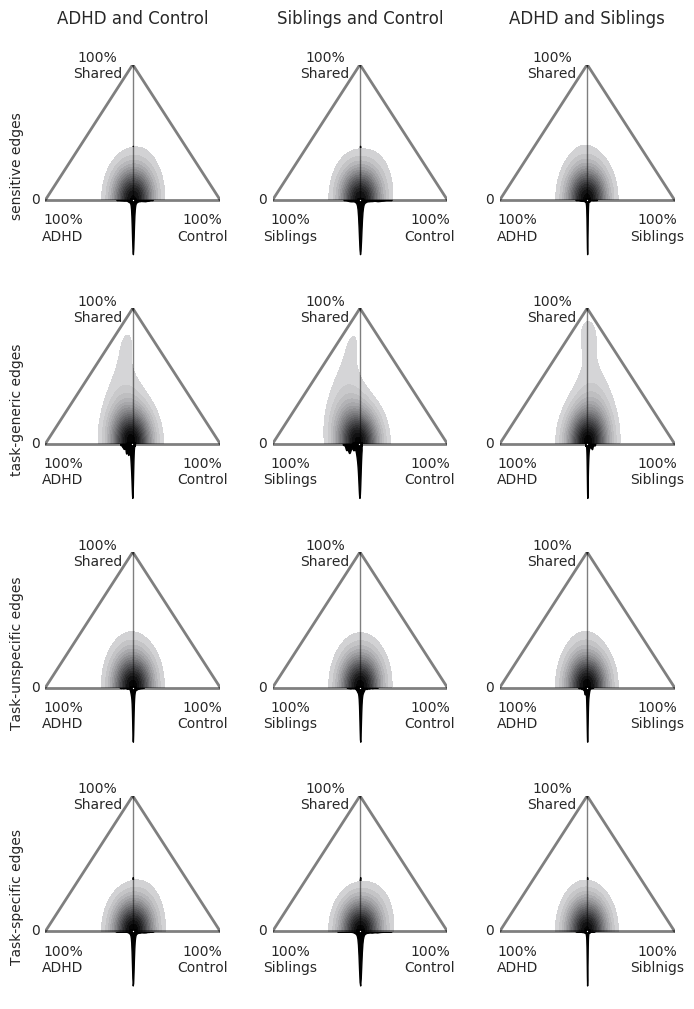

[[0, 0], [1, 0], [1, 1]]


In [27]:
#supplementary figure 5bis
bootstrap=10000
plt.figure(figsize=(8,11))
sns.set_style('white')
sns.despine()
t=range(3)#[1]#range(3)

taskpair=taskpairindex
print taskpair
cmap=sns.cubehelix_palette( hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    
d=.8
v=0.15#2
g=0.2

    
plt.subplot(4,3,1)

keepx=[]
keepy=[]
for i in t:

    AC=(SUMsensitivity2[i][0]+SUMsensitivity2[i][1])[np.triu_indices(number,1)]
    A_C=-(SUMsensitivity2[i][2]+SUMsensitivity2[i][3]-(SUMsensitivity2[i][5]+SUMsensitivity2[i][6]))[np.triu_indices(number,1)]

    selectemp=np.where(AC+A_C!=0)
    keepx+=[A_C[selectemp]]
    keepy+=[AC[selectemp]]

sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.xticks([0],[''])    
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.text(0,1.3,'ADHD and Control',fontsize=12,ha='center')
plt.ylabel('sensitive edges')
    
plt.subplot(4,3,10)
keepy=[]
keepx=[]
for i in t:

    AC=(SUMspecificity2[i][0]+SUMspecificity2[i][1])[np.triu_indices(number,1)]
    A_C=-(SUMspecificity2[i][2]+SUMspecificity2[i][3]-(SUMspecificity2[i][5]+SUMspecificity2[i][6]))[np.triu_indices(number,1)]


    speloc=np.where(AC+A_C!=0)
    keepy+=[AC[speloc]]
    keepx+=[A_C[speloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.xticks([0],[''])    
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.ylabel('Task-specific edges')

plt.subplot(4,3,7)
keepy=[]
keepx=[]
for i in t:

    AC=(SUMundefined2[i][0]+SUMundefined2[i][1])[np.triu_indices(number,1)]
    A_C=-(SUMundefined2[i][2]+SUMundefined2[i][3]-(SUMundefined2[i][5]+SUMundefined2[i][6]))[np.triu_indices(number,1)]


    unloc=np.where(AC+A_C!=0)
    keepy+=[AC[unloc]]
    keepx+=[A_C[unloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.xticks([0],[''])    
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.ylabel('Task-unspecific edges')
    
plt.subplot(4,3,4)
keepy=[]
keepx=[]

AC=(SUMcommon2[0]+SUMcommon2[1])[np.triu_indices(number,1)]
A_C=-(SUMcommon2[2]+SUMcommon2[3]-(SUMcommon2[5]+SUMcommon2[6]))[np.triu_indices(number,1)]
comloc=np.where(AC+A_C!=0)#
keepy+=[AC[comloc]]
keepx+=[A_C[comloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.ylabel('task-generic edges')
plt.xticks([0],[''])



plt.subplot(4,3,2)
keepy=[]
keepx=[]
for i in t:
    SC=(SUMsensitivity2[i][0]+SUMsensitivity2[i][5])[np.triu_indices(number,1)]
    S_C=-(SUMsensitivity2[i][4]+SUMsensitivity2[i][3]-(SUMsensitivity2[i][1]+SUMsensitivity2[i][6]))[np.triu_indices(number,1)]

    selectemp=np.where(SC+S_C!=0)
    keepy+=[SC[selectemp]]
    keepx+=[S_C[selectemp]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.text(0,1.3,'Siblings and Control',fontsize=12,ha='center')
plt.text(-d,-.3,'100%\nSiblings',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])
    
plt.subplot(4,3,11)
keepy=[]
keepx=[]
for i in t:
    SC=(SUMspecificity2[i][0]+SUMspecificity2[i][5])[np.triu_indices(number,1)]
    S_C=-(SUMspecificity2[i][4]+SUMspecificity2[i][3]-(SUMspecificity2[i][1]+SUMspecificity2[i][6]))[np.triu_indices(number,1)]

    speloc=np.where(SC+S_C!=0)
    keepy+=[SC[speloc]]
    keepx+=[S_C[speloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nSiblings',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])

plt.subplot(4,3,8)
keepy=[]
keepx=[]
for i in t:
    SC=(SUMundefined2[i][0]+SUMundefined2[i][5])[np.triu_indices(number,1)]
    S_C=-(SUMundefined2[i][4]+SUMundefined2[i][3]-(SUMundefined2[i][1]+SUMundefined2[i][6]))[np.triu_indices(number,1)]

    unloc=np.where(SC+S_C!=0)
    keepy+=[SC[unloc]]
    keepx+=[S_C[unloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))
plt.xlim((-1,1))
plt.text(-d,-.3,'100%\nSiblings',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])
    
plt.subplot(4,3,5)
keepy=[]
keepx=[]
SC=(SUMcommon2[0]+SUMcommon2[5])[np.triu_indices(number,1)]#/np.float(bootstrap)
S_C=-(SUMcommon2[4]+SUMcommon2[3]-(SUMcommon2[1]+SUMcommon2[6]))[np.triu_indices(number,1)]#/np.float(bootstrap)#adhd-#control
comloc=np.where(SC+S_C!=0)#
    
keepy+=[SC[comloc]]
keepx+=[S_C[comloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.ylim((-0.5,1))
plt.xlim((-1,1))

plt.text(-d,-.3,'100%\nSiblings',ha= 'center')
plt.text(d,-.3,'100%\nControl',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])

keepy=[]
plt.subplot(4,3,3)

keepx=[]
for i in t:
    CC=(SUMsensitivity2[i][0]+SUMsensitivity2[i][3])[np.triu_indices(number,1)]
    C_C=-(SUMsensitivity2[i][1]+SUMsensitivity2[i][2]-(SUMsensitivity2[i][4]+SUMsensitivity2[i][5]))[np.triu_indices(number,1)]

    selectemp=np.where(CC+C_C!=0)
    keepy+=[CC[selectemp]]#CC
    keepx+=[C_C[selectemp]]#CC
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.xlim((-1,1))
plt.ylim((-0.5,1))
plt.text(0,1.3,'ADHD and Siblings',fontsize=12,ha='center')

plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nSiblings',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])
plt.legend()
    
plt.subplot(4,3,12)
keepx=[]
keepy=[]
for i in t:
    
    CC=(SUMspecificity2[i][0]+SUMspecificity2[i][3])[np.triu_indices(number,1)]
    C_C=-(SUMspecificity2[i][1]+SUMspecificity2[i][2]-(SUMspecificity2[i][4]+SUMspecificity2[i][5]))[np.triu_indices(number,1)]


    speloc=np.where(CC+C_C!=0)
    keepy+=[CC[speloc]]
    keepx+=[C_C[speloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.xlim((-1,1))
plt.ylim((-0.5,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nSiblnigs',ha= 'center')
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.xticks([0],[''])
plt.legend()

plt.subplot(4,3,9)

keepy=[]
keepx=[]

for i in t:
    CC=(SUMundefined2[i][0]+SUMundefined2[i][3])[np.triu_indices(number,1)]
    C_C=-(SUMundefined2[i][1]+SUMundefined2[i][2]-(SUMundefined2[i][4]+SUMundefined2[i][5]))[np.triu_indices(number,1)]


    unloc=np.where(CC+C_C!=0.)
    keepx+=[C_C[unloc]]
    keepy+=[CC[unloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.xlim((-1,1))
plt.ylim((-0.5,1))
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nSiblings',ha= 'center')
plt.xticks([0],[''])
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.legend()

plt.subplot(4,3,6)
keepx=[]
keepy=[]
CC=(SUMcommon2[0]+SUMcommon2[3])[np.triu_indices(number,1)]
C_C=-(SUMcommon2[1]+SUMcommon2[2]-(SUMcommon2[4]+SUMcommon2[5]))[np.triu_indices(number,1)]

comloc=np.where(CC+C_C!=0)#
keepx+=[C_C[comloc]]
keepy+=[CC[comloc]]
sns.violinplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],color='k', edgecolor='k', bw=g, cut=1, linewidth=1)#orient='v',
plt.plot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)==0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)==0)],'.',color='k')#, bw=g, cut=1, linewidth=1)#,orient='v'
sns.kdeplot(np.concatenate(keepx,0)[np.where(np.concatenate(keepy,0)!=0)],np.concatenate(keepy,0)[np.where(np.concatenate(keepy,0)!=0)],shade=True,bw=v,n_levels=20,shade_lowest=False,clip=((-1,1),(0,1)),cmap=cmap)#,vertical=True)
addTriangle()
plt.xlim((-1,1))
plt.ylim((-0.5,1))
plt.xticks([0],[''])
plt.yticks([0],['0'])
plt.text(-0.4,0.9,'100%\nShared',ha='center')
plt.text(-d,-.3,'100%\nADHD',ha= 'center')
plt.text(d,-.3,'100%\nSiblings',ha= 'center')
plt.legend()


plt.tight_layout(pad=2,rect=[0, 0, 0.9, 0.9])    
plt.subplots_adjust(wspace=0.3,  hspace=0.2)


plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/permutationtestingEdges_3tasks_20-4_3groups_random.pdf', bbox_inches="tight")#3tasks_30s.pdf')


plt.show()

print taskpair

In [ ]:
## test difference in performance between groups

In [26]:
#add mean sd t
print np.mean(stopSSRTADHD[1]),np.mean(stopSSRTSibADHD[1]),np.mean(stopSSRTCONTROL[1]),np.std(stopSSRTADHD[1]),np.std(stopSSRTSibADHD[1]),np.std(stopSSRTCONTROL[1])
print np.mean(stopRTVADHD[1]),np.mean(stopRTVSibADHD[1]),np.mean(stopRTVCONTROL[1]),np.std(stopRTVADHD[1]),np.std(stopRTVSibADHD[1]),np.std(stopRTVCONTROL[1])

print np.mean(rewardRTdiffADHD[2]),np.mean(rewardRTdiffSibADHD[2]),np.mean(rewardRTdiffCONTROL[2]),np.std(rewardRTdiffADHD[2]),np.std(rewardRTdiffSibADHD[2]),np.std(rewardRTdiffCONTROL[2])
print np.mean(wmPerfADHD[3]),np.mean(wmPerfSibADHD[3]),np.mean(wmPerfCONTROL[3]),np.std(wmPerfADHD[3]),np.std(wmPerfSibADHD[3]),np.std(wmPerfCONTROL[3])

265.496845238 252.034752475 255.488 59.0892718603 48.753527003 51.4438486896
111.080357143 93.3366336634 84.00344 39.7102321121 37.0202962068 31.4566103731
44.1514438503 34.1739423077 30.171965812 50.078945639 31.2295964905 32.0880656314
0.240176687764 0.240625 0.239940068493 0.0427927293197 0.0388919889637 0.0400368750586


In [28]:
import scipy
print scipy.stats.ttest_ind(stopSSRTADHD[1],stopSSRTSibADHD[1]),scipy.stats.ttest_ind(stopSSRTCONTROL[1],stopSSRTSibADHD[1]),scipy.stats.ttest_ind(stopSSRTCONTROL[1],stopSSRTADHD[1])
print scipy.stats.ttest_ind(stopRTVADHD[1],stopRTVSibADHD[1]),scipy.stats.ttest_ind(stopRTVCONTROL[1],stopRTVSibADHD[1]),scipy.stats.ttest_ind(stopRTVCONTROL[1],stopRTVADHD[1])
print scipy.stats.ttest_ind(rewardRTdiffADHD[2],rewardRTdiffSibADHD[2]),scipy.stats.ttest_ind(rewardRTdiffCONTROL[2],rewardRTdiffSibADHD[2]),scipy.stats.ttest_ind(rewardRTdiffCONTROL[2],rewardRTdiffADHD[2])
print scipy.stats.ttest_ind(wmPerfADHD[3],wmPerfSibADHD[3]),scipy.stats.ttest_ind(wmPerfCONTROL[3],wmPerfSibADHD[3]),scipy.stats.ttest_ind(wmPerfCONTROL[3],wmPerfADHD[3])

Ttest_indResult(statistic=1.9215312537434988, pvalue=0.055729193289522944) Ttest_indResult(statistic=0.51126046121402624, pvalue=0.60967225611062037) Ttest_indResult(statistic=-1.5091410586497818, pvalue=0.13234770376300833)
Ttest_indResult(statistic=3.6257991075330285, pvalue=0.00034493675820151324) Ttest_indResult(statistic=-2.039264355819308, pvalue=0.042597740920100401) Ttest_indResult(statistic=-6.2728497752378818, pvalue=1.2800329638672467e-09)
Ttest_indResult(statistic=1.8359850457850224, pvalue=0.06738709130829687) Ttest_indResult(statistic=-0.9328957253498682, pvalue=0.35190117429623269) Ttest_indResult(statistic=-2.68441362360115, pvalue=0.0076668374894863379)
Ttest_indResult(statistic=-0.07835199803284891, pvalue=0.93761444735125066) Ttest_indResult(statistic=-0.12368044285538445, pvalue=0.90167920388237066) Ttest_indResult(statistic=-0.049513101634336955, pvalue=0.96054312622106675)


In [ ]:
#creating json file for the bundle and brain slices : comparing common edges reproducibility between groups (supplemental figure 6)

In [87]:
#50-25 A-C
import copy
colorgroup=np.array([(0,204,0,200),(0,204,204,255),(255,0,0,200),(255,102,178,200),(204,0,204,200),(178,102,255,200),(0,0,255,200)])/255.
number2=11

keepx=np.abs(SUMcommon[2]+SUMcommon[3]-(SUMcommon[5]+SUMcommon[6]))/(SUMcommon[0]+SUMcommon[1]+SUMcommon[5]+SUMcommon[6]+SUMcommon[2]+SUMcommon[3])
keepx[np.where(np.isnan(keepx))]=0
print len(np.where(keepx>0.25)[0])
keepcon=(SUMcommon[0]+SUMcommon[1]+SUMcommon[5]+SUMcommon[6])
keepad=(SUMcommon[0]+SUMcommon[1]+SUMcommon[2]+SUMcommon[3])
keepall=(SUMcommon[0]+SUMcommon[1]+SUMcommon[5]+SUMcommon[6]+SUMcommon[2]+SUMcommon[3])

prov=copy.deepcopy(keepx)
prov[np.where(np.isnan(prov))]=0
prov[np.where(np.abs(prov)==np.inf)]=0
provad2=copy.deepcopy(prov)
provdown=copy.deepcopy(prov)
provall=copy.deepcopy(prov)

provad=copy.deepcopy(keepad)
prov2=copy.deepcopy(keepcon)
prov[np.where(prov2<0.25)]=0
provad2[np.where(provad<0.25)]=0


provdown[np.where(provad2+prov==0)]=0
provall[np.where(keepall<0.05)]=0
print len(np.where(provdown!=0)[0])
print len(np.where(prov!=0)[0])

prov[np.where(prov<0.25)]=0
provad2[np.where(provad2<0.25)]=0
provdown[np.where(provdown>=0.25)]=0

prov[np.tril_indices(number)]=0
provall[np.tril_indices(number)]=0
provdown[np.tril_indices(number)]=0
provad2[np.tril_indices(number)]=0
prov=prov+prov.T
provall=provall+provall.T
provdown=provdown+provdown.T
provad2=provad2+provad2.T


152
13
10


In [88]:
number2=11

#50-25 A-C
##common area ?  make CONROL-ADHDcommat.json
colorgroup=np.array([(0,204,0),(0,204,204),(255,0,0),(255,102,178),(204,0,204),(178,102,255),(0,0,255)])/255.


grouplabel=['all group','ADHD & Control','ADHD','ADHD & ADHD Siblings','ADHD Siblings','ADHD Siblings & Control','Control']
#indmat=[[0,1,2],[0,2],[0],[0,1],[1],[1,2],[2]]
if atlas=='ICPAtlas_v3_2':
    print 'to do'
else:
    UpArea=[0,20,31,53,75,93,101,119,132,139,156,179]
    N=[20,11,22,22,18,8,18,13,7,17,23]
pal=np.concatenate([sns.color_palette("deep",6),sns.color_palette("pastel",6)],axis=0)
pal2=np.concatenate([[pal[i] for j in range(N[i])] for i in range(number2)],axis=0)
namearea=np.concatenate([['matADHD.'+net[i]+'.'+net[i]+'_'+np.str(j) for j in range(N[i])] for i in range(number2)],axis=0)
netarea=np.concatenate([[net[i] for j in range(N[i])] for i in range(number2)],axis=0)



print len(namearea)
nameL=['A-C_A','A-C_C','A-C-A-C','A-C_up05']
for l,mat in enumerate([provad2,prov,provdown,provall]):
    

    with open('pathtoresults/CONTROL-ADHDcommat_'+nameL[l]+'.json','w') as f:
        f.write('[\n')
        for o in range(number):
            f.write('{"name":"'+namearea[o]+'","size":6000,"net":"'+netarea[o]+'","type":"'+grouplabel[0].replace('&','').replace(' ','-')+'","imports":[')
            keep=[]
        
            for j in range(number):
                if mat[o][j]!=0:
                
                    keep+='"'+namearea[j]+'",'
            if keep!=[]:
            
                f.write(''.join(keep[:len(keep)-1]))
            #if prov[o]>=0.3:
            #    f.write('],"significant":'+np.str(np.sum(prov,0)[o])+'}')
            #else:
            f.write(']}')
            
            if o==number-1:
                f.write('\n]')
            else:
                f.write(',\n')
    
    


179


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.]


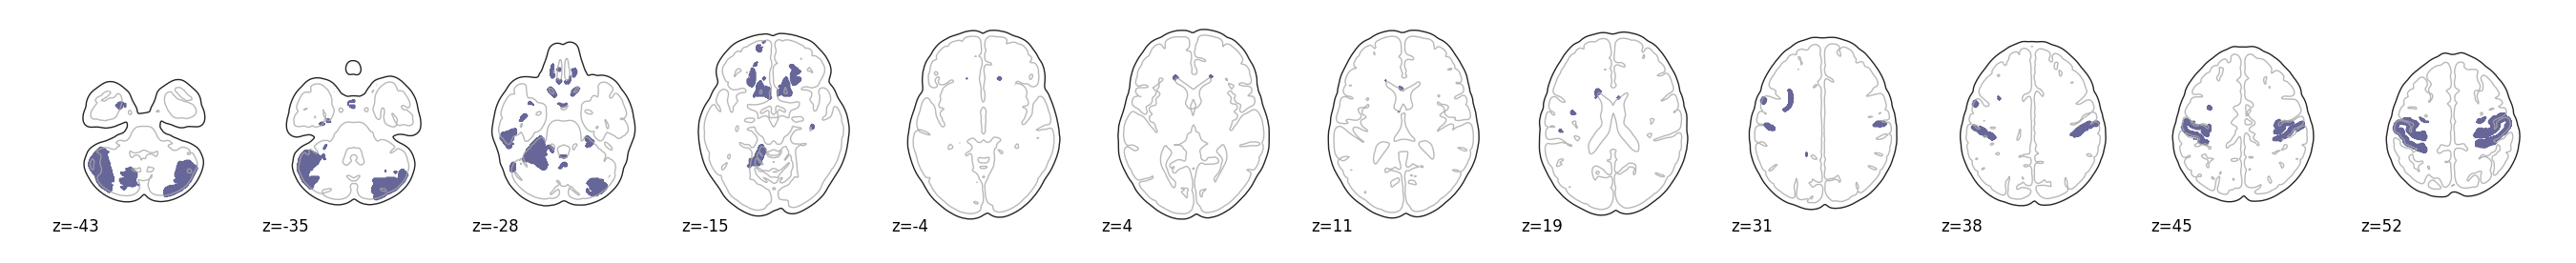

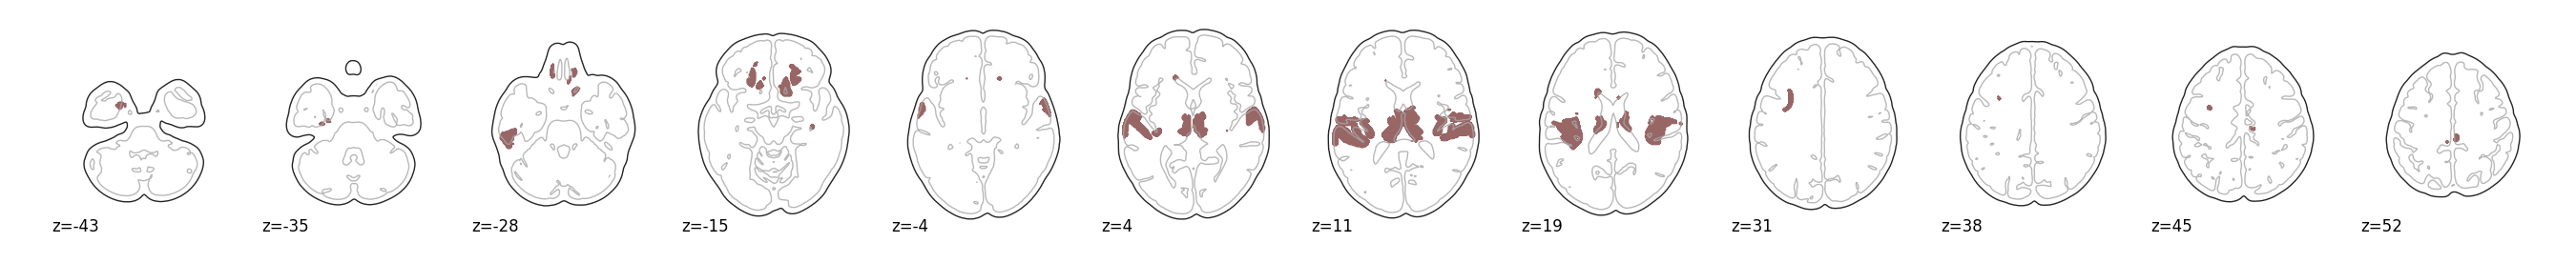

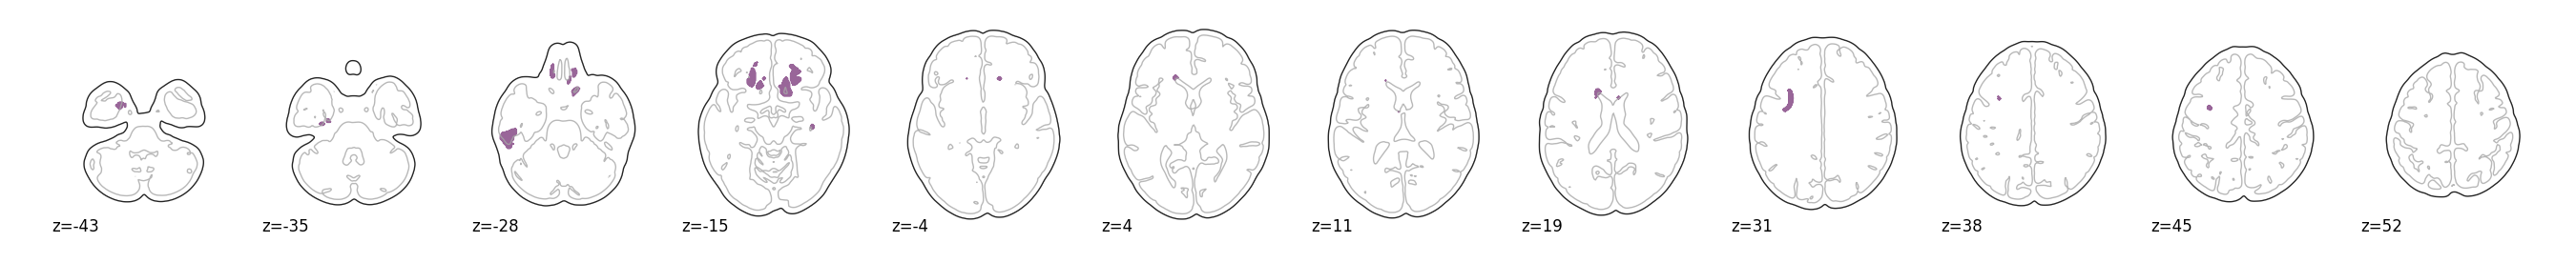

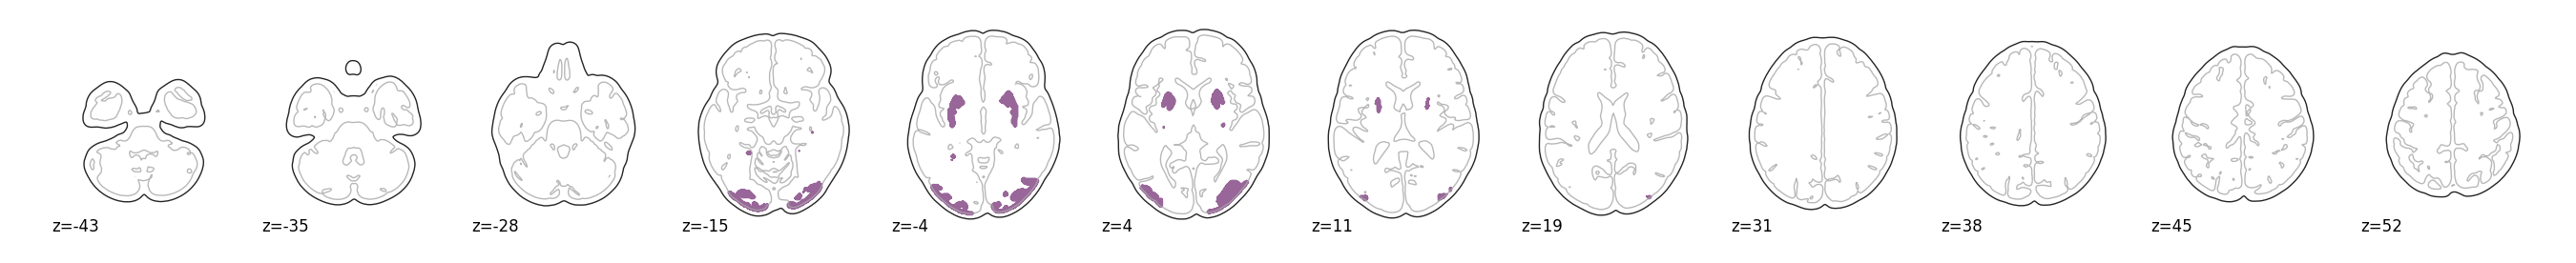

In [89]:
### import copy
colorgroup=np.array([(0,204,0,200),(0,204,204,255),(255,0,0,200),(255,102,178,200),(204,0,204,200),(178,102,255,200),(0,0,255,200)])/255.
number2=11


prov=np.sign(np.sum(np.sign(prov),0))
prov[np.where(np.isnan(prov))]=0
print prov
plotslicesZonecolor(prov/np.max(prov),col=(102/255.,102/255.,153/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_A-C_C_com_repro.pdf')
plt.show()

provad2=np.sign(np.sum(np.sign(provad2),0))
provad2[np.where(np.isnan(provad2))]=0
if np.sum(provad2)!=0:
    plotslicesZonecolor(provad2/np.max(provad2),col=(153/255.,102/255.,102/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
    plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_A-C_A_com_repro.pdf')
    plt.show()


provad3=provad2*prov
provad3[np.where(np.isnan(provad3))]=0
if np.sum(provad3)!=0:
    plotslicesZonecolor(provad3/np.max(provad3),col=(153/255.,102/255.,153/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
    plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_A-C_A-C_com_repro.pdf')
    plt.show()

provdown=np.sign(np.sum(np.sign(provdown),0))
if np.sum(provdown)!=0:
    plotslicesZonecolor(provdown/np.max(provdown),col=(153/255.,102/255.,153/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
    plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_A-C_down_com_repro.pdf')
    plt.show()

In [90]:
#50-25 A-S
import copy
colorgroup=np.array([(0,204,0,200),(0,204,204,255),(255,0,0,200),(255,102,178,200),(204,0,204,200),(178,102,255,200),(0,0,255,200)])/255.
number2=11

keepx=np.abs(SUMcommon[2]+SUMcommon[1]-(SUMcommon[5]+SUMcommon[4]))/(SUMcommon[0]+SUMcommon[1]+SUMcommon[5]+SUMcommon[4]+SUMcommon[2]+SUMcommon[3])

keepcon=(SUMcommon[0]+SUMcommon[3]+SUMcommon[5]+SUMcommon[4])
keepad=(SUMcommon[0]+SUMcommon[1]+SUMcommon[2]+SUMcommon[3])
keepall=(SUMcommon[0]+SUMcommon[1]+SUMcommon[5]+SUMcommon[4]+SUMcommon[2]+SUMcommon[3])

prov=copy.deepcopy(keepx)
prov[np.where(np.isnan(prov))]=0
prov[np.where(np.abs(prov)==np.inf)]=0
provad2=copy.deepcopy(prov)
provdown=copy.deepcopy(prov)
provall=copy.deepcopy(prov)

provad=copy.deepcopy(keepad)
prov2=copy.deepcopy(keepcon)
prov[np.where(prov2<0.25)]=0
provad2[np.where(provad<0.25)]=0

provdown[np.where(provad2+prov==0)]=0
provall[np.where(keepall<0.05)]=0

prov[np.where(prov<0.25)]=0
provad2[np.where(provad2<0.25)]=0
provdown[np.where(provdown>=0.25)]=0

prov[np.tril_indices(number)]=0
provall[np.tril_indices(number)]=0
provdown[np.tril_indices(number)]=0
provad2[np.tril_indices(number)]=0
prov=prov+prov.T
provall=provall+provall.T
provdown=provdown+provdown.T
provad2=provad2+provad2.T


In [91]:
number2=11

#50-25 A-S
##common area ?  make CONROL-ADHDcommat.json
colorgroup=np.array([(0,204,0),(0,204,204),(255,0,0),(255,102,178),(204,0,204),(178,102,255),(0,0,255)])/255.


grouplabel=['all group','ADHD & Control','ADHD','ADHD & ADHD Siblings','ADHD Siblings','ADHD Siblings & Control','Control']
#indmat=[[0,1,2],[0,2],[0],[0,1],[1],[1,2],[2]]
if atlas=='ICPAtlas_v3_2':
    print 'to do'
else:
    UpArea=[0,20,31,53,75,93,101,119,132,139,156,179]
    N=[20,11,22,22,18,8,18,13,7,17,23]
pal=np.concatenate([sns.color_palette("deep",6),sns.color_palette("pastel",6)],axis=0)
pal2=np.concatenate([[pal[i] for j in range(N[i])] for i in range(number2)],axis=0)
namearea=np.concatenate([['matADHD.'+net[i]+'.'+net[i]+'_'+np.str(j) for j in range(N[i])] for i in range(number2)],axis=0)
netarea=np.concatenate([[net[i] for j in range(N[i])] for i in range(number2)],axis=0)



print len(namearea)
nameL=['A-S_A','A-S_S','A-S-A-S','A-S_up05']
for l,mat in enumerate([provad2,prov,provdown,provall]):
    

    with open('pathtoresults/SIBLING-ADHDcommat_'+nameL[l]+'.json','w') as f:
        f.write('[\n')
        for o in range(number):
            f.write('{"name":"'+namearea[o]+'","size":6000,"net":"'+netarea[o]+'","type":"'+grouplabel[0].replace('&','').replace(' ','-')+'","imports":[')
            keep=[]
        
            for j in range(number):
                if mat[o][j]!=0:
                
                    keep+='"'+namearea[j]+'",'
            if keep!=[]:
            
                f.write(''.join(keep[:len(keep)-1]))
            #if prov[o]>=0.3:
            #    f.write('],"significant":'+np.str(np.sum(prov,0)[o])+'}')
            #else:
            f.write(']}')
            
            if o==number-1:
                f.write('\n]')
            else:
                f.write(',\n')
    
    


179


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.]


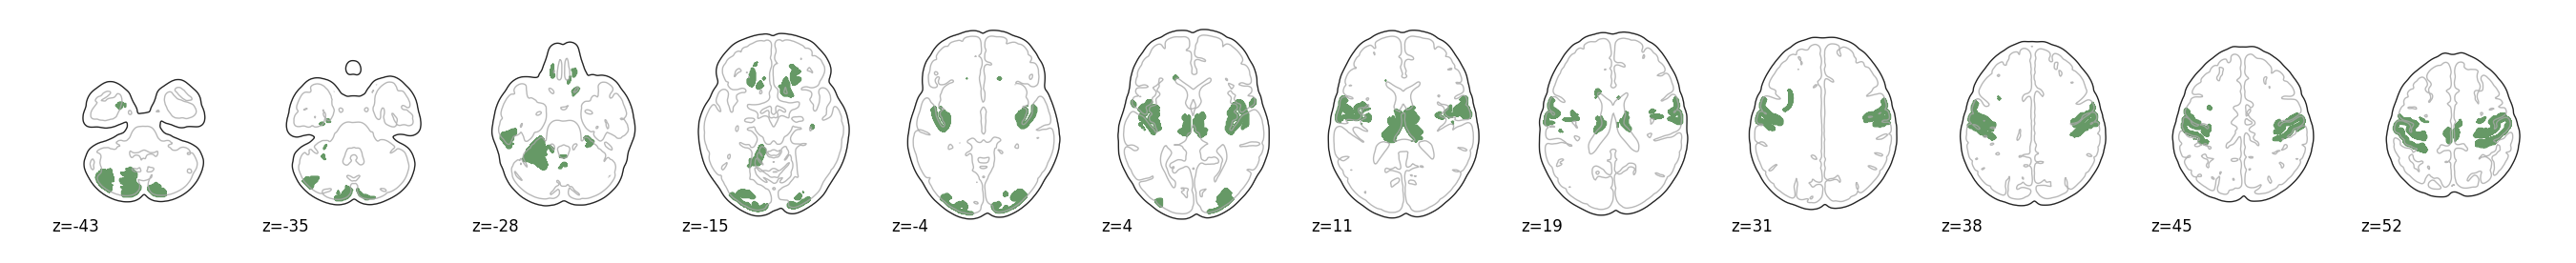

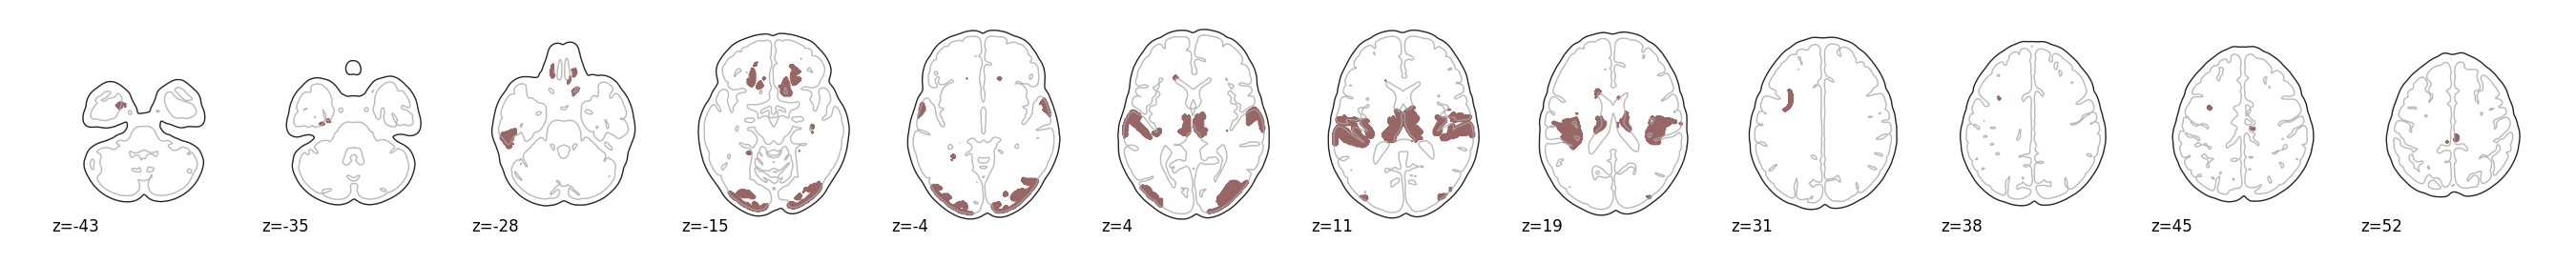

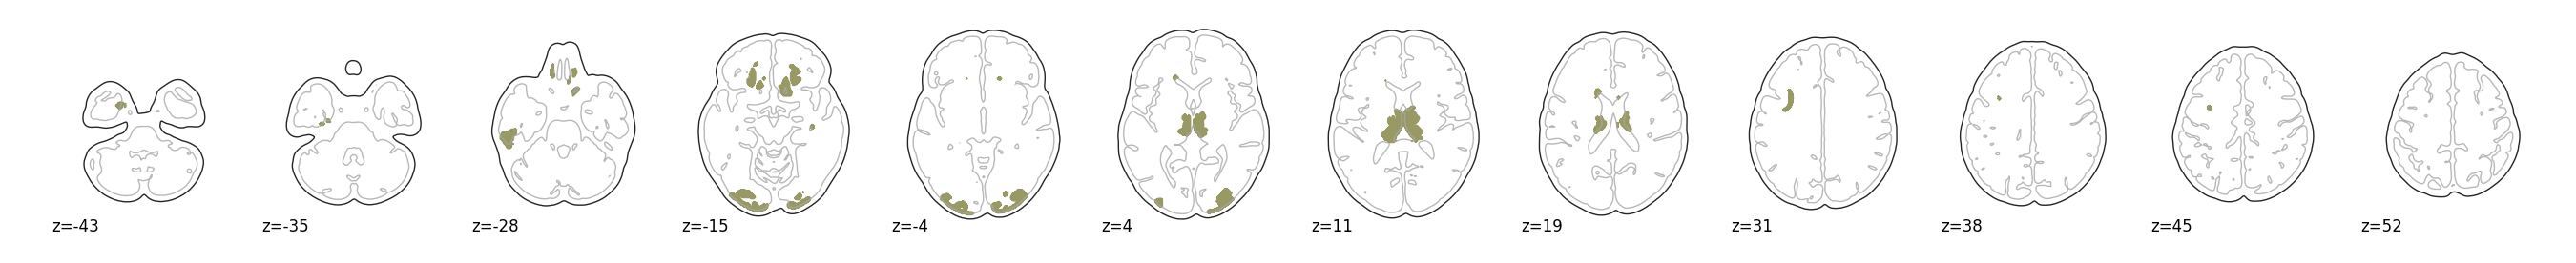

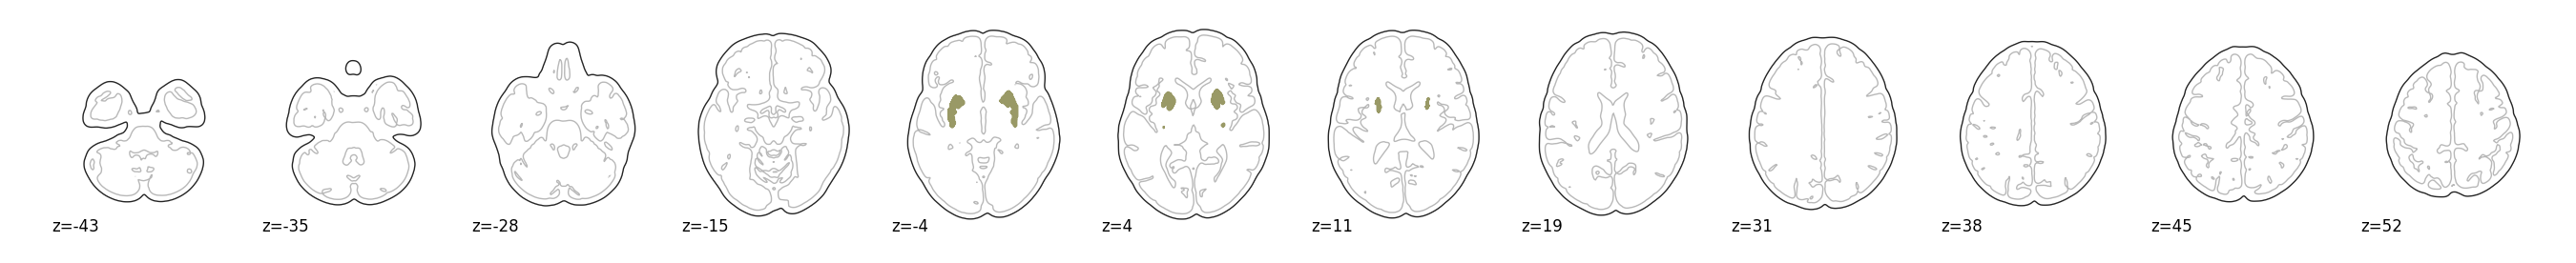

In [92]:
### import copy
colorgroup=np.array([(0,204,0,200),(0,204,204,255),(255,0,0,200),(255,102,178,200),(204,0,204,200),(178,102,255,200),(0,0,255,200)])/255.
colorgroup=[(172/255.,82/255.,82/255.),(103/255.,147/255.,102/255.),(90/255.,122/255.,149/255.)]
number2=11


prov=np.sign(np.sum(np.sign(prov),0))
prov[np.where(np.isnan(prov))]=0
print prov
plotslicesZonecolor(prov/np.max(prov),col=(102/255.,153/255.,102/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_A-S_S_com_repro.pdf')
plt.show()

provad2=np.sign(np.sum(np.sign(provad2),0))
provad2[np.where(np.isnan(provad2))]=0
if np.sum(provad2)!=0:
    plotslicesZonecolor(provad2/np.max(provad2),col=(153/255.,102/255.,102/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
    plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_A-S_A_com_repro.pdf')
    plt.show()

provad3=provad2*prov
provad3[np.where(np.isnan(provad3))]=0
if np.sum(provad3)!=0:
    plotslicesZonecolor(provad3/np.max(provad3),col=(153/255.,153/255.,102/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
    plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_A-S_A-S_com_repro.pdf')
    plt.show()

provdown=np.sign(np.sum(np.sign(provdown),0))
if np.sum(provdown)!=0:
    plotslicesZonecolor(provdown/np.max(provdown),col=(153/255.,153/255.,102/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
    plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_A-S_down_com_repro.pdf')
    plt.show()

In [93]:
#50-25 C-S
import copy
colorgroup=np.array([(0,204,0,200),(0,204,204,255),(255,0,0,200),(255,102,178,200),(204,0,204,200),(178,102,255,200),(0,0,255,200)])/255.
number2=11

keepx=np.abs(SUMcommon[1]+SUMcommon[6]-(SUMcommon[3]+SUMcommon[4]))/(SUMcommon[0]+SUMcommon[1]+SUMcommon[5]+SUMcommon[4]+SUMcommon[6]+SUMcommon[3])

keepad=(SUMcommon[0]+SUMcommon[3]+SUMcommon[5]+SUMcommon[4])
keepcon=(SUMcommon[0]+SUMcommon[1]+SUMcommon[5]+SUMcommon[6])
keepall=(SUMcommon[0]+SUMcommon[1]+SUMcommon[5]+SUMcommon[4]+SUMcommon[6]+SUMcommon[3])

prov=copy.deepcopy(keepx)
prov[np.where(np.isnan(prov))]=0
prov[np.where(np.abs(prov)==np.inf)]=0
provad2=copy.deepcopy(prov)
provdown=copy.deepcopy(prov)
provall=copy.deepcopy(prov)

provad=copy.deepcopy(keepad)
prov2=copy.deepcopy(keepcon)
prov[np.where(prov2<0.25)]=0
provad2[np.where(provad<0.25)]=0

provdown[np.where(provad2+prov==0)]=0
provall[np.where(keepall<0.05)]=0

prov[np.where(prov<0.25)]=0
provad2[np.where(provad2<0.25)]=0
provdown[np.where(provdown>=0.25)]=0

prov[np.tril_indices(number)]=0
provall[np.tril_indices(number)]=0
provdown[np.tril_indices(number)]=0
provad2[np.tril_indices(number)]=0
prov=prov+prov.T
provall=provall+provall.T
provdown=provdown+provdown.T
provad2=provad2+provad2.T


In [94]:
number2=11

#50-25 C-S
##common area ?  make CONROL-ADHDcommat.json
colorgroup=np.array([(0,204,0),(0,204,204),(255,0,0),(255,102,178),(204,0,204),(178,102,255),(0,0,255)])/255.


grouplabel=['all group','ADHD & Control','ADHD','ADHD & ADHD Siblings','ADHD Siblings','ADHD Siblings & Control','Control']
#indmat=[[0,1,2],[0,2],[0],[0,1],[1],[1,2],[2]]
if atlas=='ICPAtlas_v3_2':
    print 'to do'
else:
    UpArea=[0,20,31,53,75,93,101,119,132,139,156,179]
    N=[20,11,22,22,18,8,18,13,7,17,23]
pal=np.concatenate([sns.color_palette("deep",6),sns.color_palette("pastel",6)],axis=0)
pal2=np.concatenate([[pal[i] for j in range(N[i])] for i in range(number2)],axis=0)
namearea=np.concatenate([['matADHD.'+net[i]+'.'+net[i]+'_'+np.str(j) for j in range(N[i])] for i in range(number2)],axis=0)
netarea=np.concatenate([[net[i] for j in range(N[i])] for i in range(number2)],axis=0)



print len(namearea)
nameL=['C-S_C','C-S_S','C-S-C-S','C-S_up05']
for l,mat in enumerate([prov,provad2,provdown,provall]):
    

    with open('pathtoresults/SIBLING-CONTROLcommat_'+nameL[l]+'.json','w') as f:
        f.write('[\n')
        for o in range(number):
            f.write('{"name":"'+namearea[o]+'","size":6000,"net":"'+netarea[o]+'","type":"'+grouplabel[0].replace('&','').replace(' ','-')+'","imports":[')
            keep=[]
        
            for j in range(number):
                if mat[o][j]!=0:
                
                    keep+='"'+namearea[j]+'",'
            if keep!=[]:
            
                f.write(''.join(keep[:len(keep)-1]))
            #if prov[o]>=0.3:
            #    f.write('],"significant":'+np.str(np.sum(prov,0)[o])+'}')
            #else:
            f.write(']}')
            
            if o==number-1:
                f.write('\n]')
            else:
                f.write(',\n')
    
    


179


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


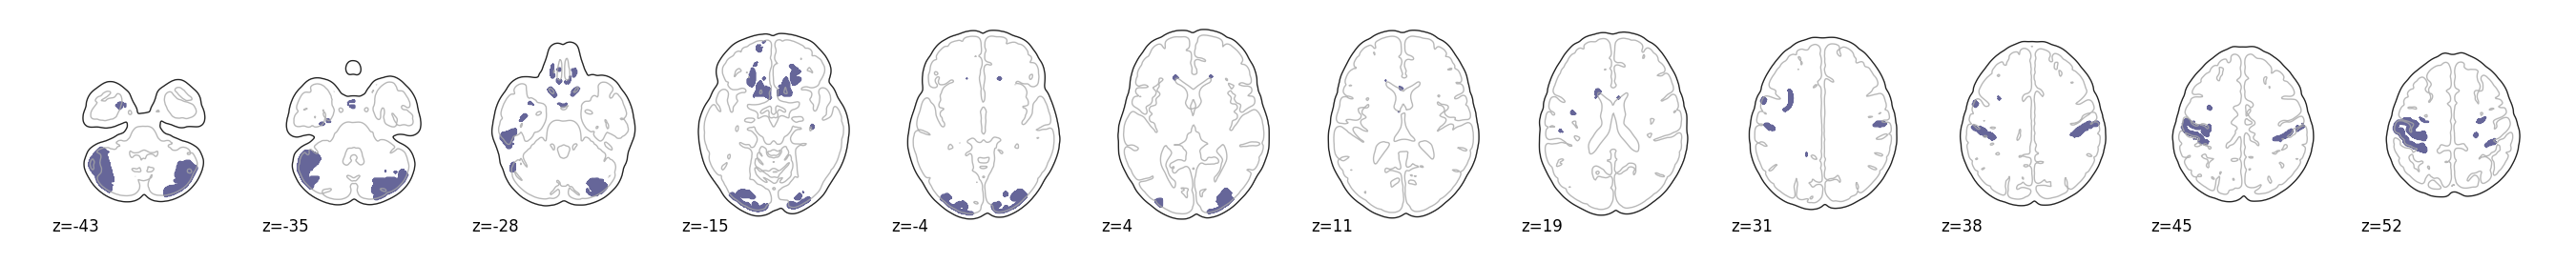

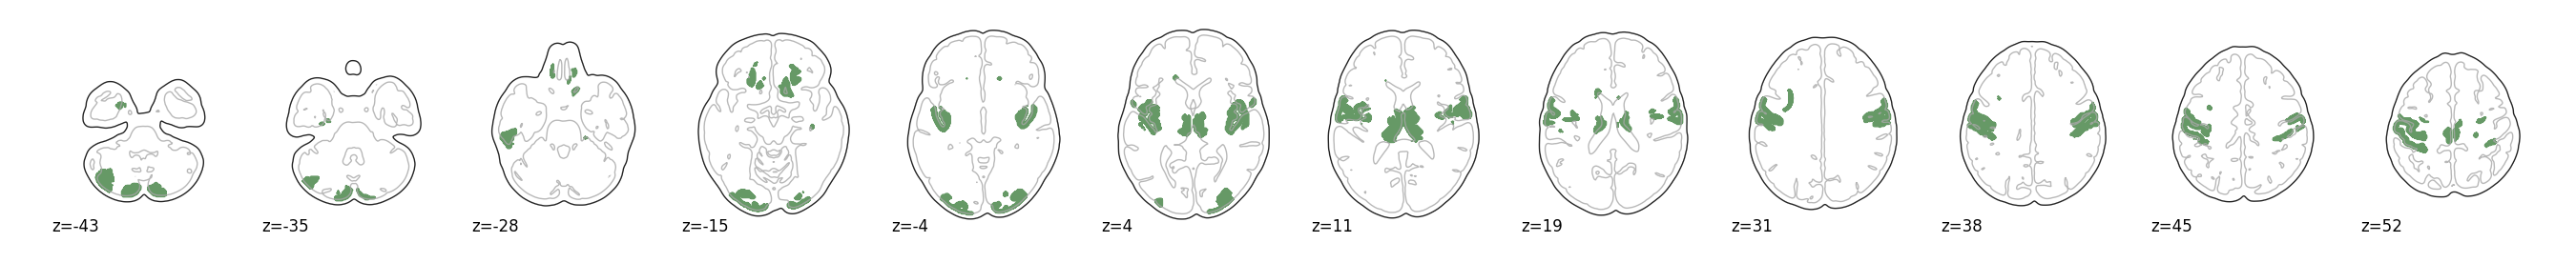

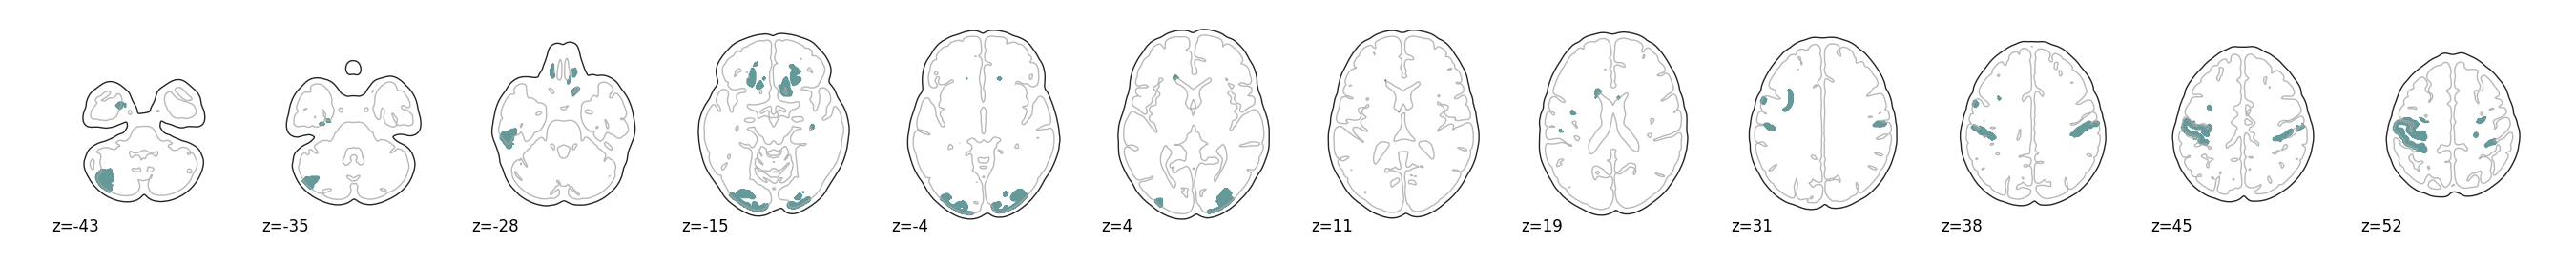

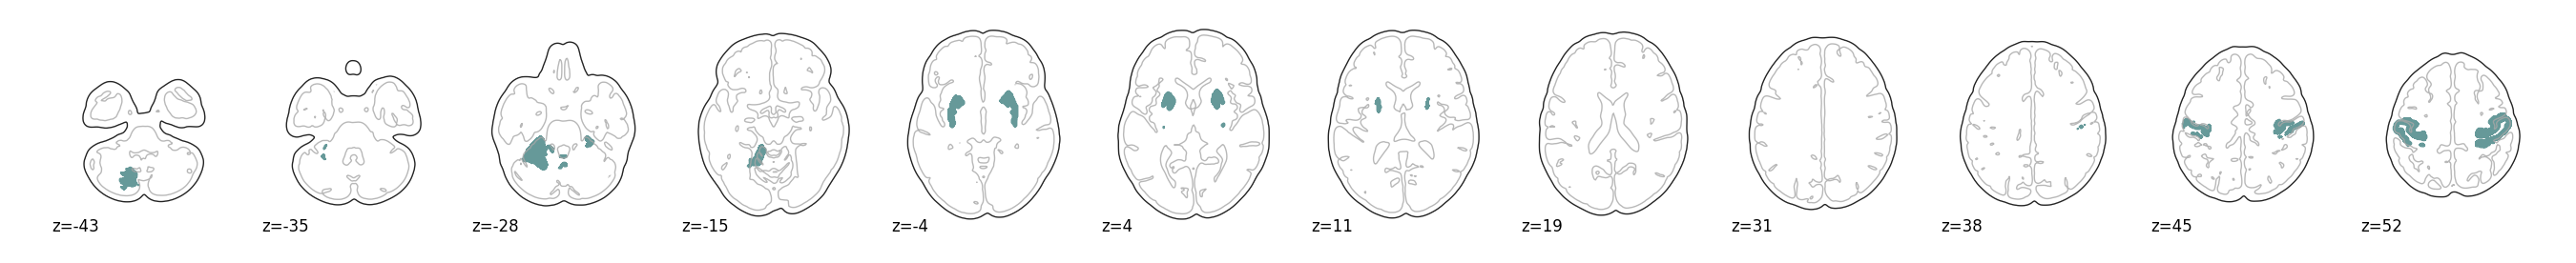

In [95]:
### import copy
colorgroup=np.array([(0,204,0,200),(0,204,204,255),(255,0,0,200),(255,102,178,200),(204,0,204,200),(178,102,255,200),(0,0,255,200)])/255.
colorgroup=[(172/255.,82/255.,82/255.),(103/255.,147/255.,102/255.),(90/255.,122/255.,149/255.)]
number2=11


prov=np.sign(np.sum(np.sign(prov),0))
prov[np.where(np.isnan(prov))]=0
print prov
plotslicesZonecolor(prov/np.max(prov),col=(102/255.,102/255.,153/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_C-S_C_com_repro.pdf')
plt.show()

provad2=np.sign(np.sum(np.sign(provad2),0))
provad2[np.where(np.isnan(provad2))]=0
if np.sum(provad2)!=0:
    plotslicesZonecolor(provad2/np.max(provad2),col=(102/255.,153/255.,102/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
    plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_C-S_S_com_repro.pdf')
    plt.show()

provad3=provad2*prov
provad3[np.where(np.isnan(provad3))]=0
if np.sum(provad3)!=0:
    plotslicesZonecolor(provad3/np.max(provad3),col=(102/255.,153/255.,153/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
    plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_C-S_C-S_com_repro.pdf')
    plt.show()

provdown=np.sign(np.sum(np.sign(provdown),0))
if np.sum(provdown)!=0:
    plotslicesZonecolor(provdown/np.max(provdown),col=(102/255.,153/255.,153/255.),cut_coords=[-43,-35,-28,-15,-4,4,11,19,31,38,45,52])
    plt.savefig('pathtodata/TasksVsRS_MatriceResult/reordering/'+fold+'/'+np.str(number)+'/slices_C-S_down_com_repro.pdf')
    plt.show()

In [25]:

number2=11
keepx=np.zeros((number,number))
keepx=-(SUMcommon[2]+SUMcommon[3]-(SUMcommon[5]+SUMcommon[6]))
keepx[np.tril_indices(number)]=0
keepx=keepx+keepx.T

prov=keepx#[np.where(keepx!=0)]
## mixture model to extract 2 blob
##or above 30%
##print for wheel
prov[np.where(prov<0.0)]=0
prov[np.tril_indices(number)]=0
prov=prov+prov.T

##common area ?  make CONROL-ADHDcommat.json
colorgroup=np.array([(0,204,0),(0,204,204),(255,0,0),(255,102,178),(204,0,204),(178,102,255),(0,0,255)])/255.

mat=prov
grouplabel=['all group','ADHD & Control','ADHD','ADHD & ADHD Siblings','ADHD Siblings','ADHD Siblings & Control','Control']
#indmat=[[0,1,2],[0,2],[0],[0,1],[1],[1,2],[2]]
if atlas=='ICPAtlas_v3_2':
    print 'to do'
else:
    UpArea=[0,20,31,53,75,93,101,119,132,139,156,179]
    N=[20,11,22,22,18,8,18,13,7,17,23]
pal=np.concatenate([sns.color_palette("deep",6),sns.color_palette("pastel",6)],axis=0)
pal2=np.concatenate([[pal[i] for j in range(N[i])] for i in range(number2)],axis=0)
namearea=np.concatenate([['matADHD.'+net[i]+'.'+net[i]+'_'+np.str(j) for j in range(N[i])] for i in range(number2)],axis=0)
netarea=np.concatenate([[net[i] for j in range(N[i])] for i in range(number2)],axis=0)
print len(namearea)
if True:
    

    with open('pathtoresults/CONROL-ADHDcommat0percent.json','w') as f:
        f.write('[\n')
        for o in range(number):
            f.write('{"name":"'+namearea[o]+'","size":6000,"net":"'+netarea[o]+'","type":"'+grouplabel[0].replace('&','').replace(' ','-')+'","imports":[')
            keep=[]
        
            for j in range(number):
                if prov[o][j]!=0:
                
                    keep+='"'+namearea[j]+'",'
            if keep!=[]:
            
                f.write(''.join(keep[:len(keep)-1]))
            
            f.write(']}')
            
            if o==number-1:
                f.write('\n]')
            else:
                f.write(',\n')
    
    


179
